In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# uncomment to disable numba
# os.environ['NOJIT'] = 'true'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import pprint
from njit_multisymbol import *
from procedures import utc_ms, load_live_config, fetch_market_specific_settings, make_get_filepath
from pure_funcs import (
    date_to_ts2,
    ts_to_date_utc,
    tuplify,
    numpyize,
    stats_multi_to_df,
    fills_multi_to_df,
    calc_drawdowns,
    calc_sharpe_ratio,
    analyze_fills_multi,
    live_config_dict_to_list_recursive_grid,
)
from njit_funcs import round_dynamic
from plotting import plot_fills_multi, plot_pnls_long_short, plot_pnls_separate, plot_pnls_stuck
from numba import njit
from downloader import load_hlc_cache, prepare_multsymbol_data

using numba
using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

### multi symbol backtest with lossless auto unstuck

- if a position is stuck, bot will use profits made on other markets to realize losses for the stuck position
- if multiple positions are stuck, select the stuck pos whose price action distance is the lowest
- each live config's individual auto unstuck is disabled

In [4]:
# select symbols for multi symbol backtest
symbols = [
    "AAVEUSDT",
    "BANDUSDT",
    "BLZUSDT",
    "DEFIUSDT",
    "DOGEUSDT",
    "DOTUSDT",
    "EGLDUSDT",
    "ENJUSDT",
    "GRTUSDT",
    "LINKUSDT",
    "MKRUSDT",
    "OCEANUSDT",
    "OMGUSDT",
    "REEFUSDT",
    "RLCUSDT",
    "RSRUSDT",
    "RUNEUSDT",
    "SKLUSDT",
    "SNXUSDT",
    "SUSHIUSDT",
    "SXPUSDT",
    "THETAUSDT",
    "TOMOUSDT",
    "XRPUSDT",
    "ZENUSDT",
    "ZILUSDT",
]
print(symbols)
long_enabled = True
short_enabled = False
symbols = tuple(symbols)
lcs = [
    load_live_config(f"configs/live/multisymbol/no_AU/{symbol}.json") for symbol in symbols
]  # each symbol may have its own config

TWE_long = 3.0  # WE_limit for each symbol will be TWE / len(symbols)
TWE_short = 1.25  # WE_limit for each symbol will be TWE / len(symbols)

loss_allowance_pct = 0.01  # pct below peak balance to allow losses
stuck_threshold = 0.95  # if WE / WE_limit > unstuck_threshold: consider position as stuck
unstuck_close_pct = 0.01  # max pct of balance * WE_limit to close on each unstuck order

for i in range(len(lcs)):
    lcs[i]["long"]["wallet_exposure_limit"] = TWE_long / len(symbols)
    lcs[i]["short"]["wallet_exposure_limit"] = TWE_short / len(symbols)

# convert configs to numpy matrix
live_configs = numpyize([live_config_dict_to_list_recursive_grid(lc) for lc in lcs])

['AAVEUSDT', 'BANDUSDT', 'BLZUSDT', 'DEFIUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'ENJUSDT', 'GRTUSDT', 'LINKUSDT', 'MKRUSDT', 'OCEANUSDT', 'OMGUSDT', 'REEFUSDT', 'RLCUSDT', 'RSRUSDT', 'RUNEUSDT', 'SKLUSDT', 'SNXUSDT', 'SUSHIUSDT', 'SXPUSDT', 'THETAUSDT', 'TOMOUSDT', 'XRPUSDT', 'ZENUSDT', 'ZILUSDT']


In [5]:
start_date = "2019-01-01"
end_date = "now"
if end_date in ["now", "", "today"]:
    end_date = ts_to_date_utc(utc_ms())[:10]
coins = [s.replace("USDT", "") for s in symbols]
cache_fname = make_get_filepath(f"tmp/cache/{'_'.join(coins)}_{start_date}_{end_date}_hlc_cache.npy")
print("cache filename", cache_fname)
# prepare_multsymbol_data() is computationally expensive, so use a cache
try:
    hlcs = np.load(cache_fname)
    first_ts = 0
except:
    first_ts, hlcs = await prepare_multsymbol_data(symbols, start_date, end_date)
    np.save(cache_fname, hlcs)

cache filename tmp/cache/AAVE_BAND_BLZ_DEFI_DOGE_DOT_EGLD_ENJ_GRT_LINK_MKR_OCEAN_OMG_REEF_RLC_RSR_RUNE_SKL_SNX_SUSHI_SXP_THETA_TOMO_XRP_ZEN_ZIL_2019-01-01_2023-12-10_hlc_cache.npy


In [6]:
starting_balance = 1000000.0
do_longs = tuplify([long_enabled for _ in range(len(symbols))])
do_shorts = tuplify([short_enabled for _ in range(len(symbols))])

cache_fname_mss = make_get_filepath("tmp/" + "_".join(symbols) + "_market_specific_settings.json")

mss = []
for symbol in symbols:
    cache_fname_mss = make_get_filepath(f"tmp/market_specific_settings/{symbol}.json")
    try:
        mss.append(json.load(open(cache_fname_mss)))
    except:
        print("fetching market specific settings for", symbol)
        mss_ = fetch_market_specific_settings(
            {"symbol": symbol, "exchange": "binance", "market_type": "futures"}
        )
        json.dump(mss_, open(cache_fname_mss, "w"))
        mss.append(mss_)

maker_fee = mss[0]["maker_fee"]

qty_steps = tuplify([mss[i]["qty_step"] for i in range(len(symbols))])
price_steps = tuplify([mss[i]["price_step"] for i in range(len(symbols))])
min_costs = tuplify([mss[i]["min_cost"] for i in range(len(symbols))])
min_qtys = tuplify([mss[i]["min_qty"] for i in range(len(symbols))])
c_mults = tuplify([mss[i]["c_mult"] for i in range(len(symbols))])

In [7]:
hlcs_clipped = hlcs  # [:,0:60000] # to backtest on subset on data

In [8]:
# will compile JIT on the first run, then be faster on subsequent runs
sts = utc_ms()
res = backtest_multisymbol_recursive_grid(
    hlcs_clipped,
    starting_balance,
    maker_fee,
    do_longs,
    do_shorts,
    c_mults,
    symbols,
    qty_steps,
    price_steps,
    min_costs,
    min_qtys,
    live_configs,
    loss_allowance_pct,
    stuck_threshold,
    unstuck_close_pct,
)
print(f"time elapsed {(utc_ms() - sts) / 1000:.6f}s")
fills, stats = res

time elapsed 149.847316s


In [9]:
fdf = fills_multi_to_df(fills, symbols, c_mults)
sdf = stats_multi_to_df(stats, symbols, c_mults)

In [10]:
params = {"TWE_long": TWE_long, "TWE_short": TWE_short}
analysis = analyze_fills_multi(sdf, fdf, params)

In [11]:
mkl = max([len(k) for k in analysis])
for k, v in analysis.items():
    if isinstance(v, dict):
        continue
        mkls = max([len(s) for s in v])
        for symbol in v:
            mkl1 = max([len(k) for k in v[symbol]])
            for k1, v1 in v[symbol].items():
                print(f"    {symbol: <{mkls}} {k1: <{mkl1}} {round_dynamic(v1, 6)}")
            print()
    else:
        print(f"{k: <{mkl}} {round_dynamic(v, 6)}")
adf = pd.DataFrame({k: v for k, v in analysis["individual_analyses"].items()})
adf

n_days                     1431.67
starting_balance           1000000.0
final_balance              451362000.0
final_equity               451331000.0
drawdown_max               0.522506
mean_of_10_worst_drawdowns 0.231477
adg                        0.00448954
pnl_sum                    471462000.0
pnl_long                   471462000.0
pnl_short                  0.0
pnl_ratio_long_short       1.0
sum_profit_long            515610000.0
sum_profit_short           0.0
sum_loss_long              -44148800.0
sum_loss_short             0.0
loss_profit_ratio_long     0.0856244
loss_profit_ratio_short    1.0
stuck_time_ratio_long      0.220337
stuck_time_ratio_short     0.0
stuck_time_ratio_any       0.220337
eqbal_ratio_mean           0.994944
eqbal_ratio_min            0.448537
n_fills_per_day            273.576
shape_ratio_daily          0.205433


AAVEUSDT          BANDUSDT           BLZUSDT  \
pnl_ratio                4.4800158963e-02  4.6213786013e-02  2.9843079338e-02   
pnl_ratio_long_short     1.0000000000e+00  1.0000000000e+00  1.0000000000e+00   
pnl_long                 2.1121554231e+07  2.1788025090e+07  1.4069865672e+07   
pnl_short                0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
sum_profit_long          2.6908994822e+07  2.5803009948e+07  1.4126160867e+07   
sum_loss_long           -5.7874405907e+06 -4.0149848580e+06 -5.6295195188e+04   
loss_profit_ratio_long   2.1507457372e-01  1.5560141496e-01  3.9851730218e-03   
sum_profit_short         0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
sum_loss_short           0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
loss_profit_ratio_short  1.0000000000e+00  1.0000000000e+00  1.0000000000e+00   
stuck_time_ratio_long    4.8543406769e-02  1.3998428451e-02  4.2490032304e-03   
stuck_time_ratio_short   0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
n_fills_per_day          1.6776251455e+01  1.1919674040e+01  9.4973224680e+00   
upnl_pct_min_long       -4.2055592698e-02 -3.3253188935e-02 -2.0099735490e-02   
upnl_pct_min_short                    NaN               NaN               NaN   

                                 DEFIUSDT          DOGEUSDT           DOTUSDT  \
pnl_ratio                2.8950933291e-02  5.5797792938e-02  3.4881668011e-02   
pnl_ratio_long_short     1.0000000000e+00  1.0000000000e+00  1.0000000000e+00   
pnl_long                 1.3649253077e+07  2.6306516245e+07  1.6445366705e+07   
pnl_short                0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
sum_profit_long          1.3839411407e+07  2.6556536701e+07  1.9644951234e+07   
sum_loss_long           -1.9015833079e+05 -2.5002045605e+05 -3.1995845293e+06   
loss_profit_ratio_long   1.3740348140e-02  9.4146484108e-03  1.6287057632e-01   
sum_profit_short         0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
sum_loss_short           0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
loss_profit_ratio_short  1.0000000000e+00  1.0000000000e+00  1.0000000000e+00   
stuck_time_ratio_long    9.0509589360e-03  1.2979831786e-02  2.1623352056e-02   
stuck_time_ratio_short   0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
n_fills_per_day          8.6912689173e+00  1.2240279395e+01  2.3306402794e+01   
upnl_pct_min_long       -3.0213377704e-02 -5.5442447968e-02 -4.0708560571e-02   
upnl_pct_min_short                    NaN               NaN               NaN   

                                 EGLDUSDT           ENJUSDT           GRTUSDT  \
pnl_ratio                3.0295196272e-02  3.9703674025e-02  4.4229656753e-02   
pnl_ratio_long_short     1.0000000000e+00  1.0000000000e+00  1.0000000000e+00   
pnl_long                 1.4283021440e+07  1.8718757333e+07  2.0852584352e+07   
pnl_short                0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
sum_profit_long          1.5391300177e+07  1.9026517754e+07  2.1214381010e+07   
sum_loss_long           -1.1082787364e+06 -3.0776042150e+05 -3.6179665836e+05   
loss_profit_ratio_long   7.2006830073e-02  1.6175341462e-02  1.7054311327e-02   
sum_profit_short         0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
sum_loss_short           0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
loss_profit_ratio_short  1.0000000000e+00  1.0000000000e+00  1.0000000000e+00   
stuck_time_ratio_long    2.4708244812e-02  1.1524693693e-02  9.1673699834e-03   
stuck_time_ratio_short   0.0000000000e+00  0.0000000000e+00  0.0000000000e+00   
n_fills_per_day          4.9948777648e+00  6.7431897555e+00  1.2268917346e+01   
upnl_pct_min_long       -3.8182348236e-02 -3.4964702358e-02 -5.3424723369e-02   
upnl_pct_min_short                    NaN               NaN               NaN   

                                 LINKUSDT  ...          RUNEUSDT  \
pnl_ratio                3.7531570131e-02  ...  3.2575224010e-02   
pnl_ra

In [12]:
if not adf.T.upnl_pct_min_long.isna().all():
    print("upnl pct min long")
    print(adf.T.upnl_pct_min_long.sort_values())
    print()
if not adf.T.upnl_pct_min_short.isna().all():
    print("upnl pct min short")
    print(adf.T.upnl_pct_min_short.sort_values())

upnl pct min long
RLCUSDT     -0.0602976698
LINKUSDT    -0.0579016693
DOGEUSDT    -0.0554424480
GRTUSDT     -0.0534247234
XRPUSDT     -0.0524513987
THETAUSDT   -0.0517727262
SNXUSDT     -0.0423541987
AAVEUSDT    -0.0420555927
OCEANUSDT   -0.0417717271
SKLUSDT     -0.0408698109
DOTUSDT     -0.0407085606
EGLDUSDT    -0.0381823482
OMGUSDT     -0.0350473274
ENJUSDT     -0.0349647024
BANDUSDT    -0.0332531889
REEFUSDT    -0.0332456010
SXPUSDT     -0.0319823484
DEFIUSDT    -0.0302133777
RSRUSDT     -0.0291212310
MKRUSDT     -0.0287199362
SUSHIUSDT   -0.0280122177
RUNEUSDT    -0.0255557643
ZENUSDT     -0.0243807728
TOMOUSDT    -0.0227044726
BLZUSDT     -0.0200997355
ZILUSDT     -0.0190692626
Name: upnl_pct_min_long, dtype: float64



In [13]:
if not (adf.T.loss_profit_ratio_long == 1.0).all():
    print("loss_profit_ratio_long")
    print(adf.T.loss_profit_ratio_long.sort_values(ascending=False))
    print()
if not (adf.T.loss_profit_ratio_short == 1.0).all():
    print("loss_profit_ratio_short")
    print(adf.T.loss_profit_ratio_short.sort_values(ascending=False))

loss_profit_ratio_long
OCEANUSDT    0.2272229818
RLCUSDT      0.2165376708
AAVEUSDT     0.2150745737
RUNEUSDT     0.1849769402
DOTUSDT      0.1628705763
BANDUSDT     0.1556014150
SKLUSDT      0.1423267396
SUSHIUSDT    0.1040257915
LINKUSDT     0.0978679890
TOMOUSDT     0.0965321283
EGLDUSDT     0.0720068301
XRPUSDT      0.0653816872
MKRUSDT      0.0470236121
OMGUSDT      0.0390119218
THETAUSDT    0.0188647651
GRTUSDT      0.0170543113
ENJUSDT      0.0161753415
REEFUSDT     0.0149920811
DEFIUSDT     0.0137403481
DOGEUSDT     0.0094146484
SNXUSDT      0.0083465617
SXPUSDT      0.0080746949
ZENUSDT      0.0073063676
ZILUSDT      0.0050836868
RSRUSDT      0.0049660212
BLZUSDT      0.0039851730
Name: loss_profit_ratio_long, dtype: float64



In [14]:
adf.T.pnl_ratio.sort_values()

TOMOUSDT     0.0265222474
SUSHIUSDT    0.0284974169
ZILUSDT      0.0286362436
DEFIUSDT     0.0289509333
BLZUSDT      0.0298430793
ZENUSDT      0.0301802869
EGLDUSDT     0.0302951963
SXPUSDT      0.0310470353
RSRUSDT      0.0321858011
RUNEUSDT     0.0325752240
REEFUSDT     0.0331661617
THETAUSDT    0.0334455381
DOTUSDT      0.0348816680
SKLUSDT      0.0365246330
XRPUSDT      0.0374710341
LINKUSDT     0.0375315701
ENJUSDT      0.0397036740
OCEANUSDT    0.0440057575
GRTUSDT      0.0442296568
AAVEUSDT     0.0448001590
BANDUSDT     0.0462137860
OMGUSDT      0.0489938271
MKRUSDT      0.0522506939
RLCUSDT      0.0543713505
DOGEUSDT     0.0557977929
SNXUSDT      0.0578792333
Name: pnl_ratio, dtype: float64

In [15]:
sdf

balance            equity  AAVEUSDT_psize_l  \
minute                                                          
0        1.0000000000e+06  1.0000000000e+06               NaN   
60       1.0000000000e+06  1.0000000000e+06               NaN   
120      1.0000000000e+06  1.0000000000e+06               NaN   
180      1.0000000000e+06  1.0000000000e+06               NaN   
240      1.0000158477e+06  1.0000158477e+06               NaN   
...                   ...               ...               ...   
2061360  4.5125855202e+08  4.5116295682e+08            7164.4   
2061420  4.5129694640e+08  4.5125884985e+08            7164.4   
2061480  4.5133394037e+08  4.5128222541e+08            7164.4   
2061540  4.5134238397e+08  4.5127333176e+08            7164.4   
2061600  4.5136160028e+08  4.5133127450e+08            7164.4   

         AAVEUSDT_pprice_l  AAVEUSDT_psize_s  AAVEUSDT_pprice_s  \
minute                                                            
0                      NaN               NaN                NaN   
60                     NaN               NaN                NaN   
120                    NaN               NaN                NaN   
180                    NaN               NaN                NaN   
240                    NaN               NaN                NaN   
...                    ...               ...                ...   
2061360              99.16               NaN                NaN   
2061420              99.16               NaN                NaN   
2061480              99.16               NaN                NaN   
2061540              99.16               NaN                NaN   
2061600              99.16               NaN                NaN   

         AAVEUSDT_price  AAVEUSDT_upnl_pct_l  AAVEUSDT_upnl_pct_s  \
minute                                                              
0                   NaN                  NaN                  NaN   
60                  NaN                  NaN                  NaN   
120                 NaN                  NaN                  NaN   
180                 NaN                  NaN                  NaN   
240                 NaN                  NaN                  NaN   
...                 ...                  ...                  ...   
2061360           98.25        -0.0000144476                  NaN   
2061420           98.69        -0.0000074613                  NaN   
2061480           98.72        -0.0000069845                  NaN   
2061540           98.18        -0.0000155561                  NaN   
2061600           98.72        -0.0000069841                  NaN   

         BANDUSDT_psize_l  ...  THETAUSDT_WE_l  THETAUSDT_WE_s  TOMOUSDT_WE_l  \
minute                     ...                                                  
0                     NaN  ...             NaN             NaN            NaN   
60                    NaN  ...             NaN             NaN            NaN   
120                   NaN  ...             NaN             NaN            NaN   
180                   NaN  ...             NaN             NaN            NaN   
240                   NaN  ...             NaN             NaN            NaN   
...                   ...  ...             ...             ...            ...   
2061360          349604.2  ...    0.0016487386             NaN   0.0012559438   
2061420          349604.2  ...    0.0016485983             NaN   0.0012558369   
2061480          349604.2  ...    0.0016484632             NaN   0.0012557340   
2061540          349604.2  ...    0.0016484323             NaN   0.0012557105   
2061600          349604.2  ...    0.0016483622             NaN   0.0012556571   

         TOMOUSDT_WE_s  XRPUSDT_WE_l  XRPUSDT_WE_s  ZENUSDT_WE_l  \
minute                                                             
0                  NaN           NaN           NaN           NaN   
60                 NaN           NaN           NaN           NaN   
120                NaN           NaN           NaN           NaN   
180     

In [16]:
fdf

symbol               pnl       fee_paid           balance  \
minute                                                                  
195        XRPUSDT      0.0000000000   -0.317895480  9.9999968210e+05   
239        XRPUSDT     16.4868000000   -0.321192840  1.0000158477e+06   
333        XRPUSDT      0.0000000000   -0.317899220  1.0000155298e+06   
472        XRPUSDT     16.3559000000   -0.321170400  1.0000315645e+06   
492        XRPUSDT      0.0000000000   -0.317906736  1.0000312466e+06   
...            ...               ...            ...               ...   
2061512    SXPUSDT      0.0000000000 -134.434707216  4.5133313396e+08   
2061515  OCEANUSDT   9770.0329999998 -388.847313400  4.5134251514e+08   
2061536  SUSHIUSDT      0.0000000000 -131.169240640  4.5134238397e+08   
2061565    SXPUSDT   5213.3418000000 -135.477375576  4.5134746184e+08   
2061567   DOGEUSDT  14465.4727499998 -327.025688864  4.5136160028e+08   

                   equity               qty    price             psize  \
minute                                                                   
195      9.9999968210e+05  7.4940000000e+03  0.21210  7.4940000000e+03   
239      1.0000383297e+06 -7.4940000000e+03  0.21430  0.0000000000e+00   
333      1.0000155298e+06  7.4345000000e+03  0.21380  7.4345000000e+03   
472      1.0000494073e+06 -7.4345000000e+03  0.21600  0.0000000000e+00   
492      1.0000312466e+06  7.4312000000e+03  0.21390  7.4312000000e+03   
...                   ...               ...      ...               ...   
2061512  4.5124054094e+08  1.7377806000e+06  0.38680  1.7377806000e+06   
2061515  4.5128124419e+08 -3.7577050000e+06  0.51740  0.0000000000e+00   
2061536  4.5126880217e+08  5.0206400000e+05  1.30630  5.0206400000e+05   
2061565  4.5135019138e+08 -1.7377806000e+06  0.38980  0.0000000000e+00   
2061567  4.5135725209e+08 -1.7061023000e+07  0.09584  0.0000000000e+00   

         pprice                type     stuckness              cost  \
minute                                                                
195      0.2121  long_ientry_normal  0.0137754752  1.5894774000e+03   
239      0.0000         long_nclose  0.0000000000  1.6059642000e+03   
333      0.2138  long_ientry_normal  0.0137754189  1.5894961000e+03   
472      0.0000         long_nclose  0.0000000000  1.6058520000e+03   
492      0.2139  long_ientry_normal  0.0137755281  1.5895336800e+03   
...         ...                 ...           ...               ...   
2061512  0.3868  long_ientry_normal  0.0129073262  6.7217353608e+05   
2061515  0.0000         long_nclose  0.0000000000  1.9442365670e+06   
2061536  1.3063  long_ientry_normal  0.0125935446  6.5584620320e+05   
2061565  0.0000         long_nclose  0.0000000000  6.7738687788e+05   
2061567  0.0000         long_nclose  0.0000000000  1.6351284443e+06   

                   WE  upnl_pct  
minute                           
195      0.0015894779       0.0  
239      0.0000000000       0.0  
333      0.0015894714       0.0  
472      0.0000000000       0.0  
492      0.0015894840       0.0  
...               ...       ...  
2061512  0.0014893069       0.0  
2061515  0.0000000000       0.0  
2061536  0.0014531013       0.0  
2061565  0.0000000000       0.0  
2061567  0.0000000000       0.0  

[391669 rows x 14 columns]

minute
718560    -0.5225060408
1003680   -0.2768987422
724320    -0.2685811724
1075680   -0.2395548864
1078560   -0.2069448140
897120    -0.1786106427
1800000   -0.1616076096
1121760   -0.1597459824
506880    -0.1540017929
1801440   -0.1463136173
Name: equity, dtype: float64


<AxesSubplot:xlabel='minute'>

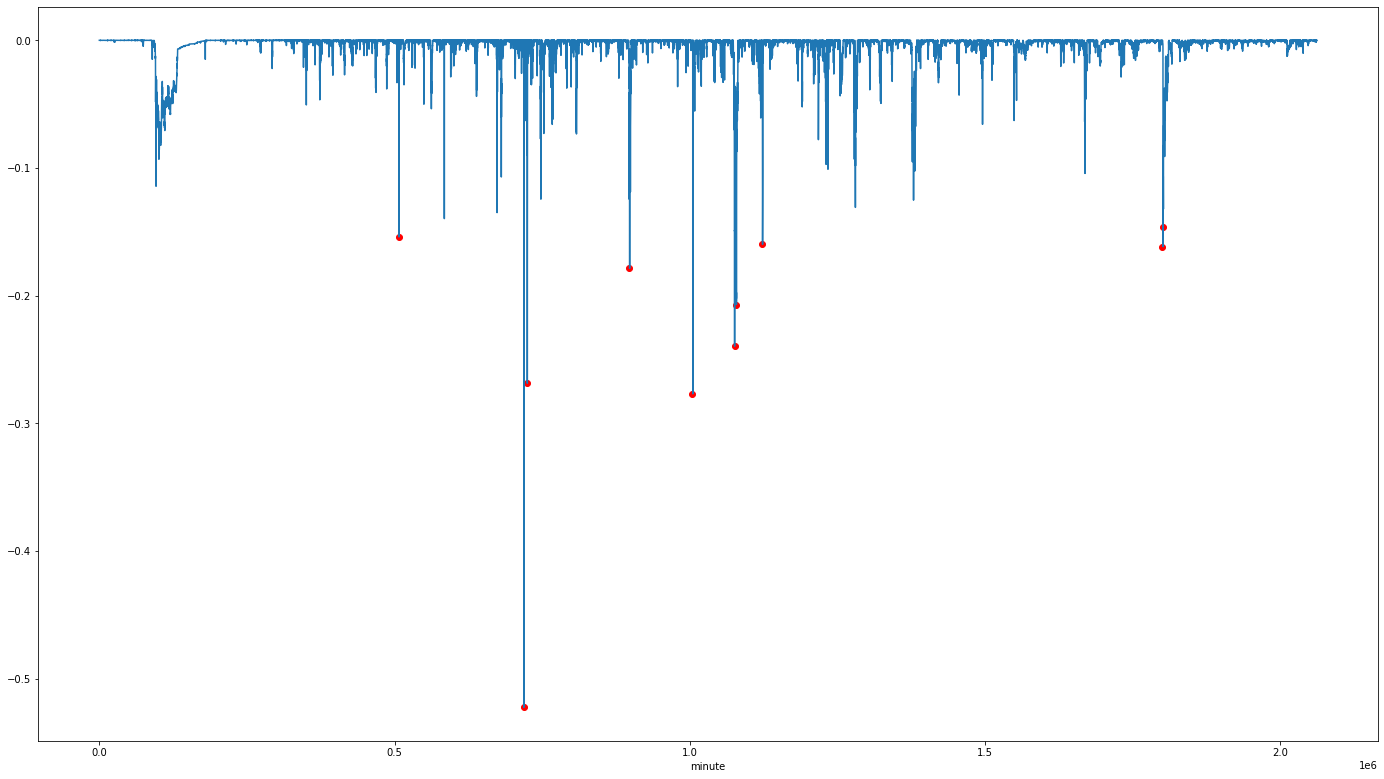

In [17]:
# plot drawdowns
min_multiplier = 60 * 24
drawdowns = calc_drawdowns(sdf.equity)
drawdowns_daily = drawdowns.groupby(drawdowns.index // min_multiplier * min_multiplier).min()
drawdowns_ten_worst = drawdowns_daily.sort_values().iloc[:10]
print(drawdowns_ten_worst)
drawdowns_ten_worst.plot(style="ro")
drawdowns.plot()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

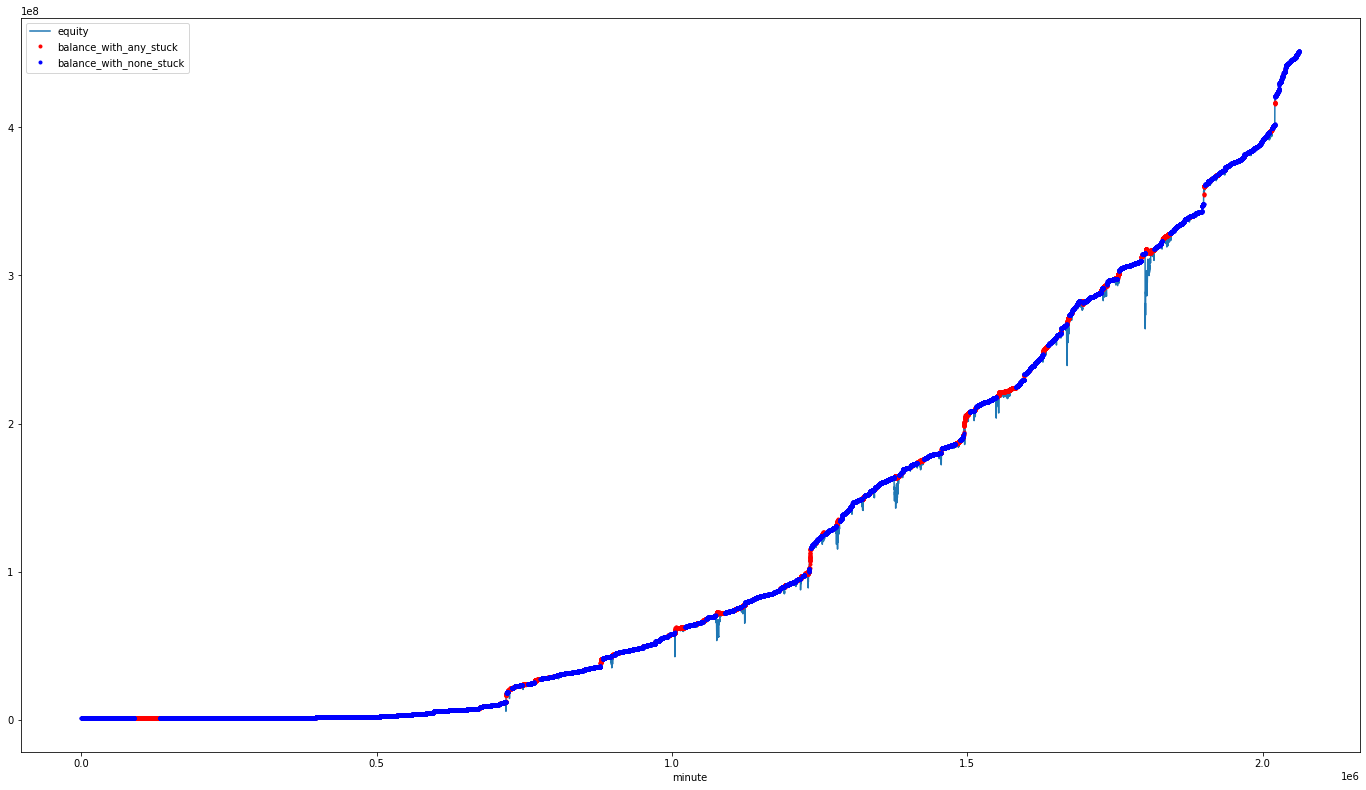

In [18]:
plot_pnls_stuck(sdf, fdf, start_pct=0.0, end_pct=1.0)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

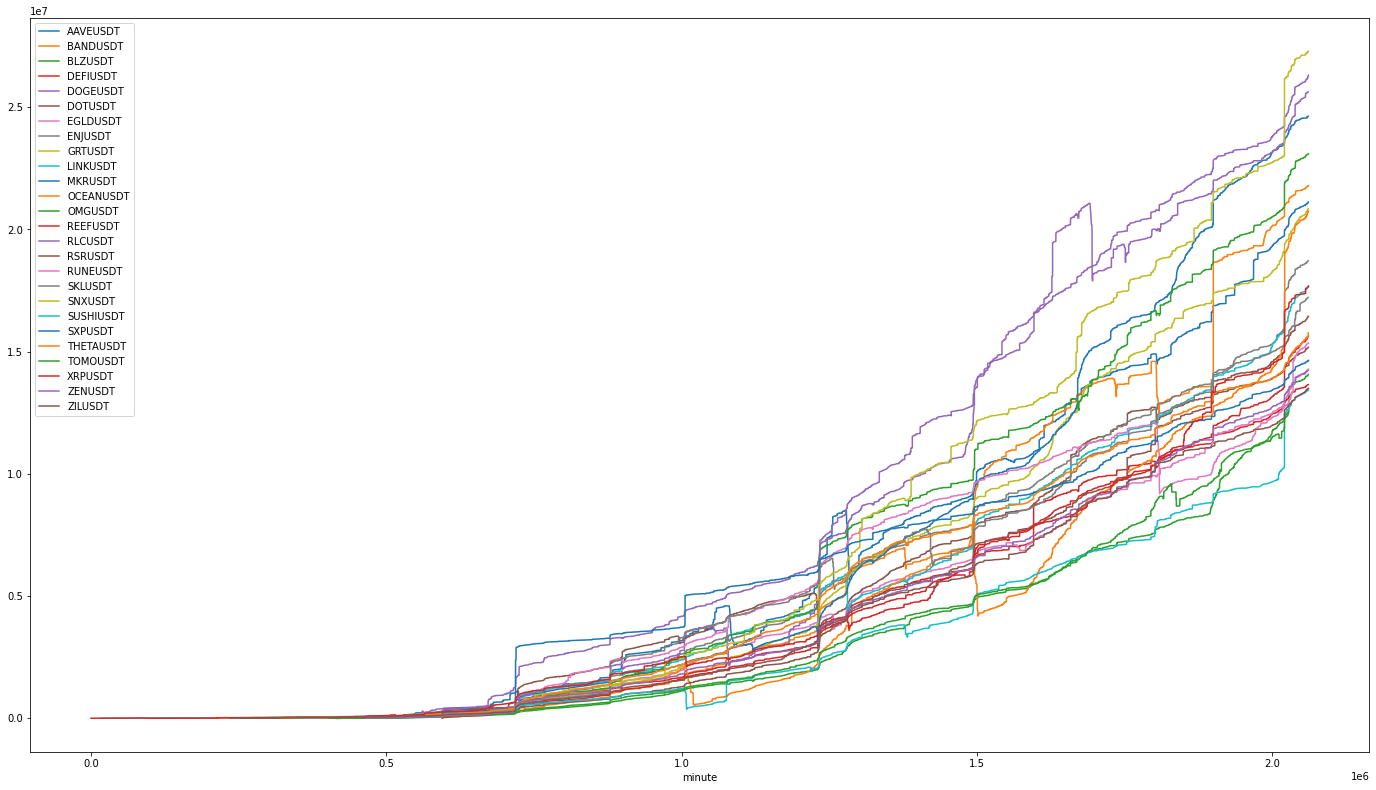

In [19]:
plot_pnls_separate(sdf, fdf)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

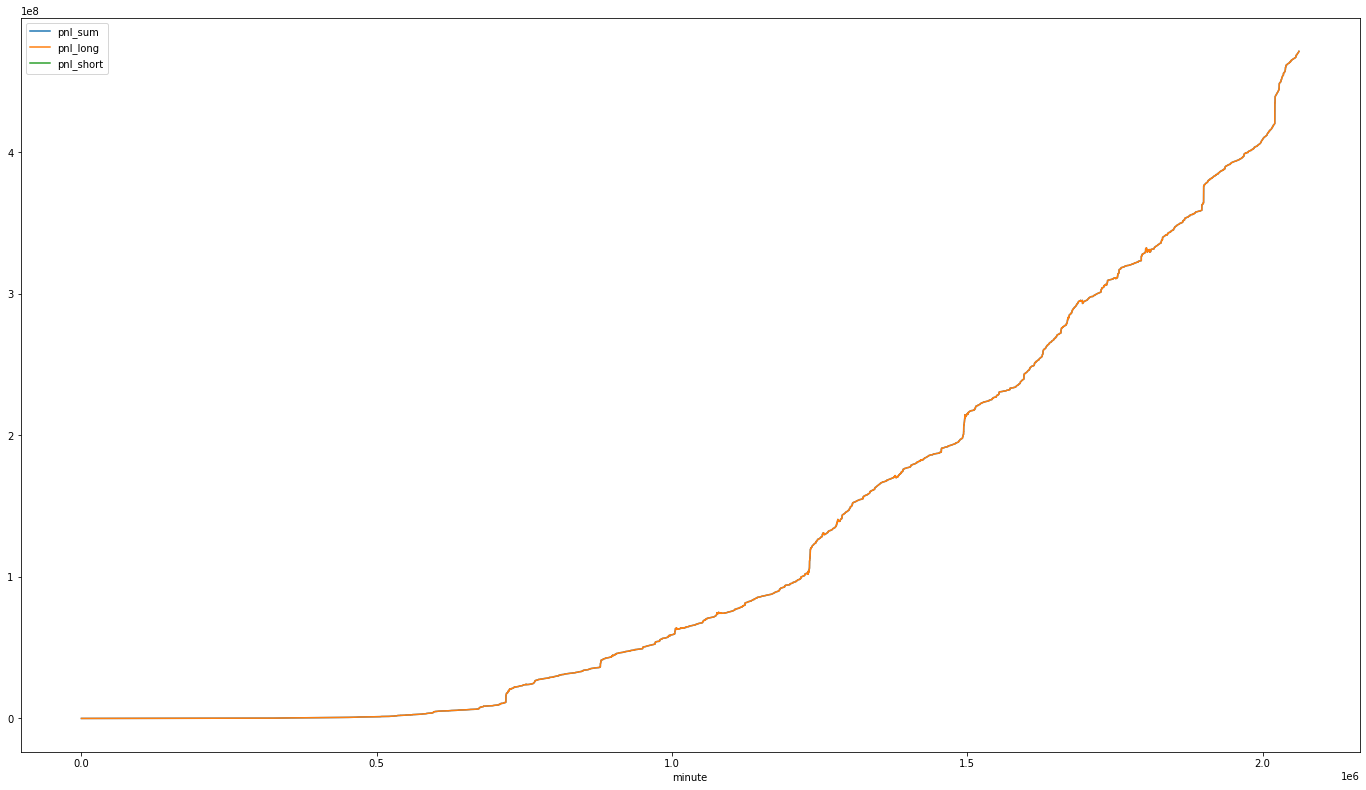

In [20]:
plot_pnls_long_short(sdf, fdf)

<AxesSubplot:xlabel='minute'>

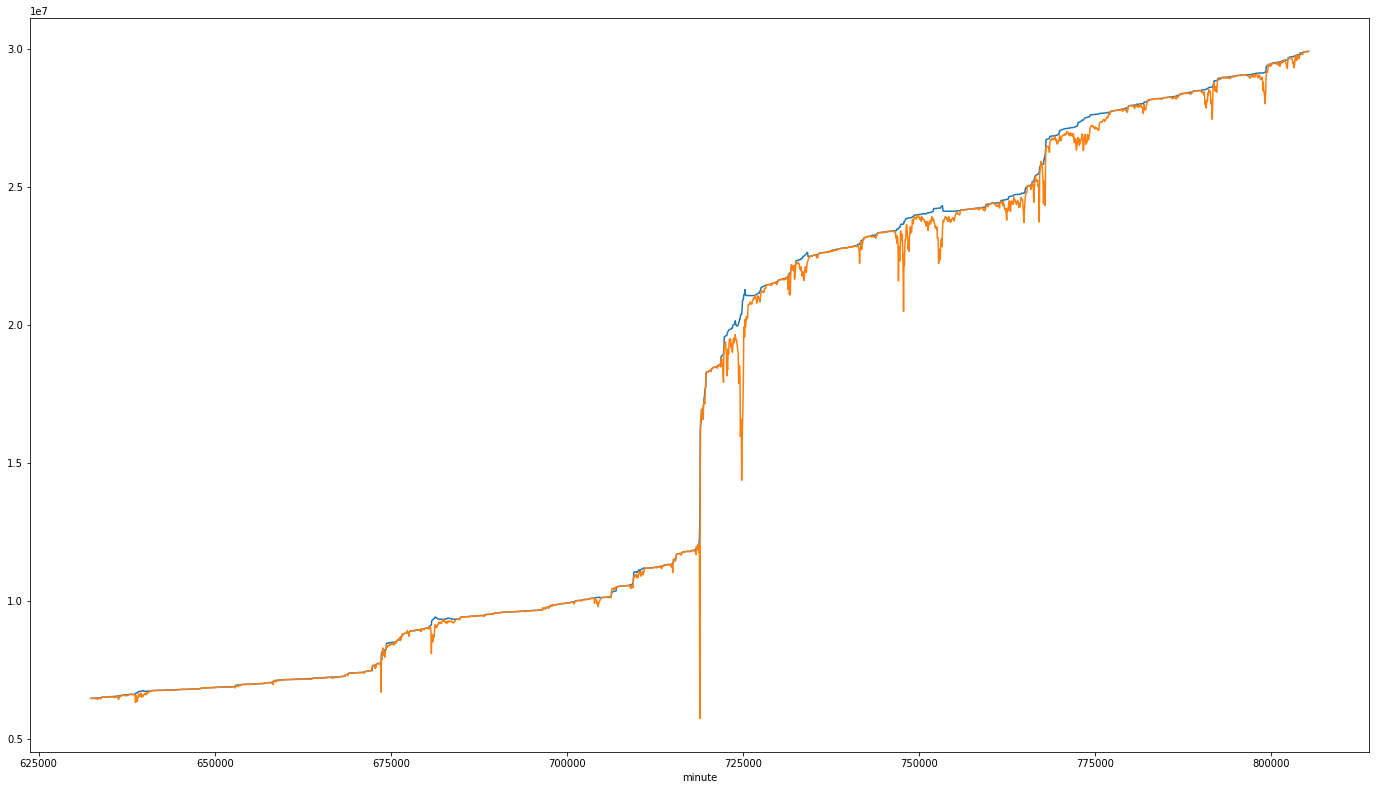

In [21]:
# inspect two months before and two months after location of worst drawdown
drawdowns = calc_drawdowns(sdf.equity)
worst_drawdown_loc = drawdowns.sort_values().iloc[:1].index[0]
wdls = worst_drawdown_loc - 60 * 24 * 30 * 2
wdle = worst_drawdown_loc + 60 * 24 * 30 * 2
sdfc = sdf.loc[wdls:wdle]
sdfc.balance.plot()
sdfc.equity.plot()

AAVEUSDT


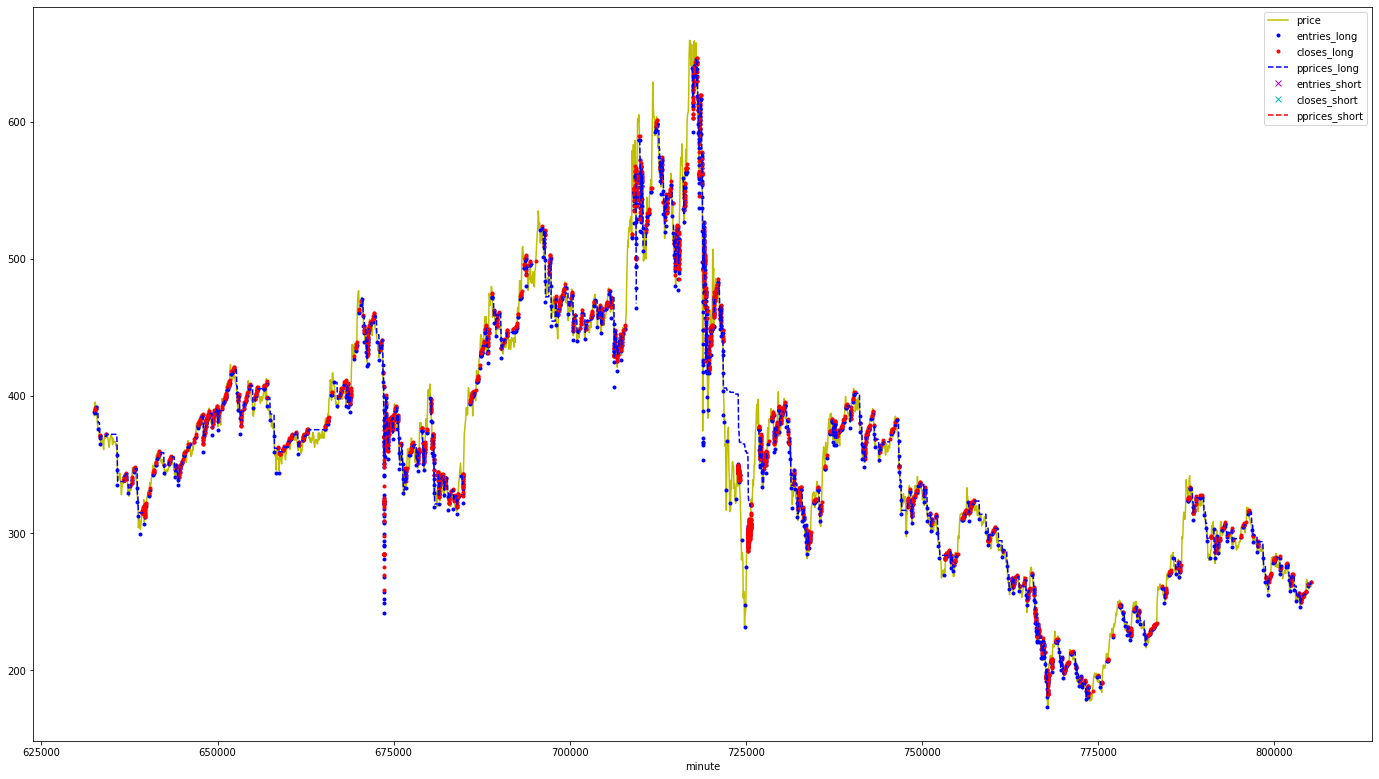

BANDUSDT


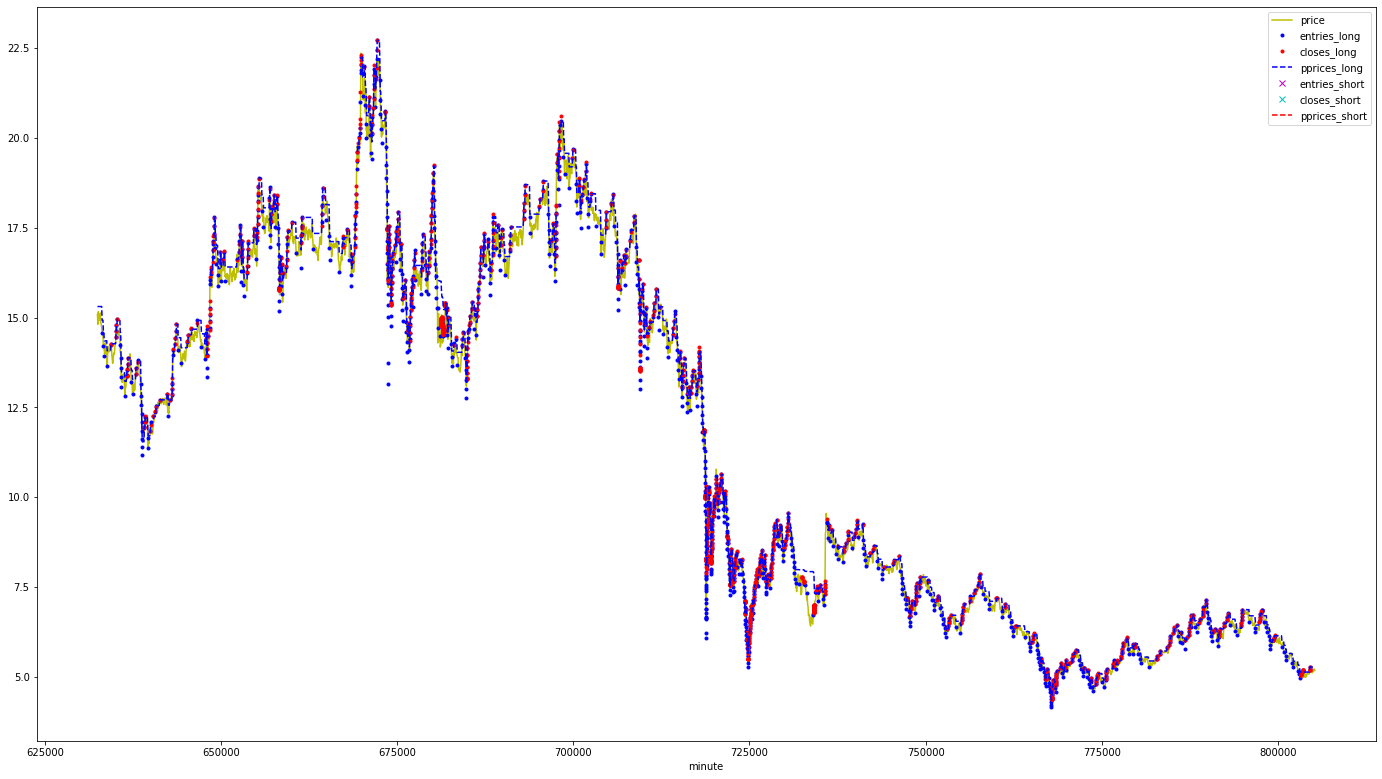

BLZUSDT


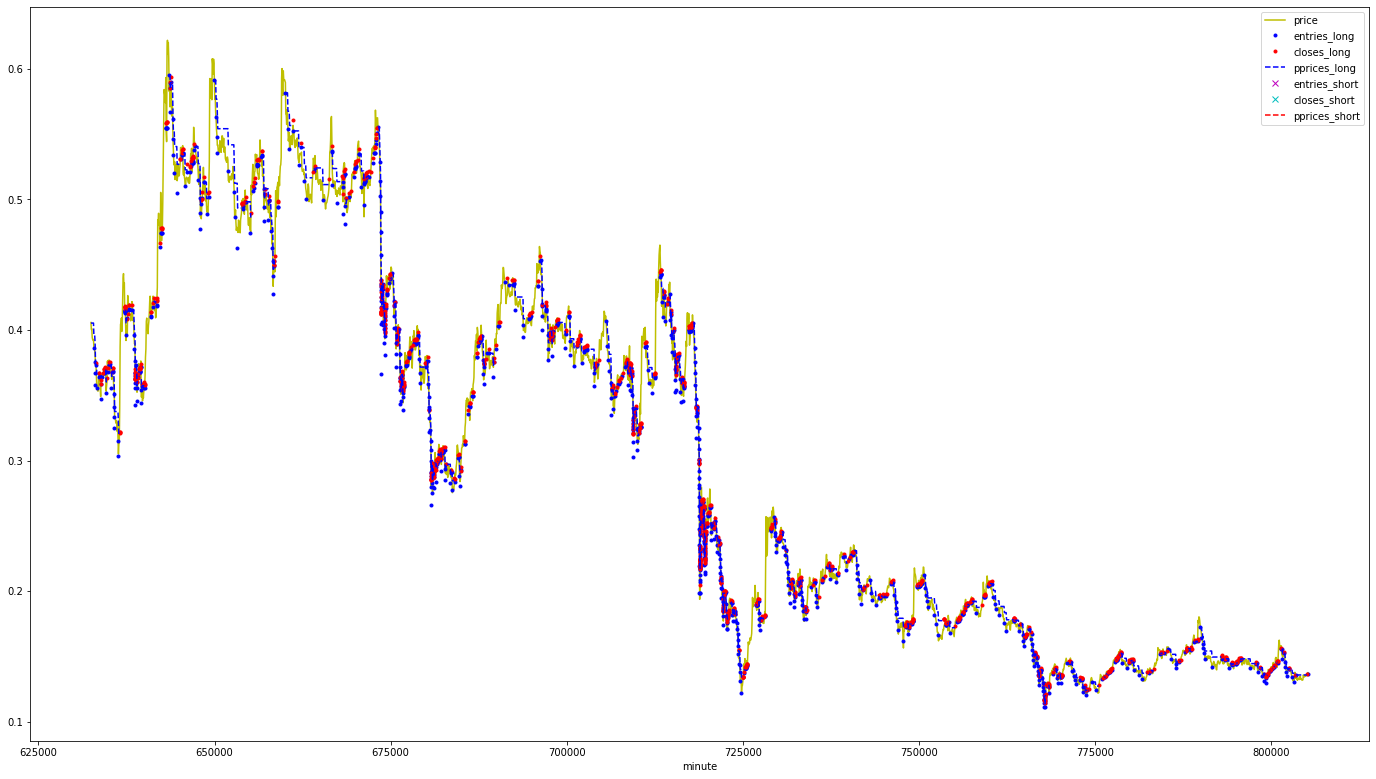

DEFIUSDT


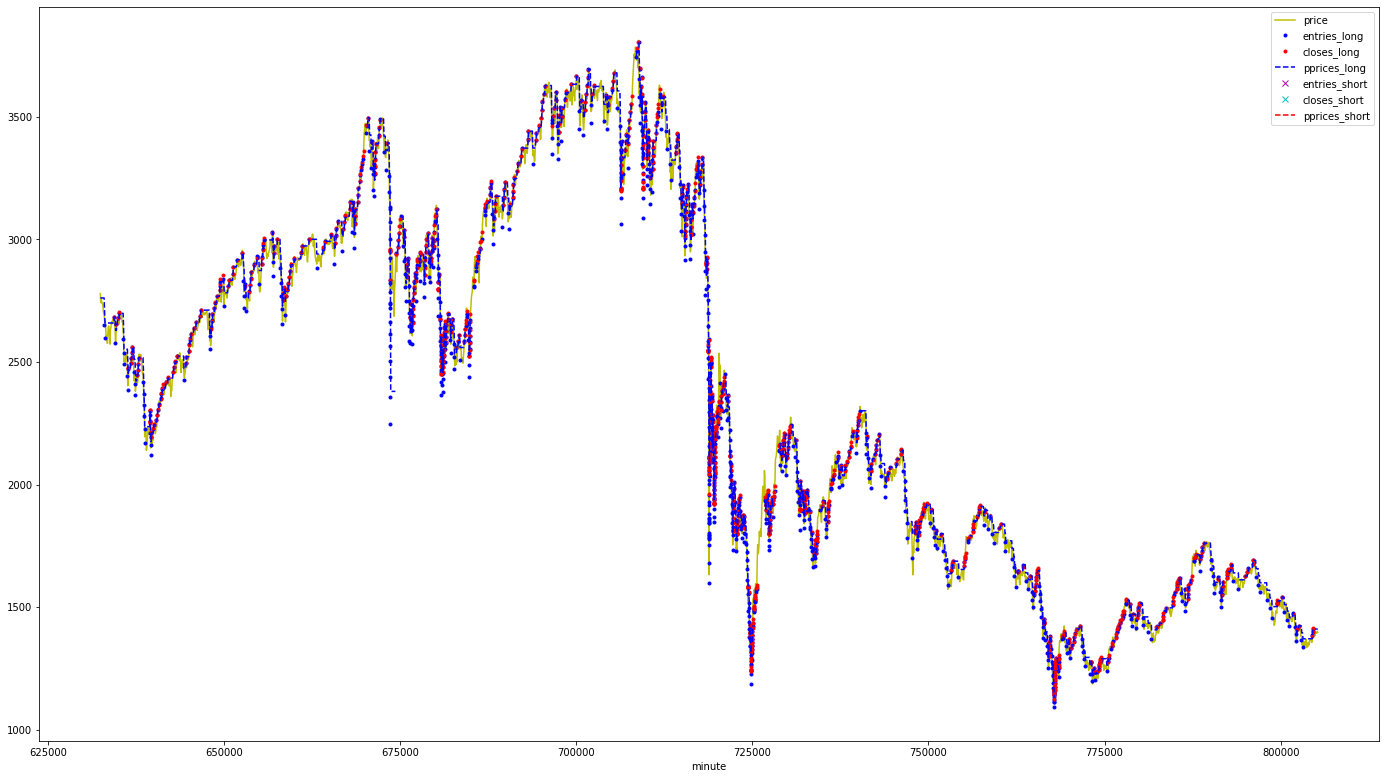

DOGEUSDT


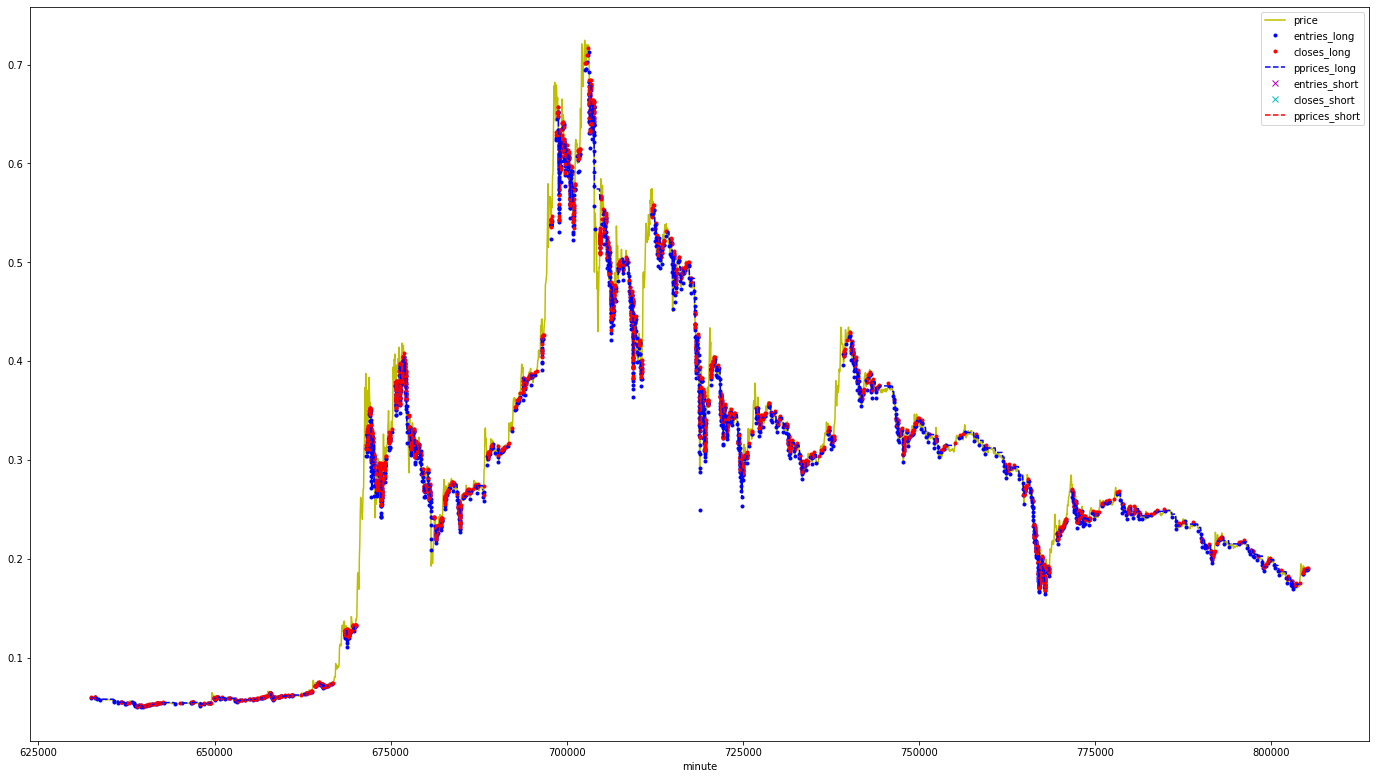

DOTUSDT


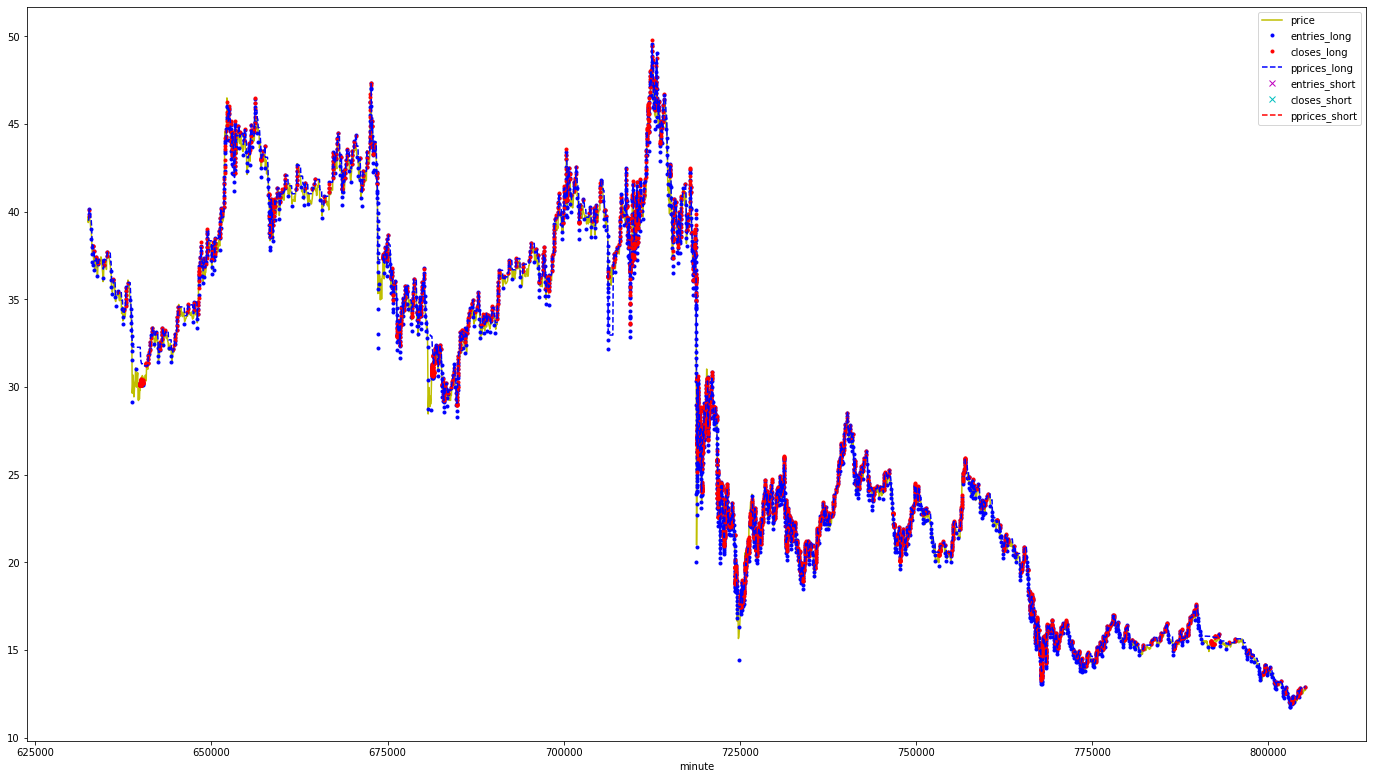

EGLDUSDT


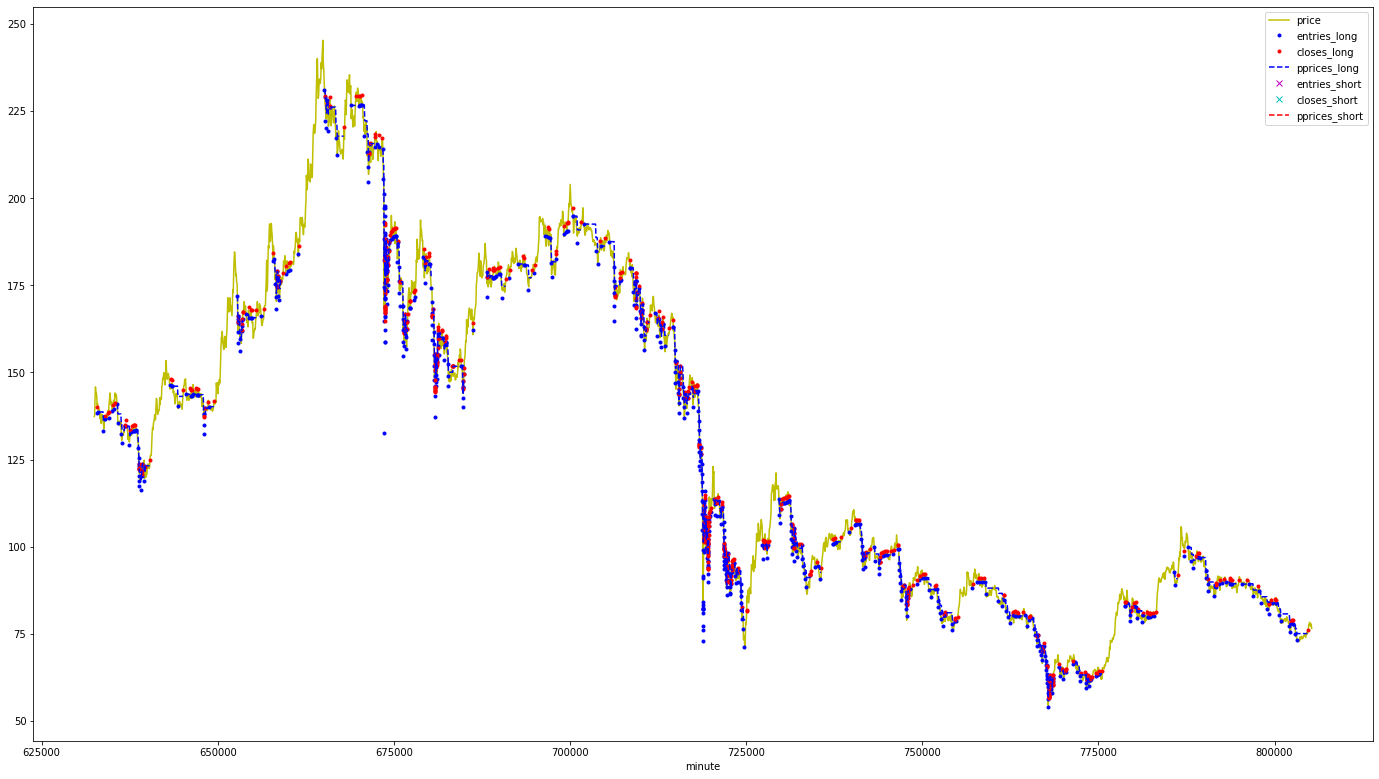

ENJUSDT


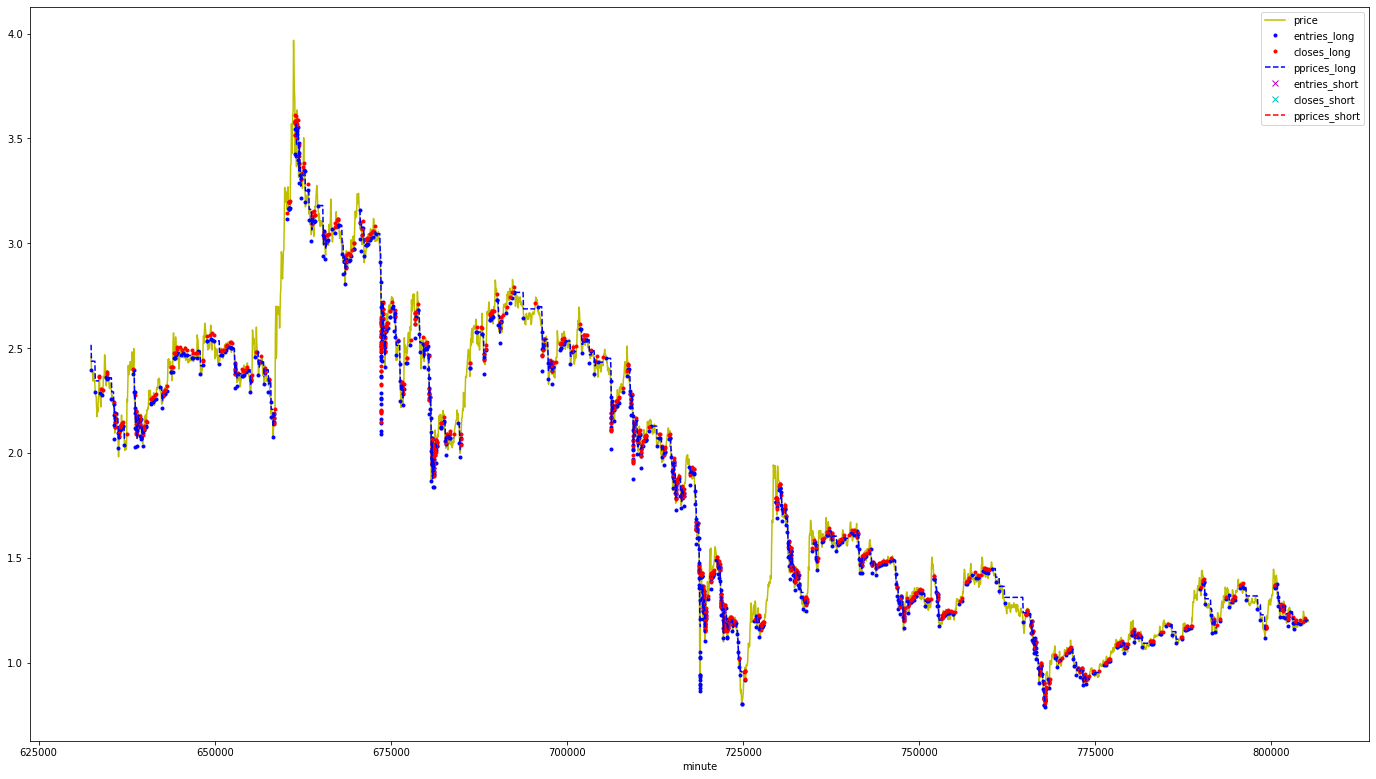

GRTUSDT


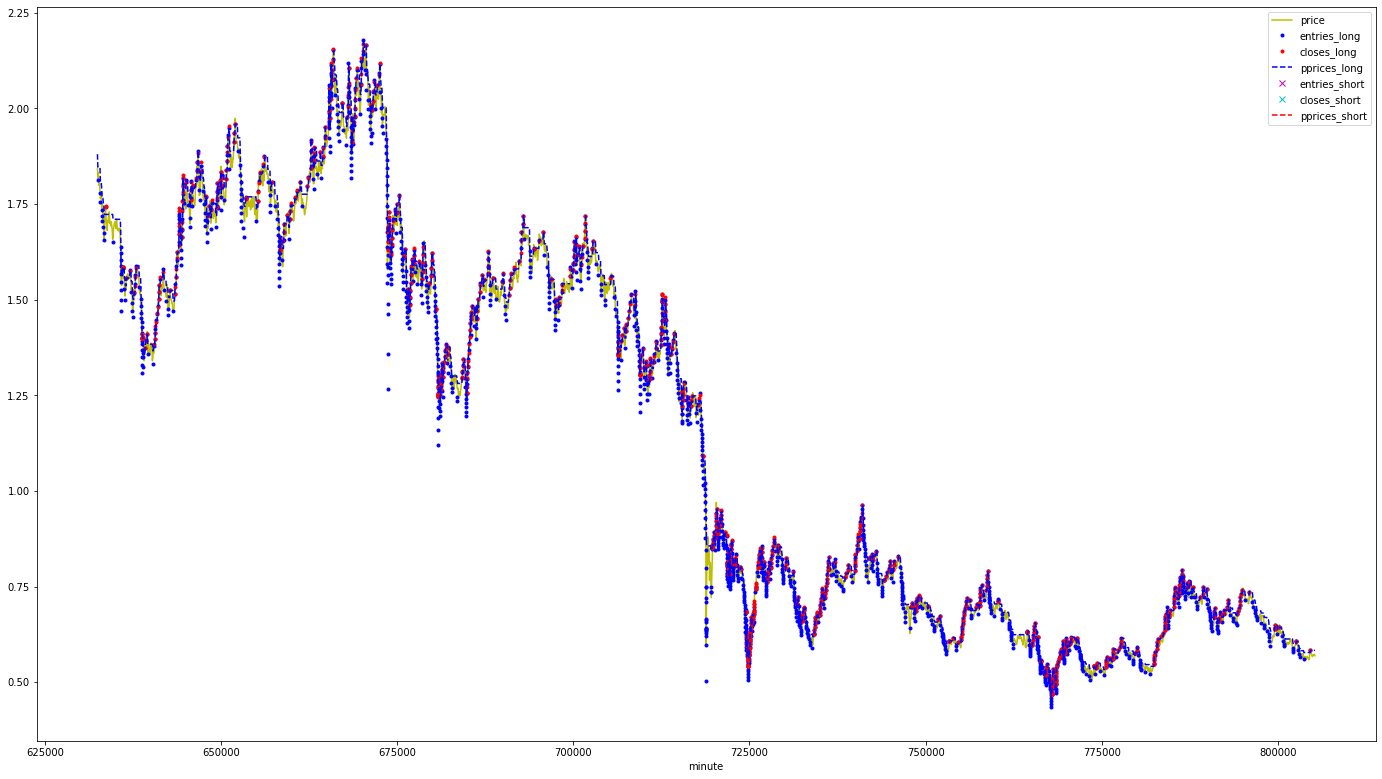

LINKUSDT


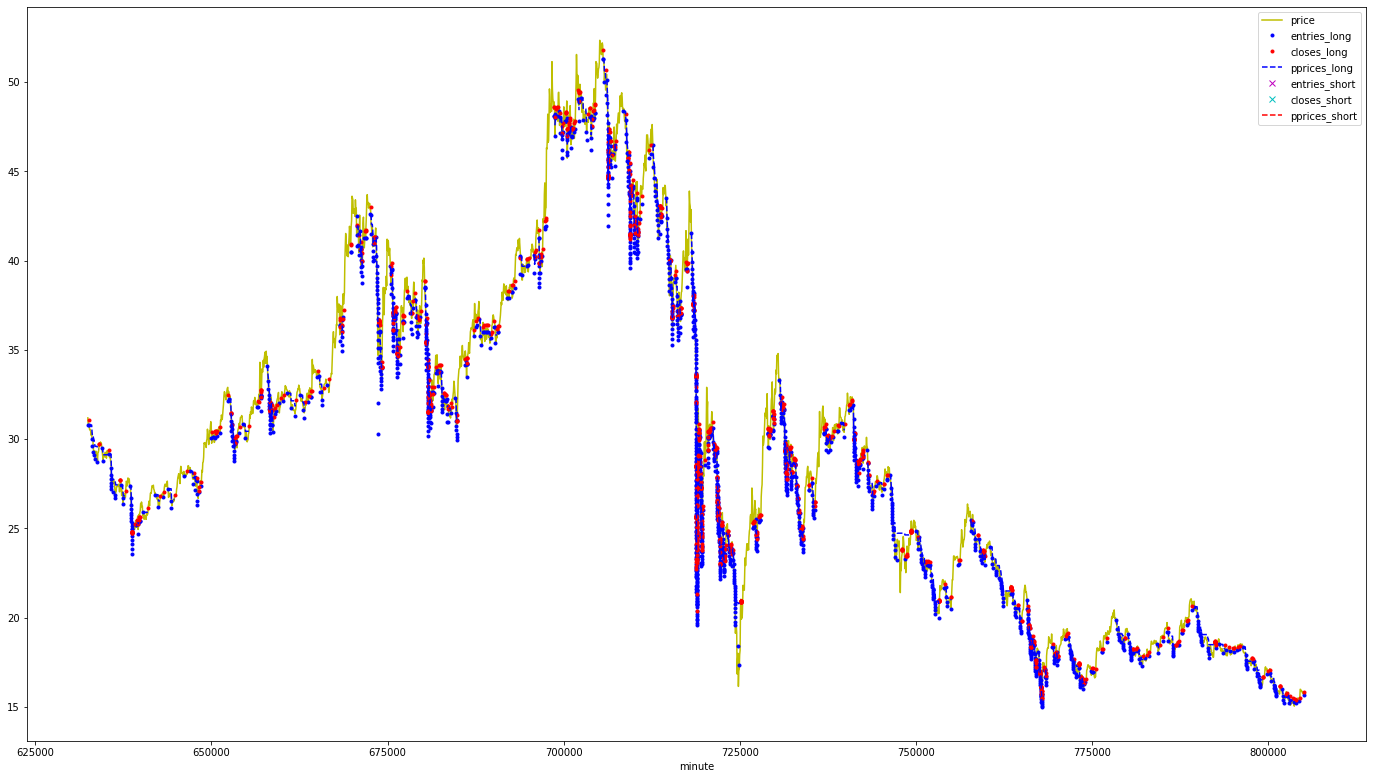

MKRUSDT


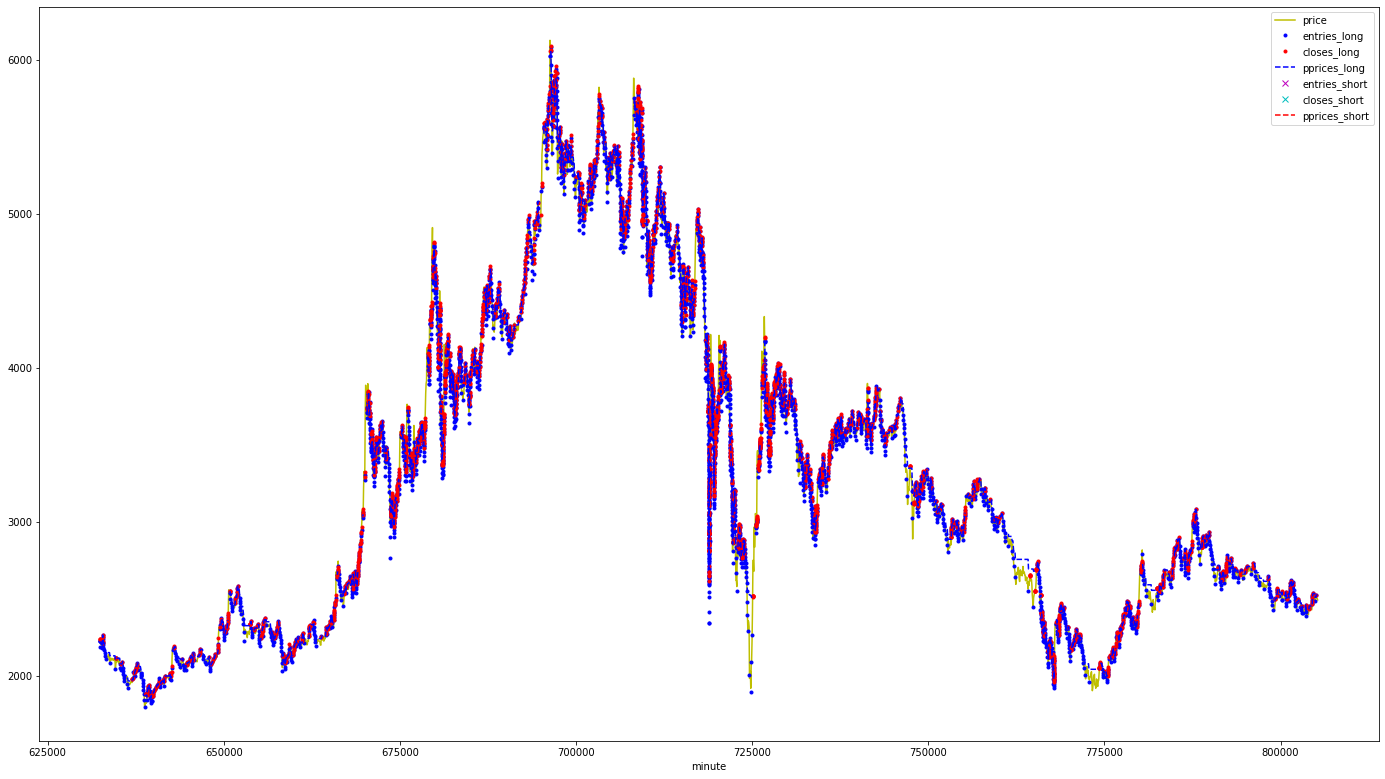

OCEANUSDT


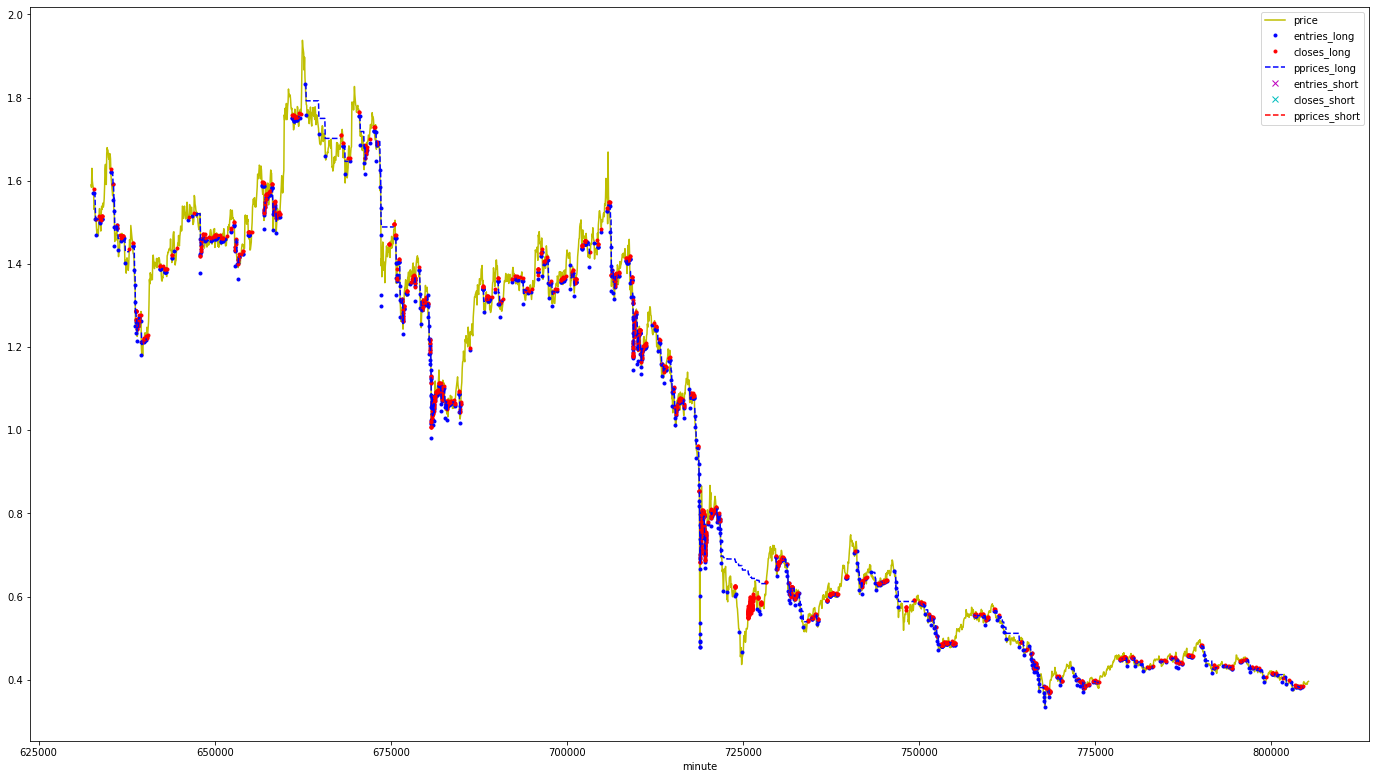

OMGUSDT


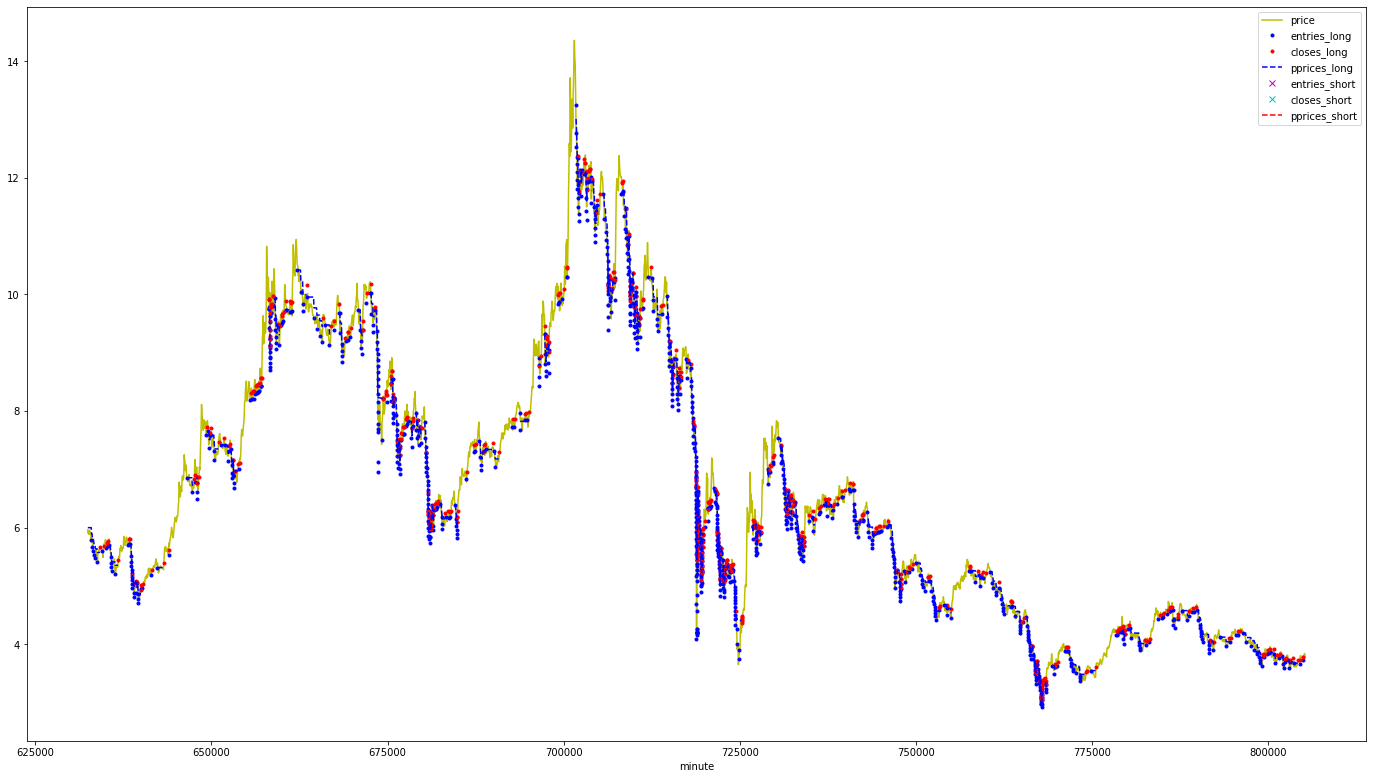

REEFUSDT


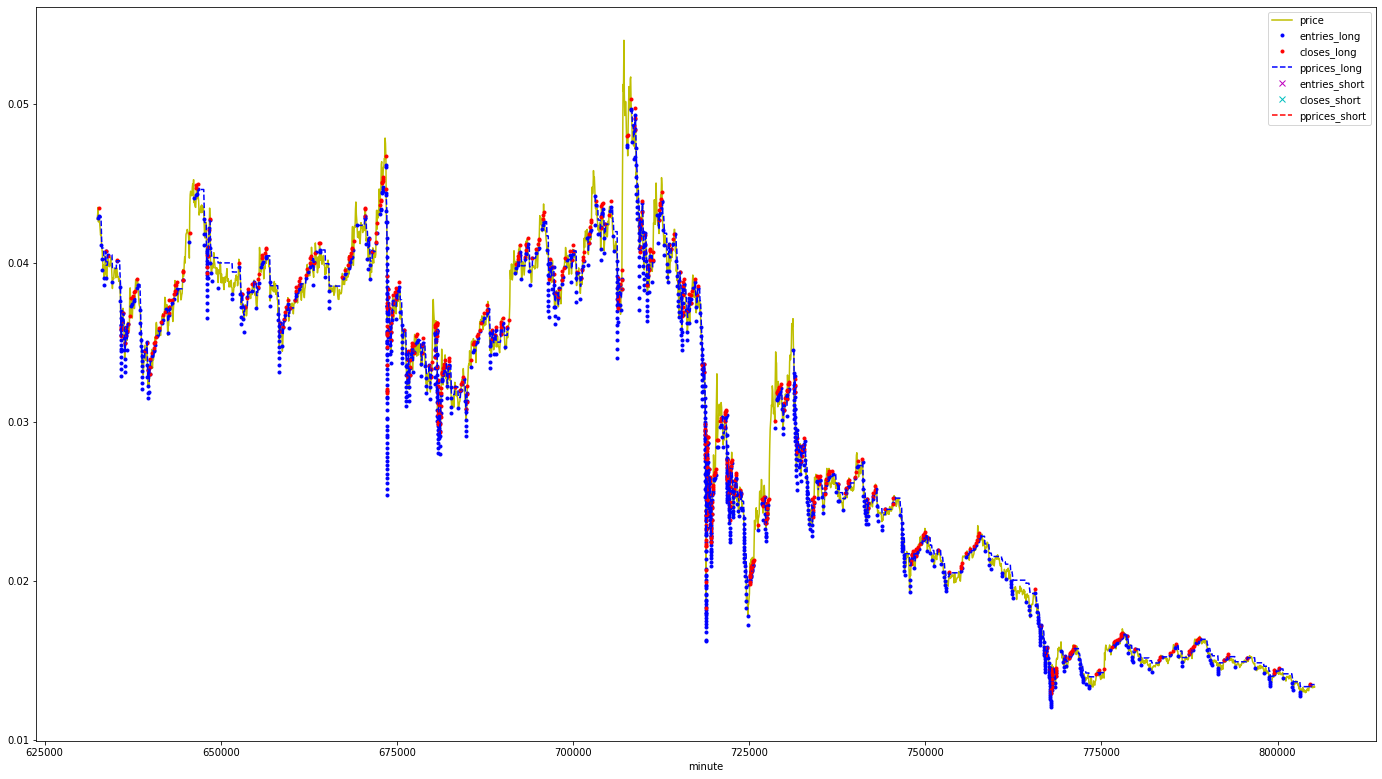

RLCUSDT


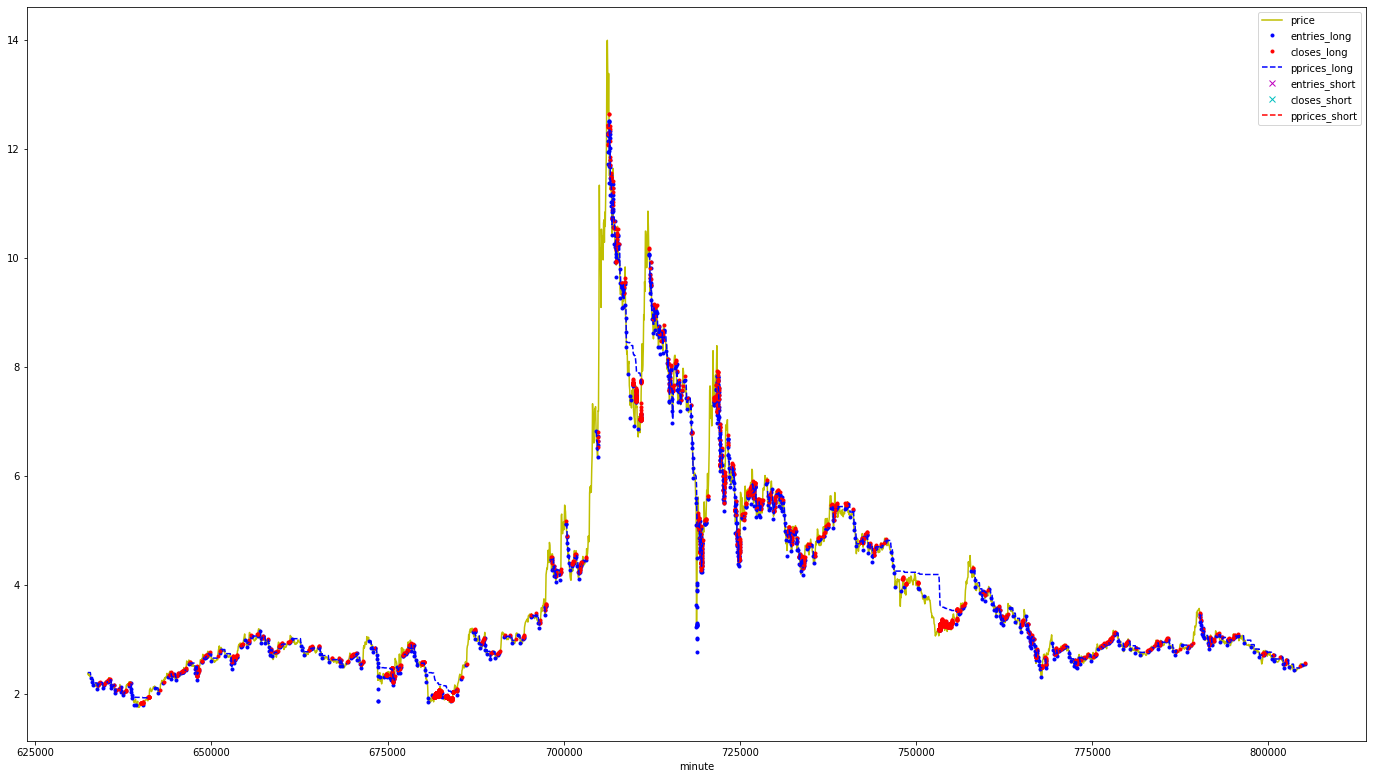

RSRUSDT


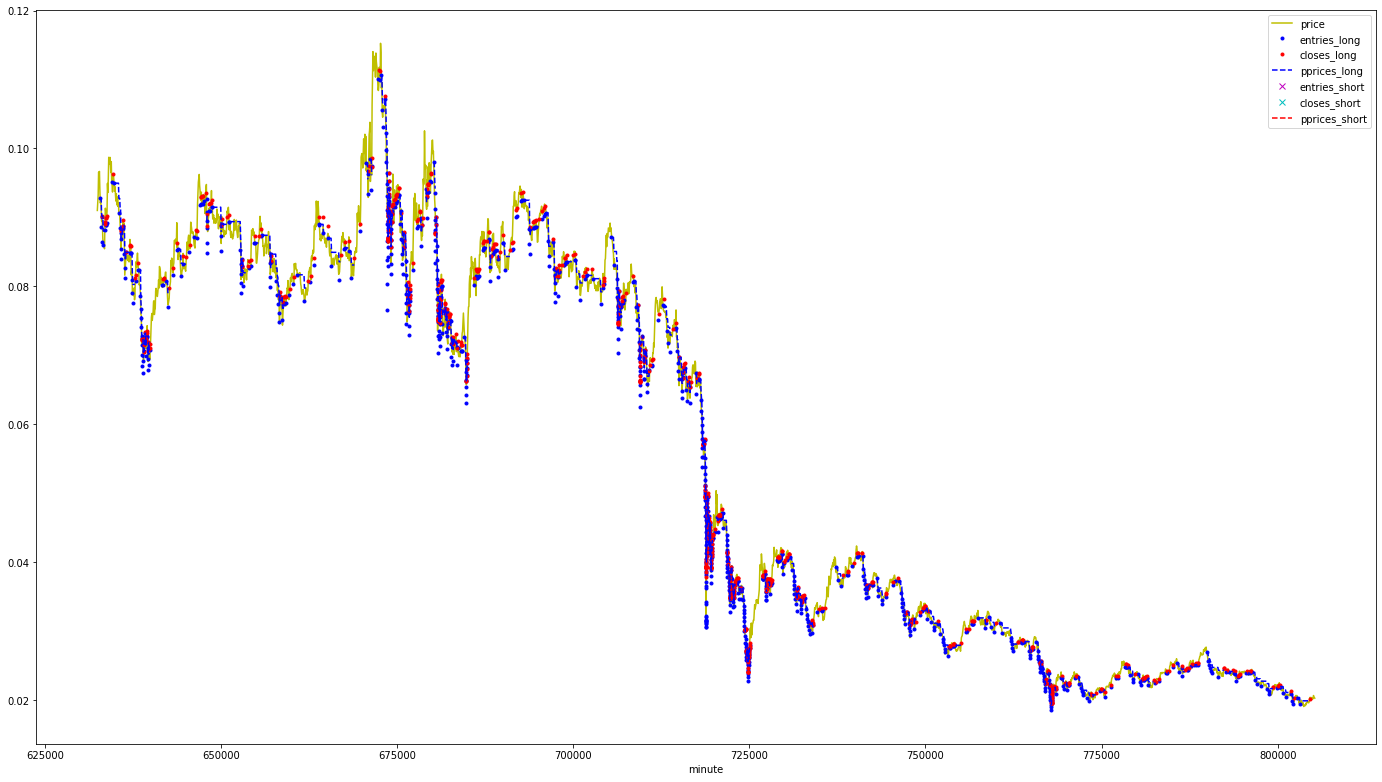

RUNEUSDT


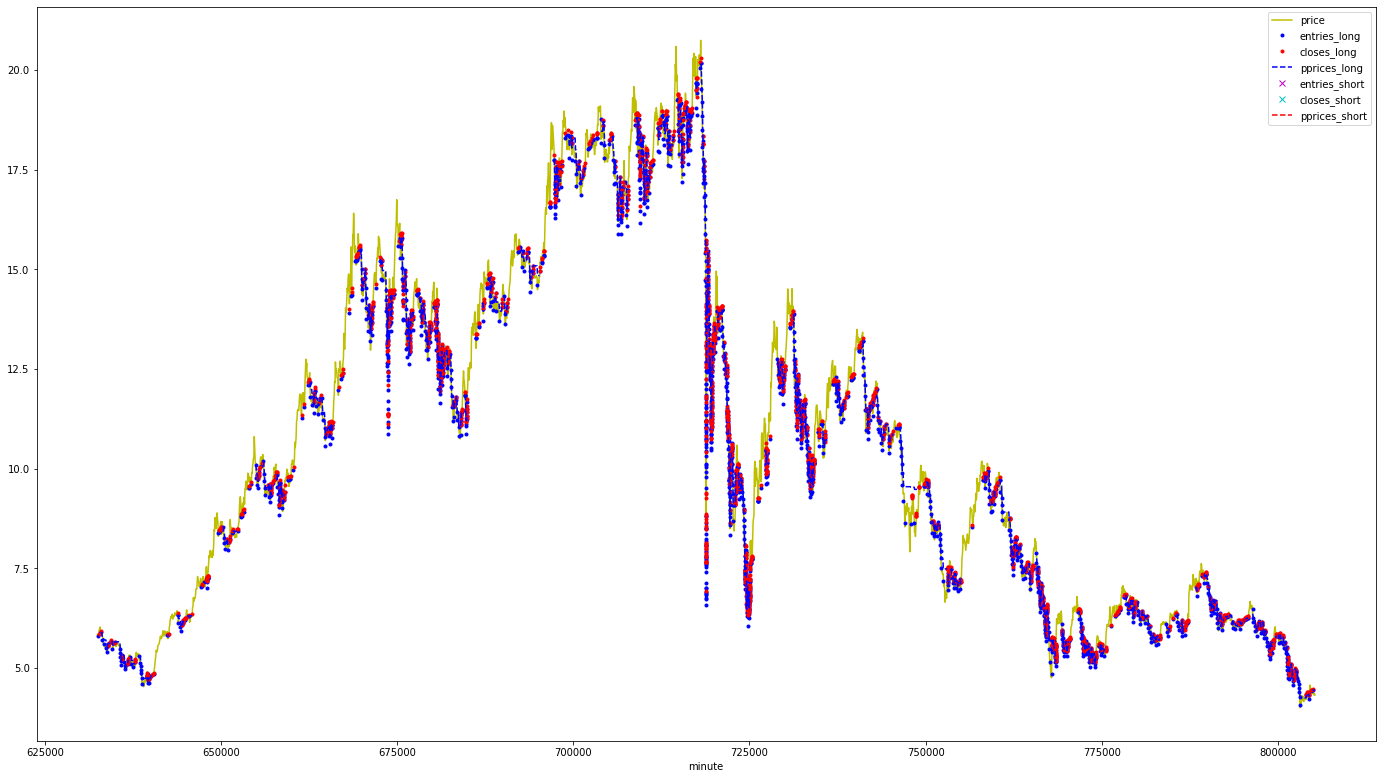

SKLUSDT


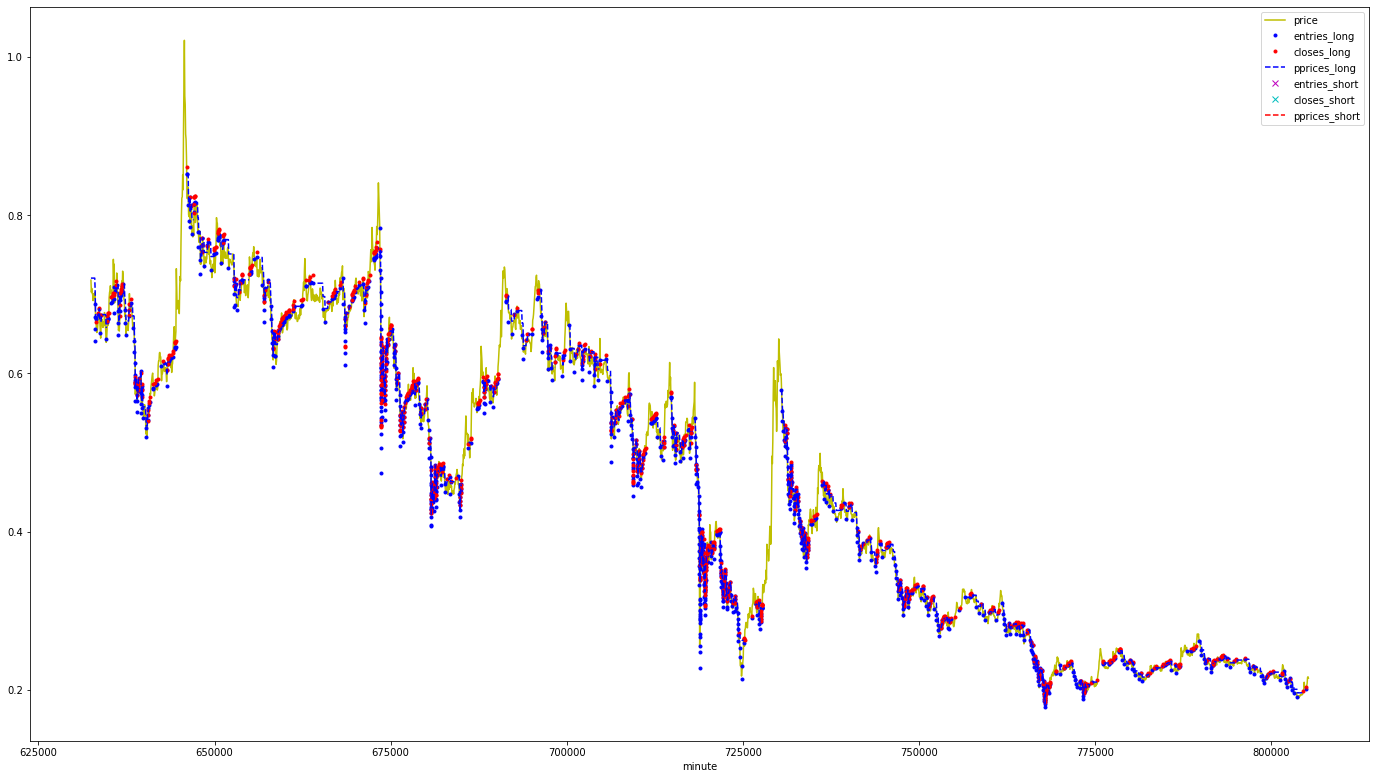

SNXUSDT


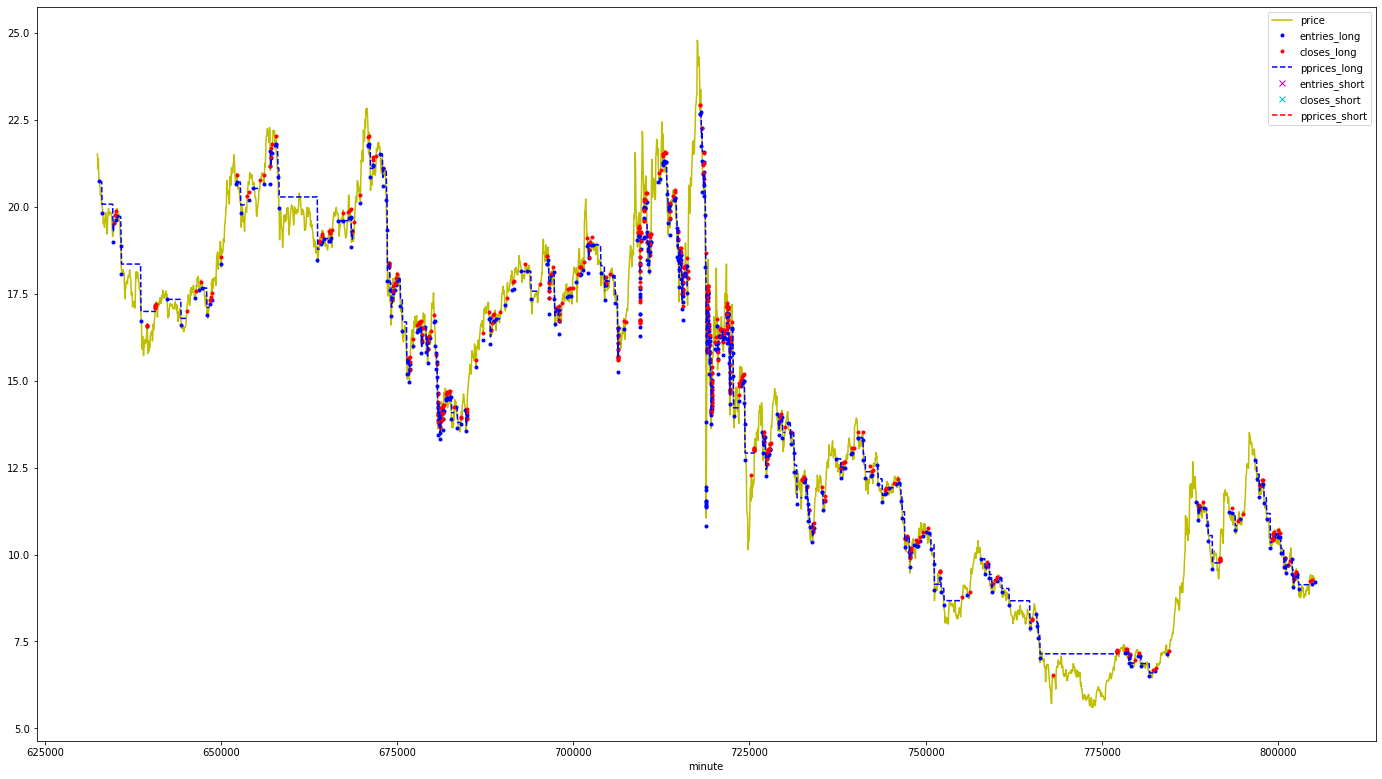

SUSHIUSDT


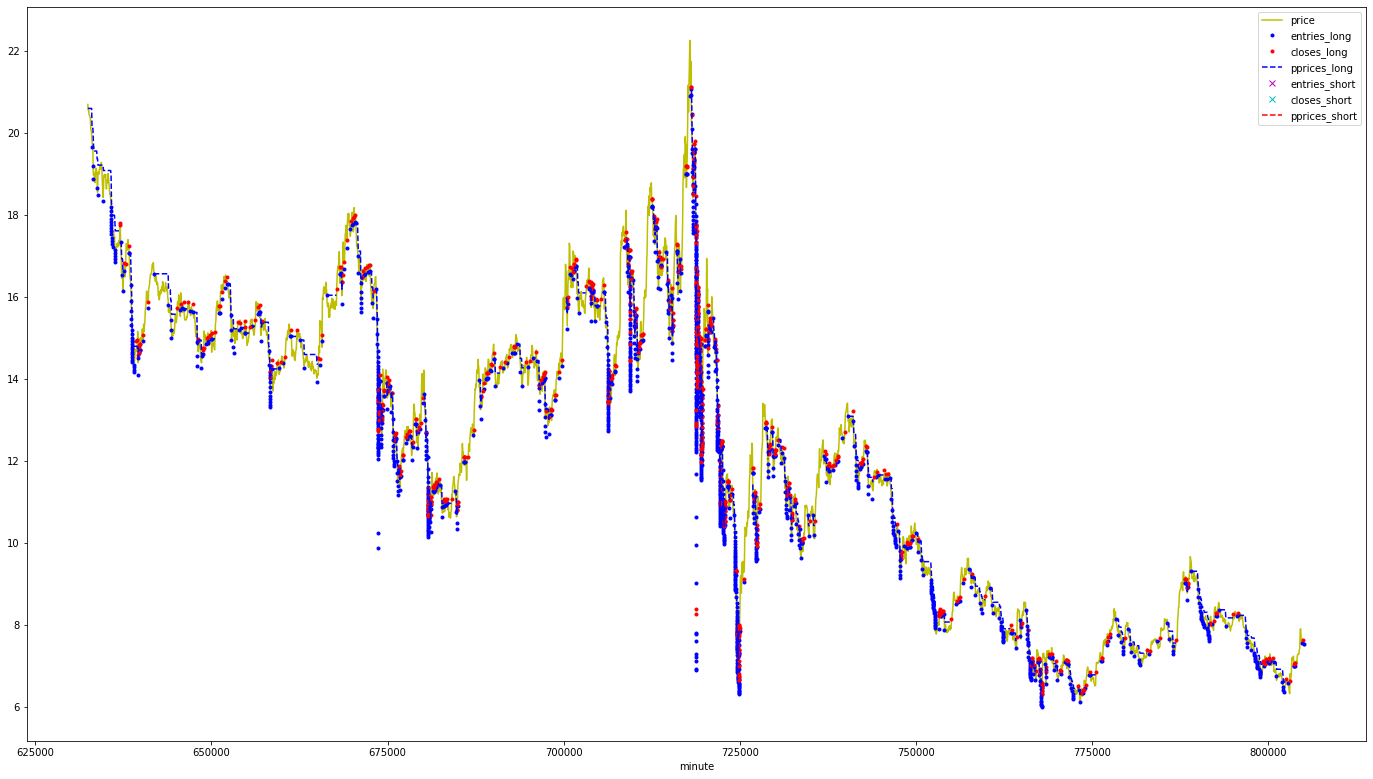

SXPUSDT


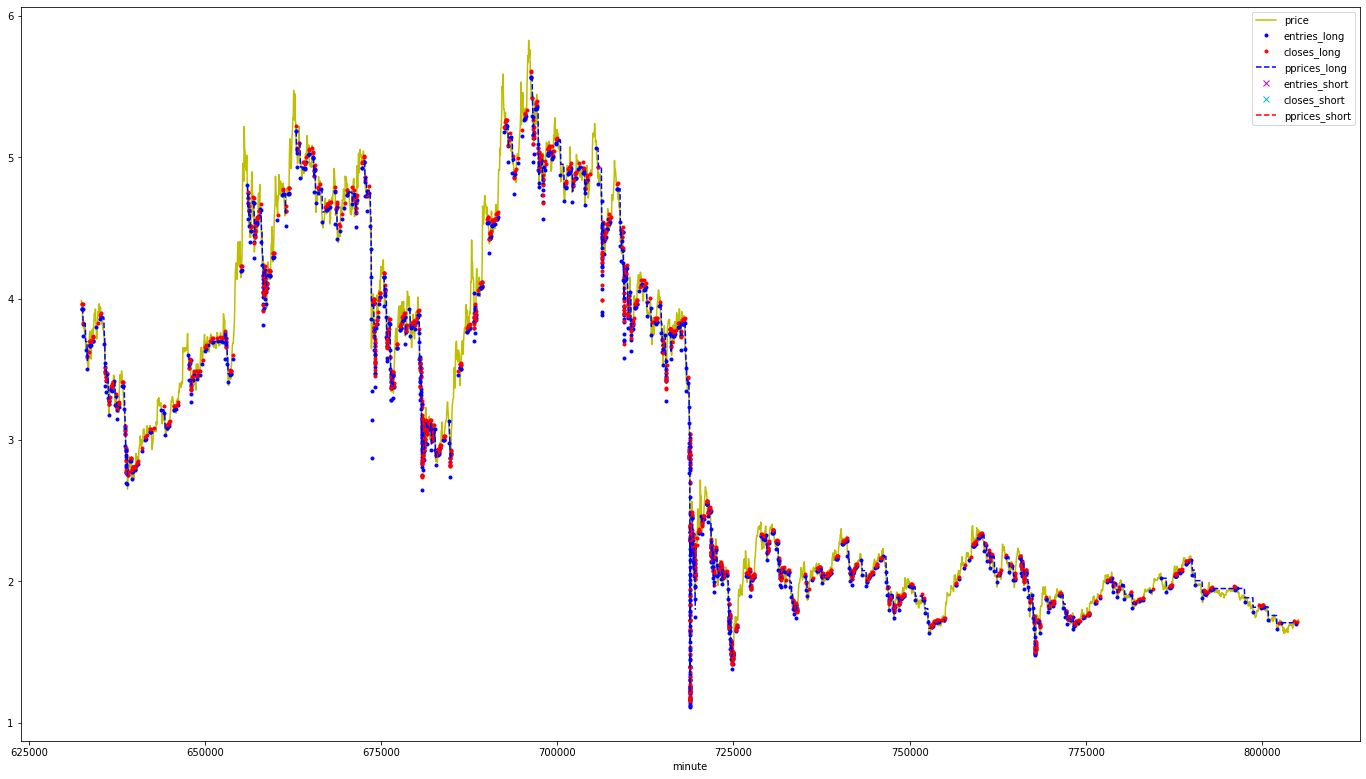

THETAUSDT


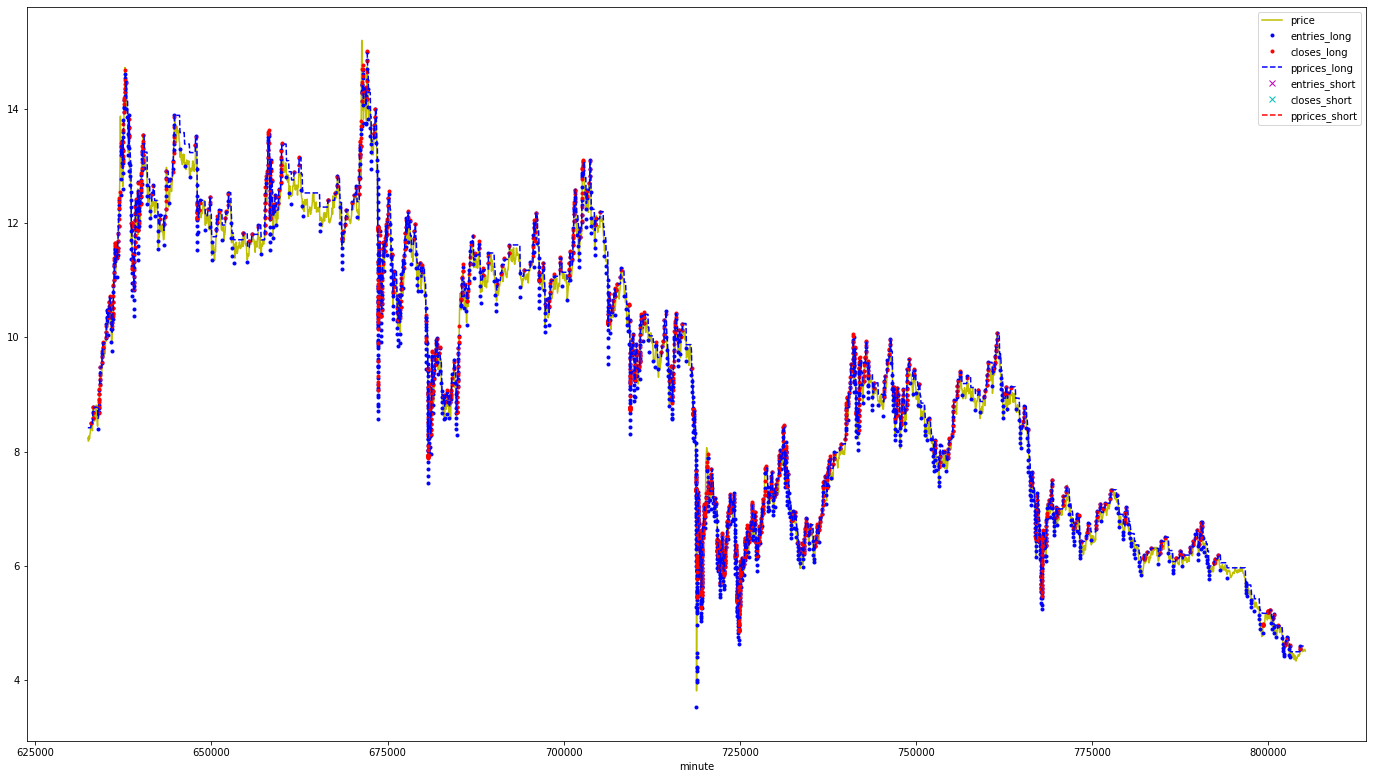

TOMOUSDT


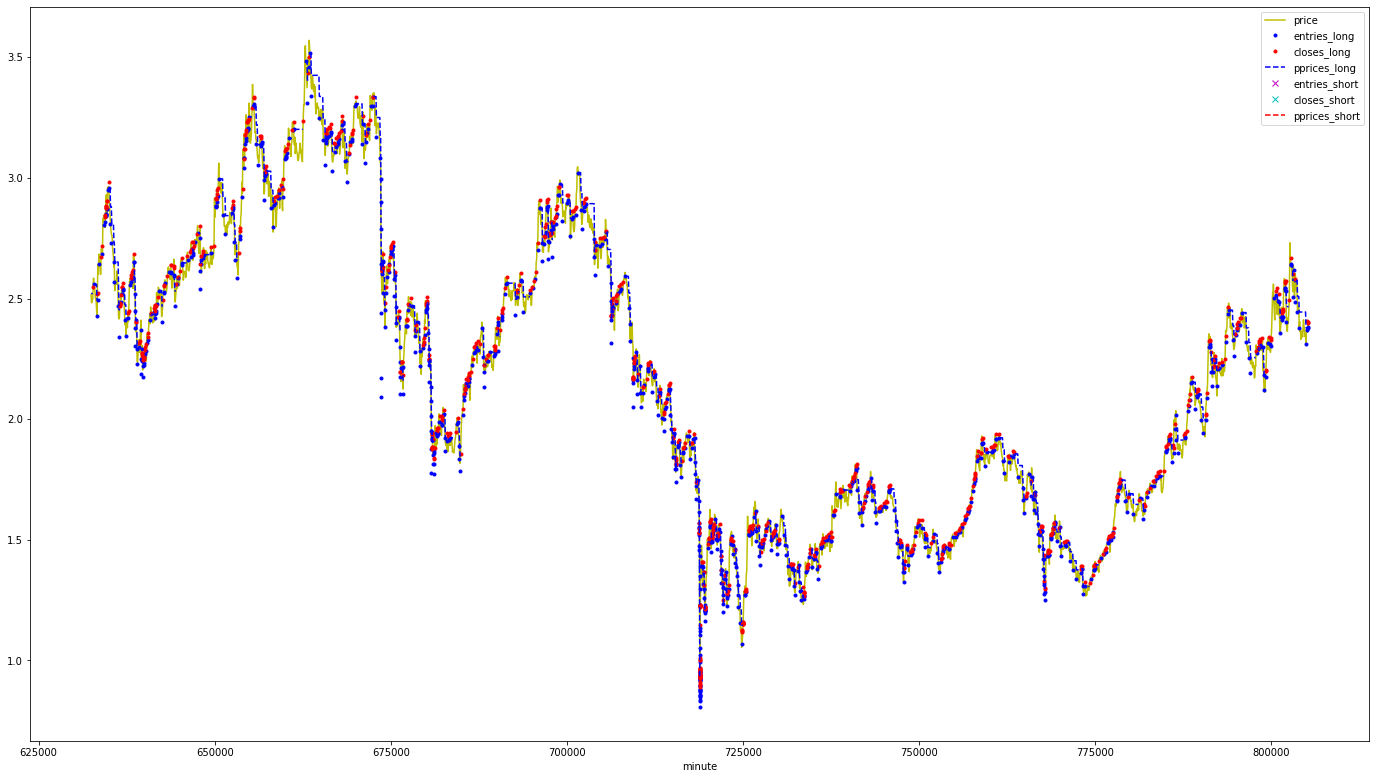

XRPUSDT


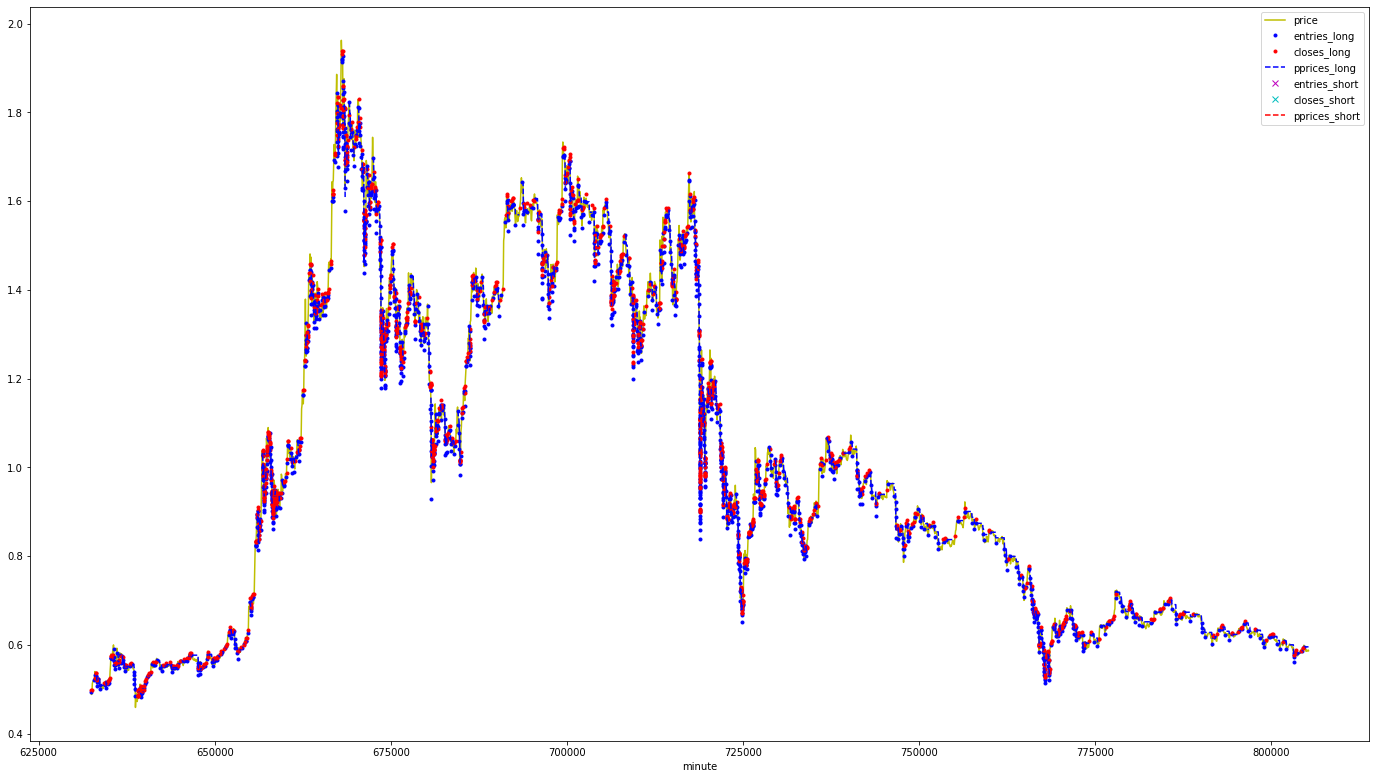

ZENUSDT


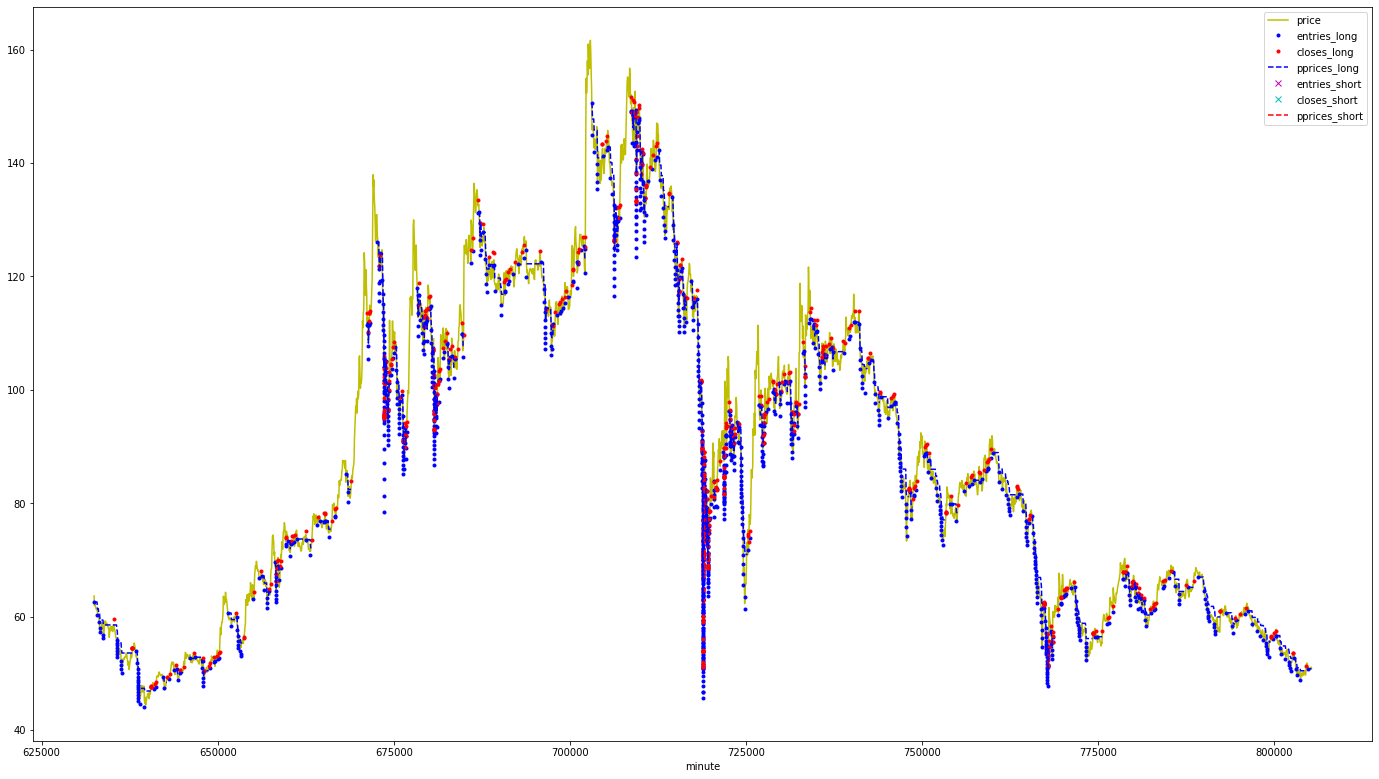

ZILUSDT


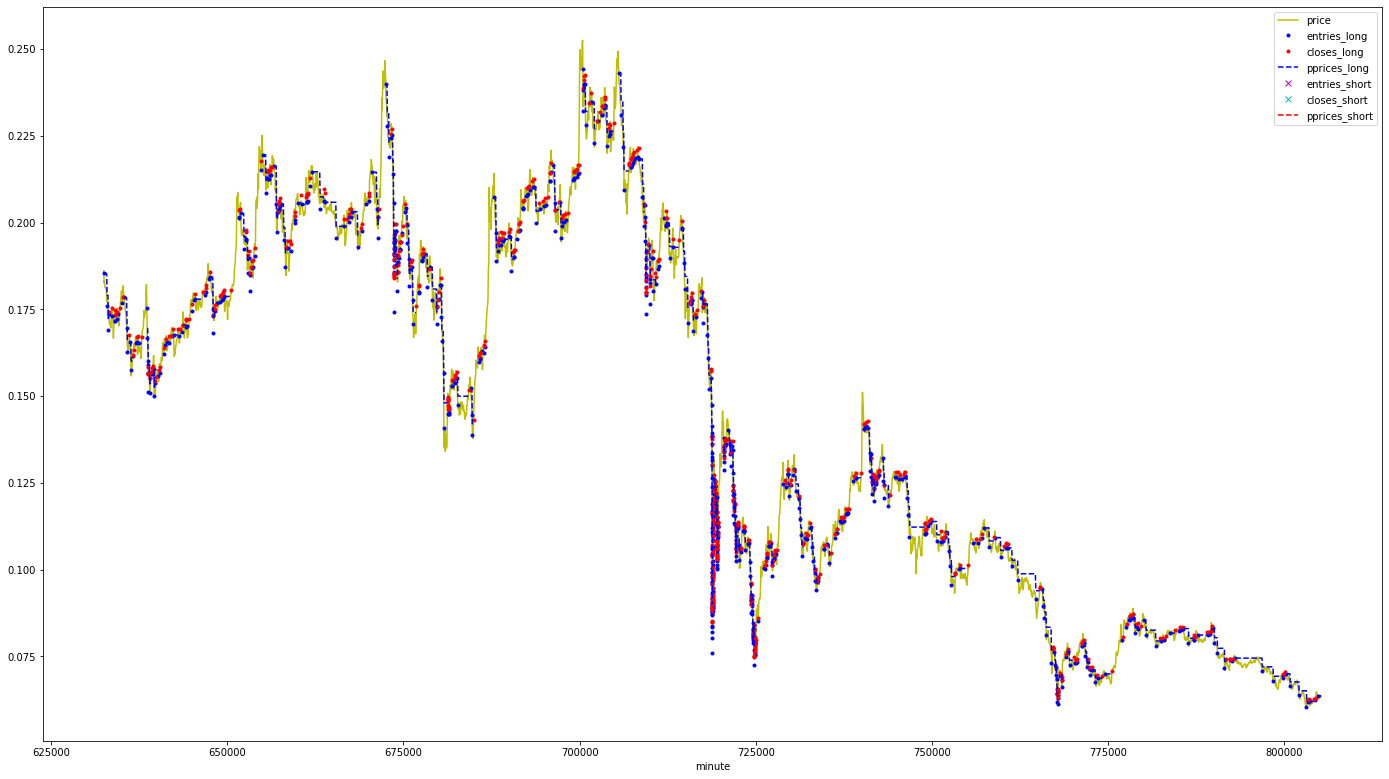

In [22]:
# inspect for each symbol
for symbol in symbols:
    print(symbol)
    plot_fills_multi(symbol, sdf.loc[wdls:wdle], fdf.loc[wdls:wdle]).show()

LINKUSDT_upnl_pct_l    -0.0579016693
DOGEUSDT_upnl_pct_l    -0.0554424480
XRPUSDT_upnl_pct_l     -0.0524513987
RLCUSDT_upnl_pct_l     -0.0509686732
THETAUSDT_upnl_pct_l   -0.0457880164
AAVEUSDT_upnl_pct_l    -0.0420555927
OCEANUSDT_upnl_pct_l   -0.0417717271
GRTUSDT_upnl_pct_l     -0.0411559331
SNXUSDT_upnl_pct_l     -0.0404387067
DOTUSDT_upnl_pct_l     -0.0362650372
ENJUSDT_upnl_pct_l     -0.0345079768
OMGUSDT_upnl_pct_l     -0.0330680144
SKLUSDT_upnl_pct_l     -0.0320787830
RSRUSDT_upnl_pct_l     -0.0286124415
DEFIUSDT_upnl_pct_l    -0.0281526326
SUSHIUSDT_upnl_pct_l   -0.0280122177
EGLDUSDT_upnl_pct_l    -0.0278686134
MKRUSDT_upnl_pct_l     -0.0277169124
REEFUSDT_upnl_pct_l    -0.0264006258
BANDUSDT_upnl_pct_l    -0.0255130567
ZENUSDT_upnl_pct_l     -0.0243807728
RUNEUSDT_upnl_pct_l    -0.0227482955
BLZUSDT_upnl_pct_l     -0.0200997355
ZILUSDT_upnl_pct_l     -0.0190692626
TOMOUSDT_upnl_pct_l    -0.0181908512
SXPUSDT_upnl_pct_l     -0.0179921537
AAVEUSDT_upnl_pct_s              NaN
B

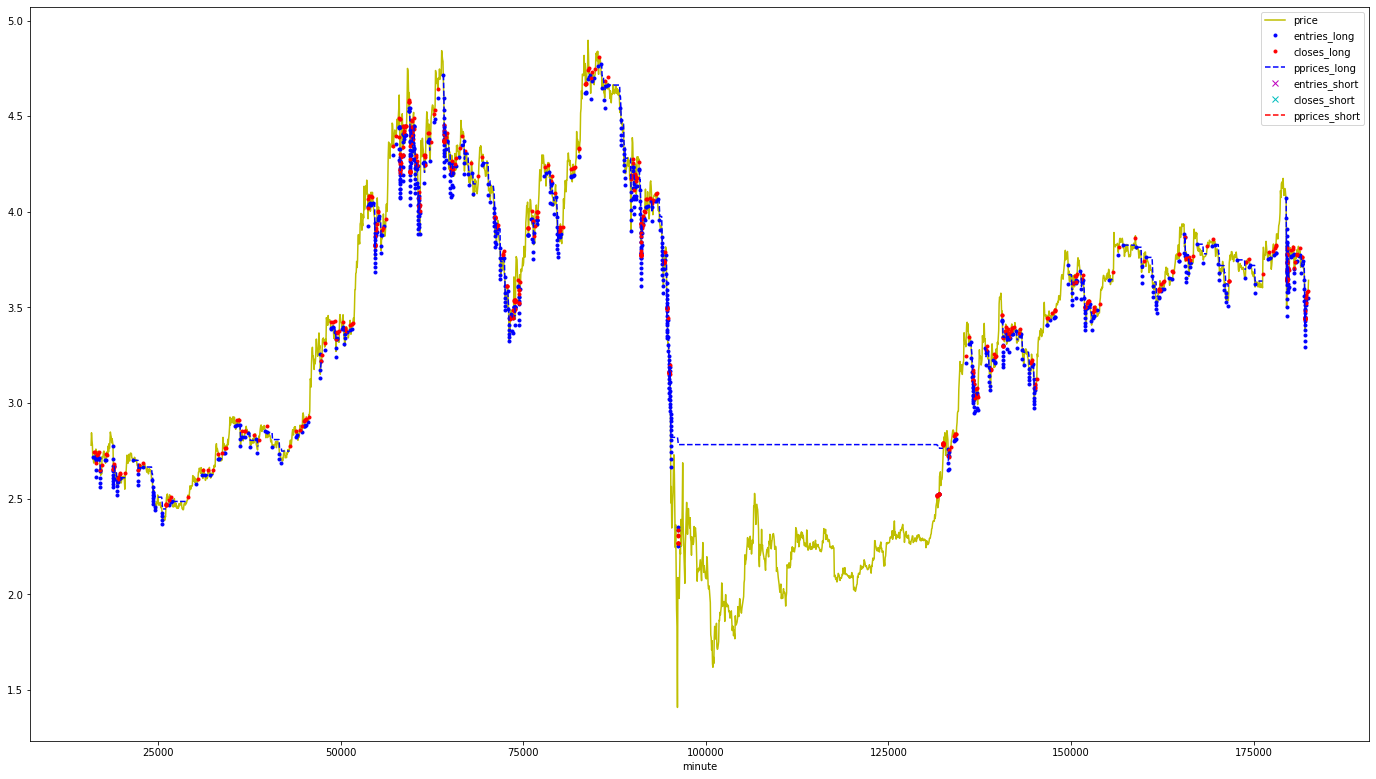

DOGEUSDT_upnl_pct_l 562320.0


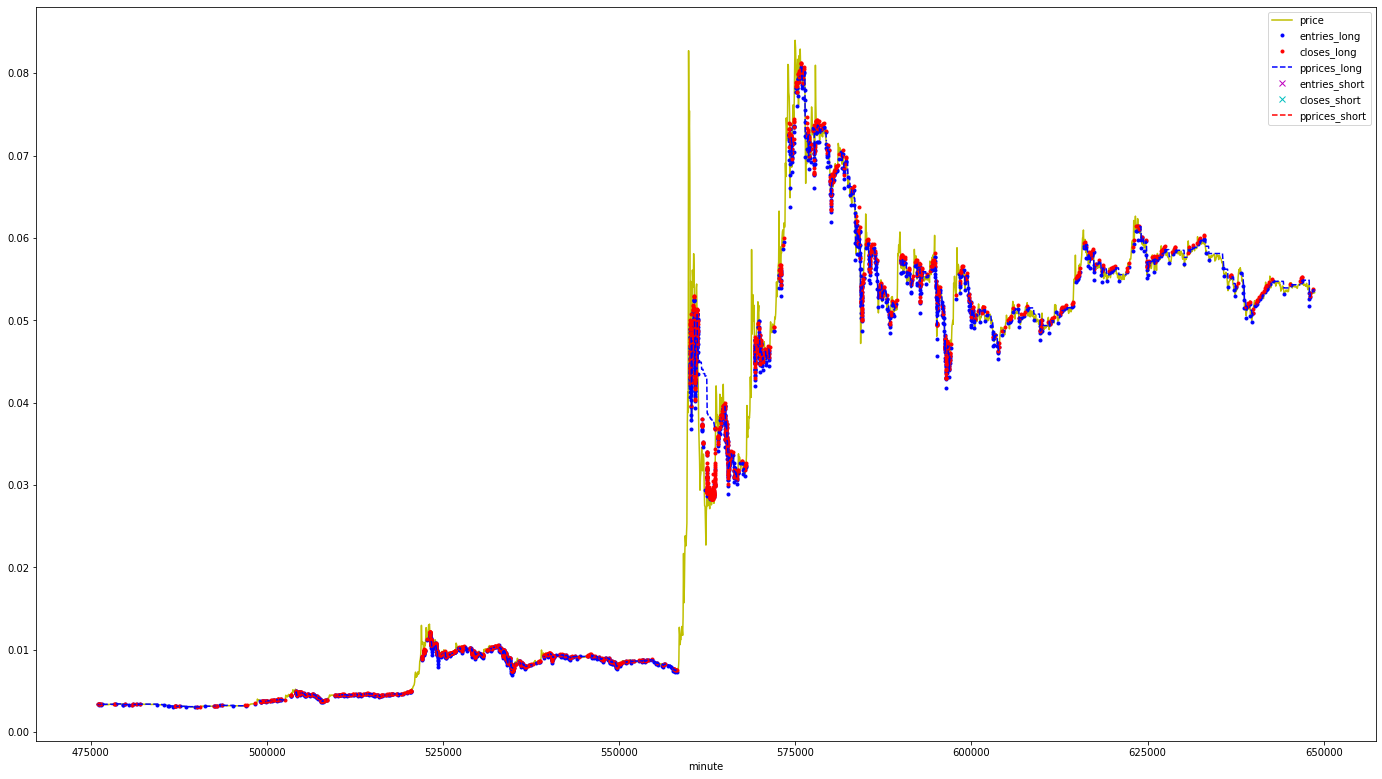

XRPUSDT_upnl_pct_l 96120.0


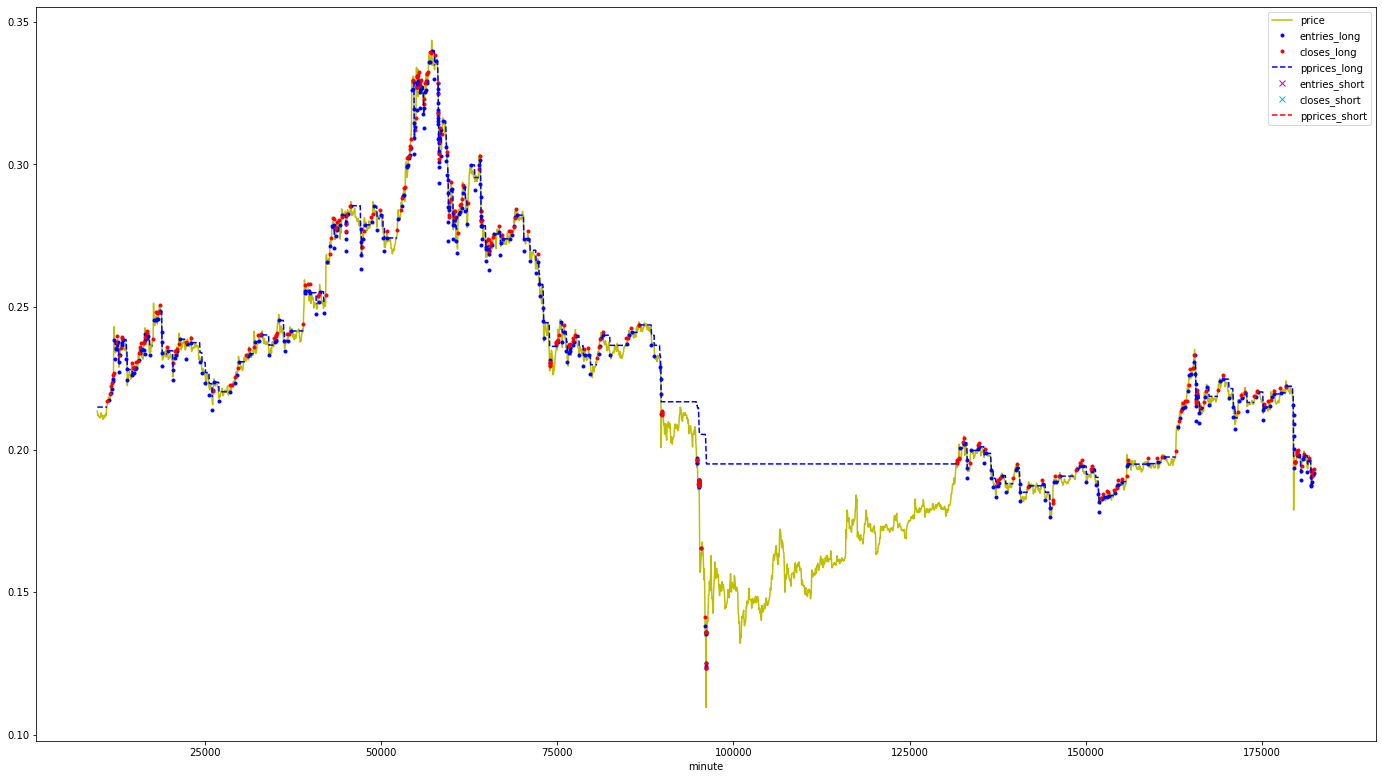

RLCUSDT_upnl_pct_l 718860.0


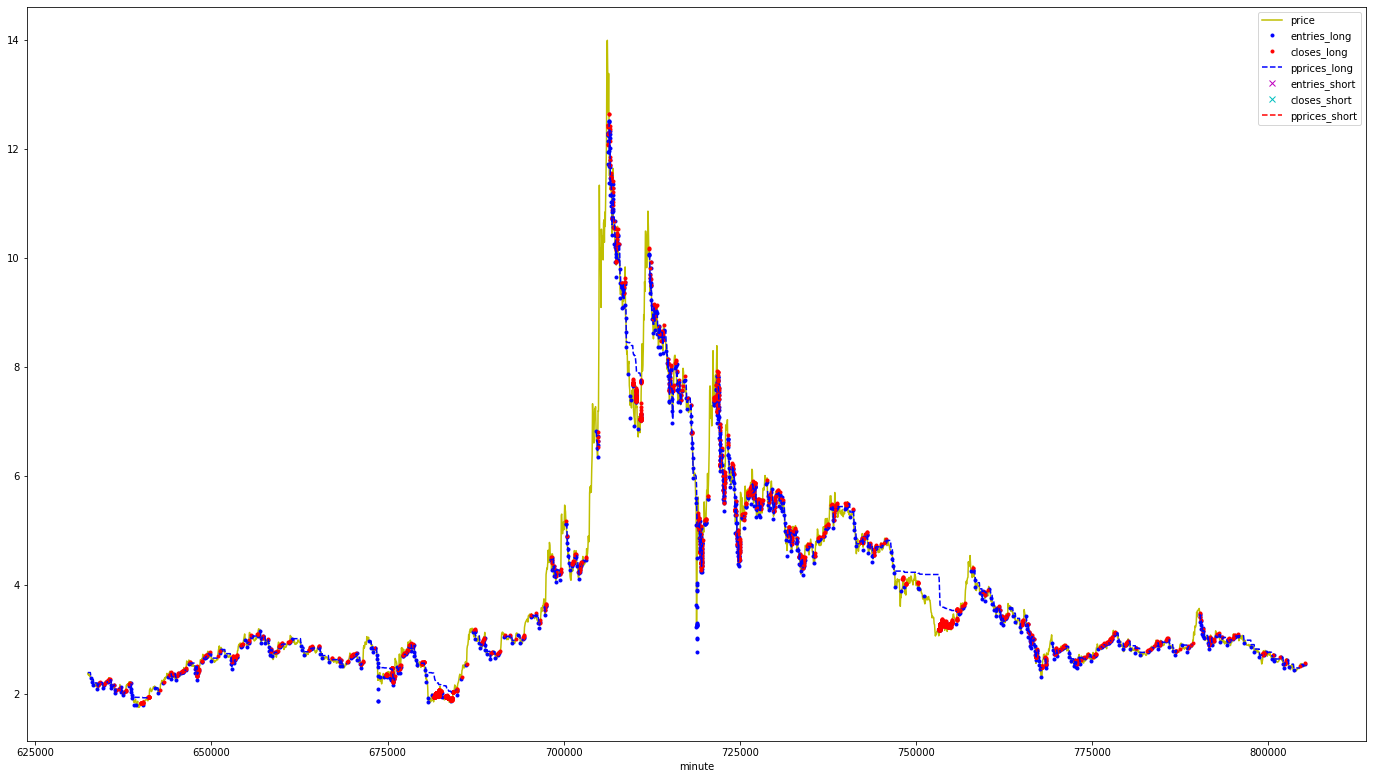

THETAUSDT_upnl_pct_l 718860.0


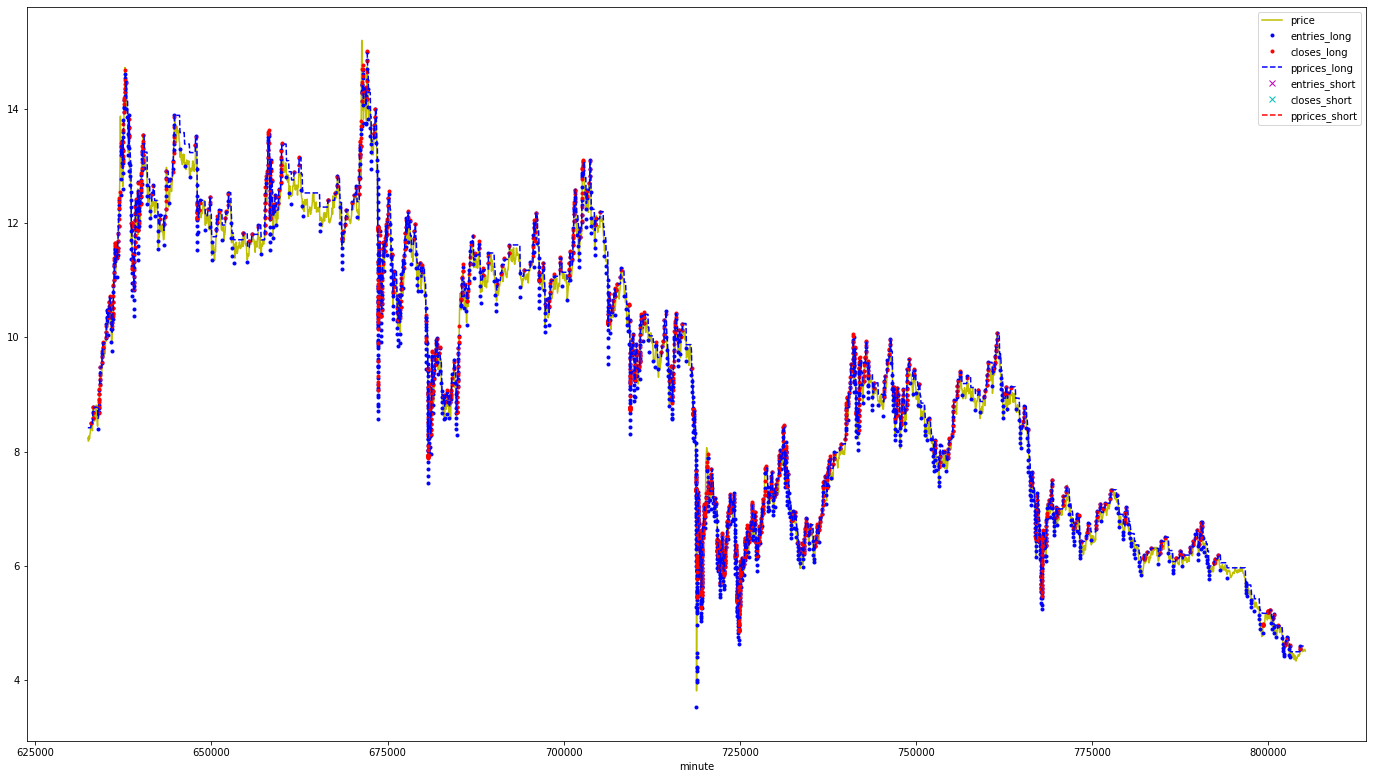

AAVEUSDT_upnl_pct_l 724800.0


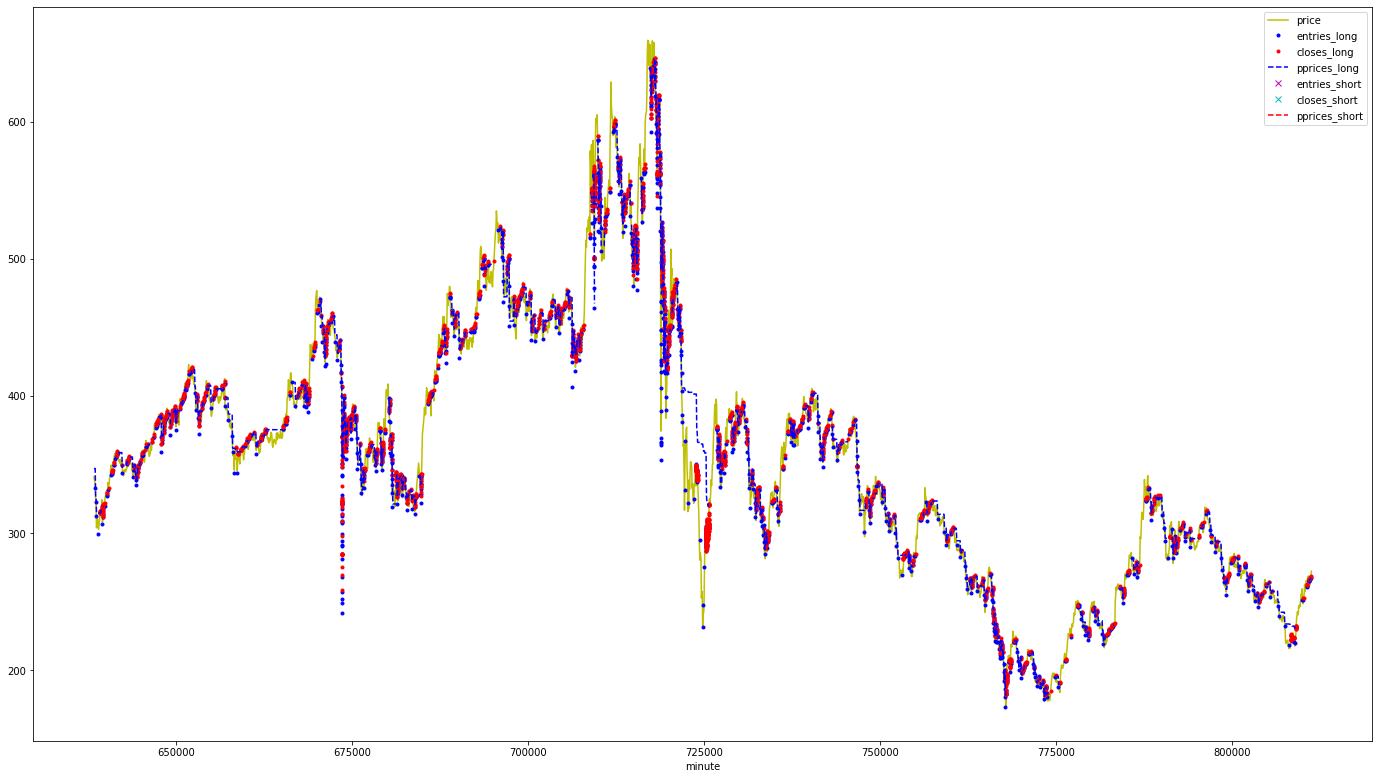

OCEANUSDT_upnl_pct_l 718860.0


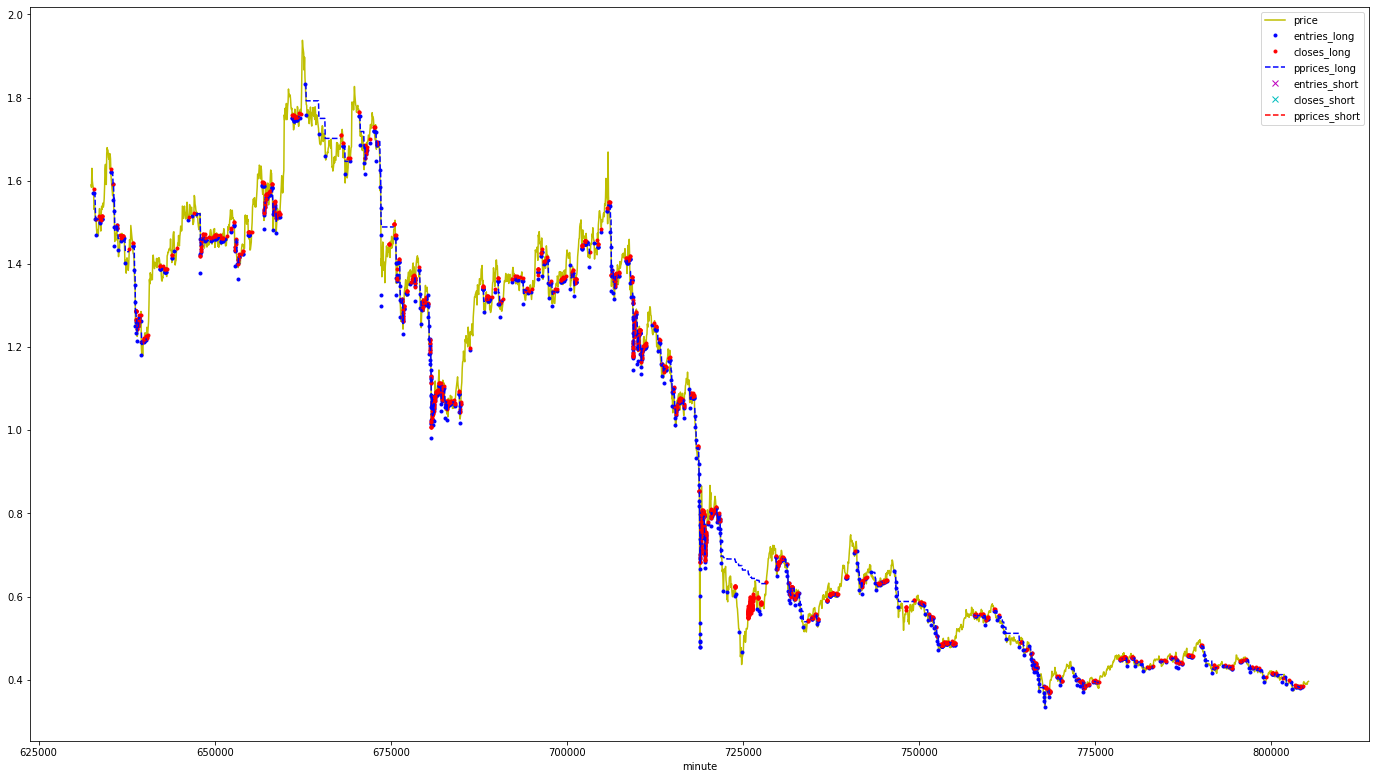

GRTUSDT_upnl_pct_l 718860.0


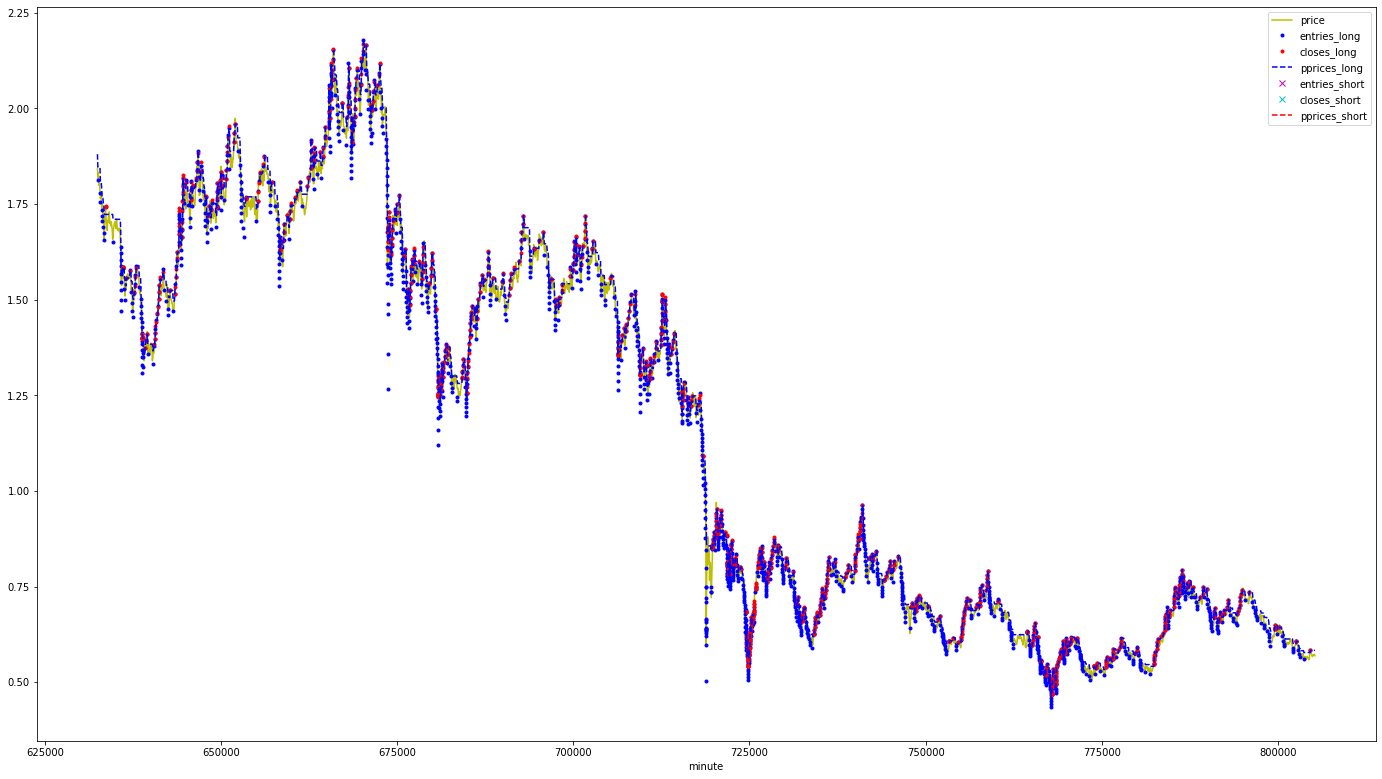

SNXUSDT_upnl_pct_l 718860.0


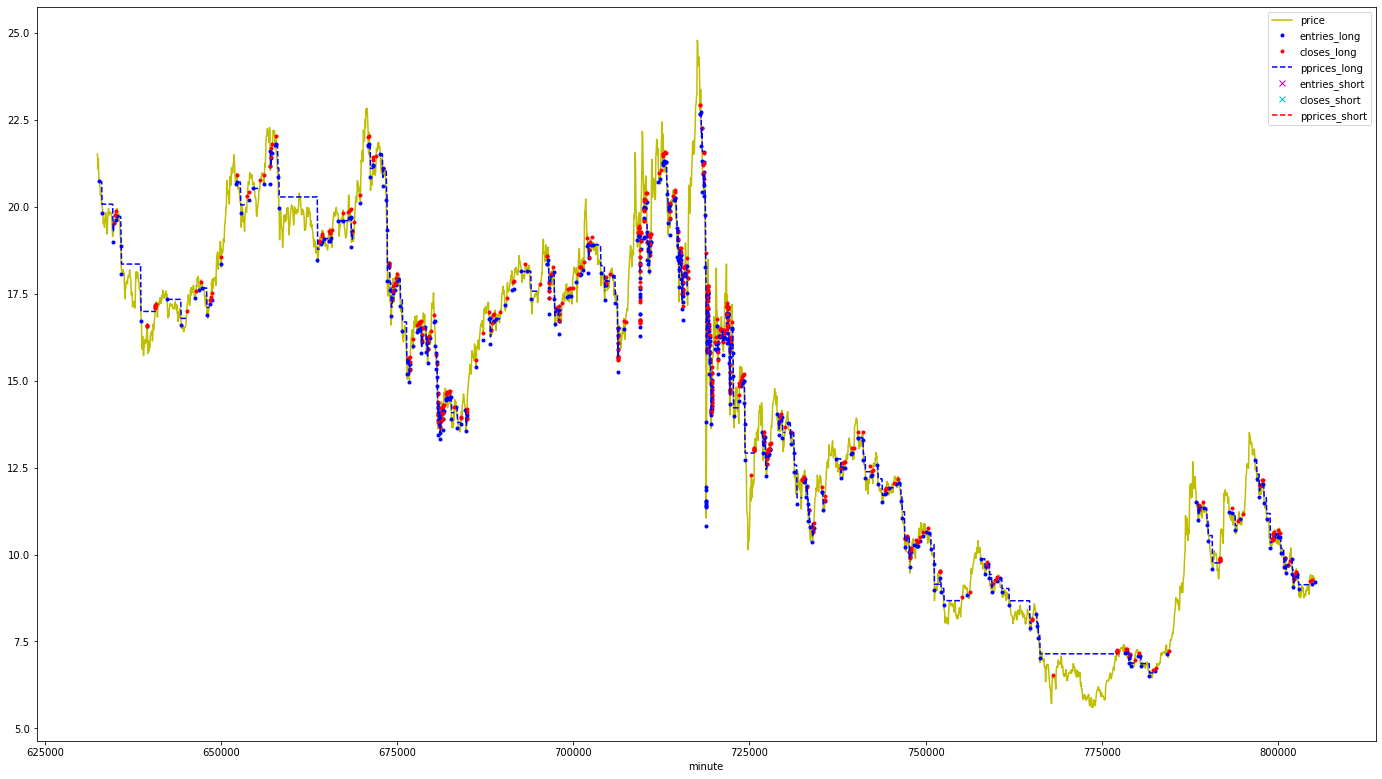

DOTUSDT_upnl_pct_l 718860.0


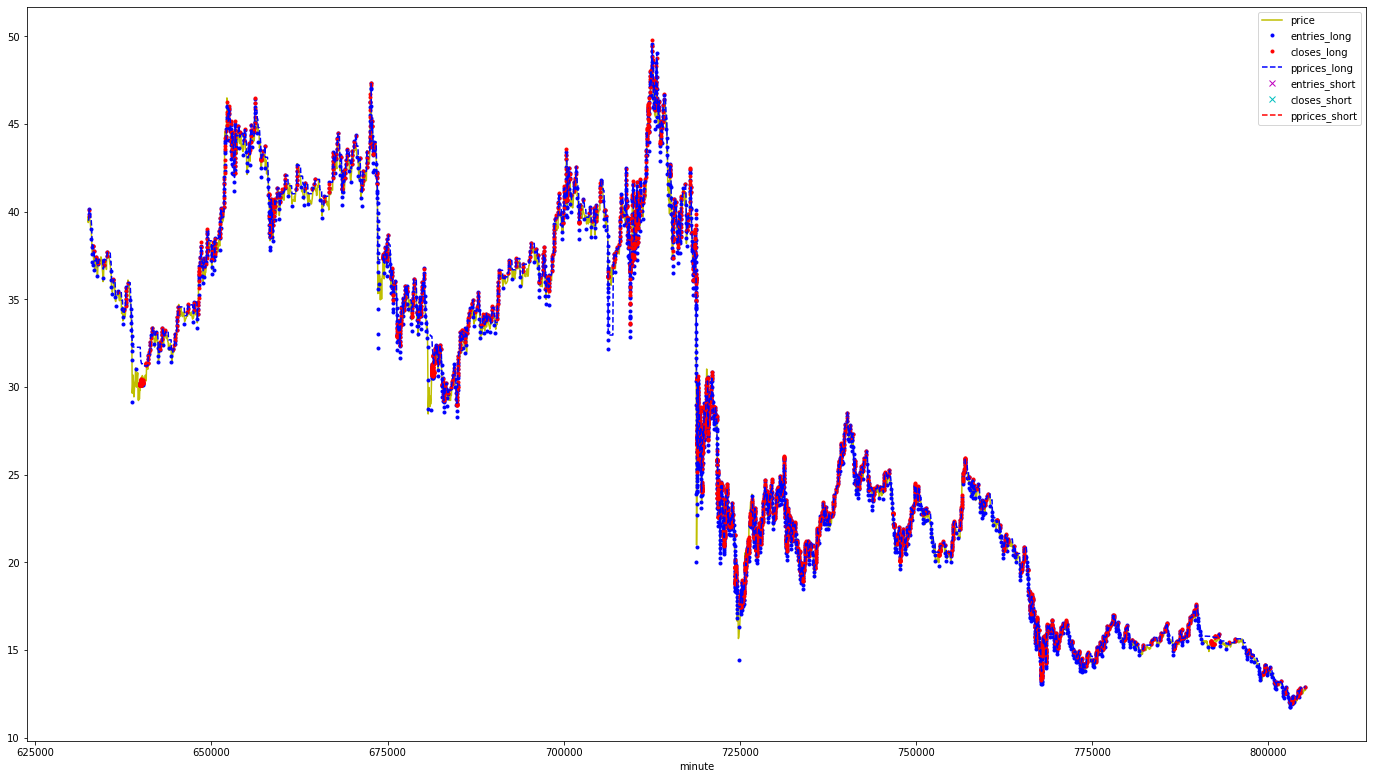

ENJUSDT_upnl_pct_l 718860.0


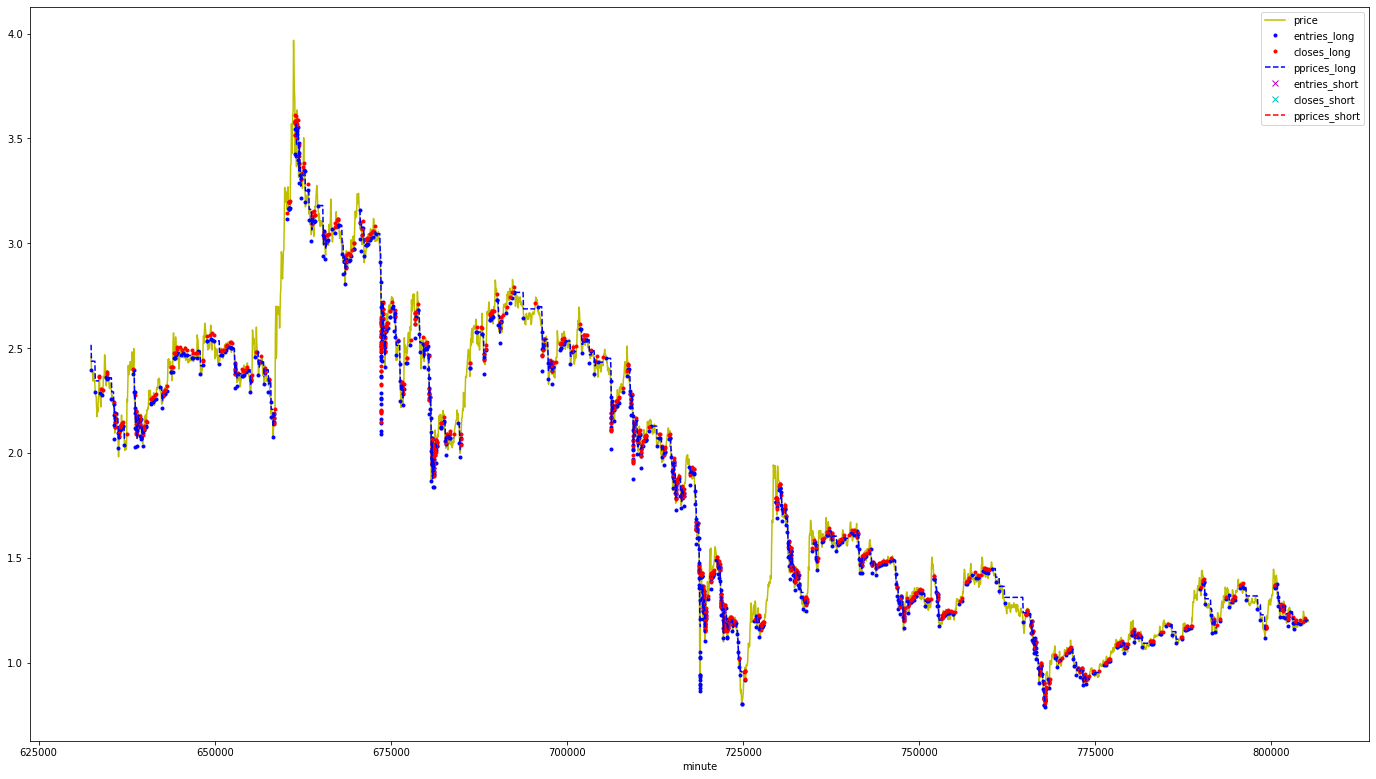

OMGUSDT_upnl_pct_l 718860.0


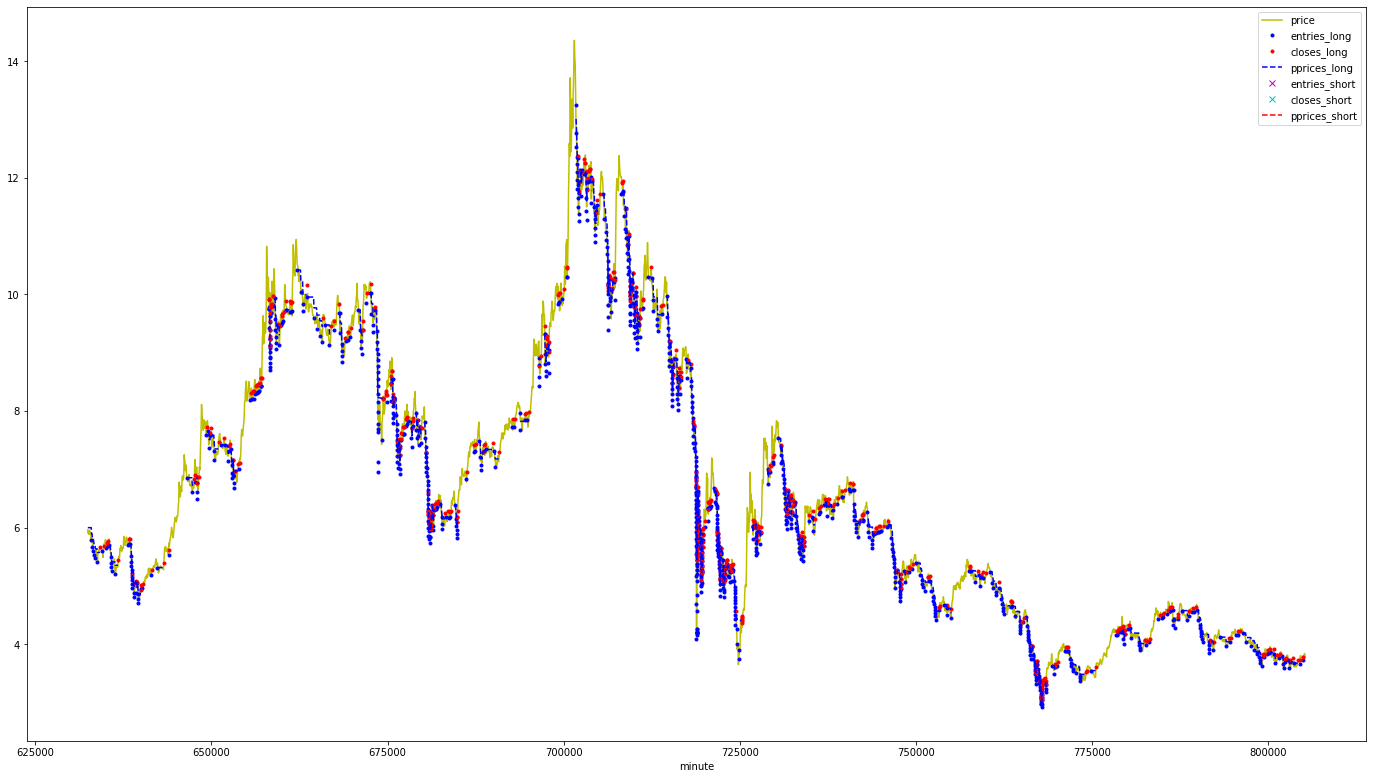

SKLUSDT_upnl_pct_l 718860.0


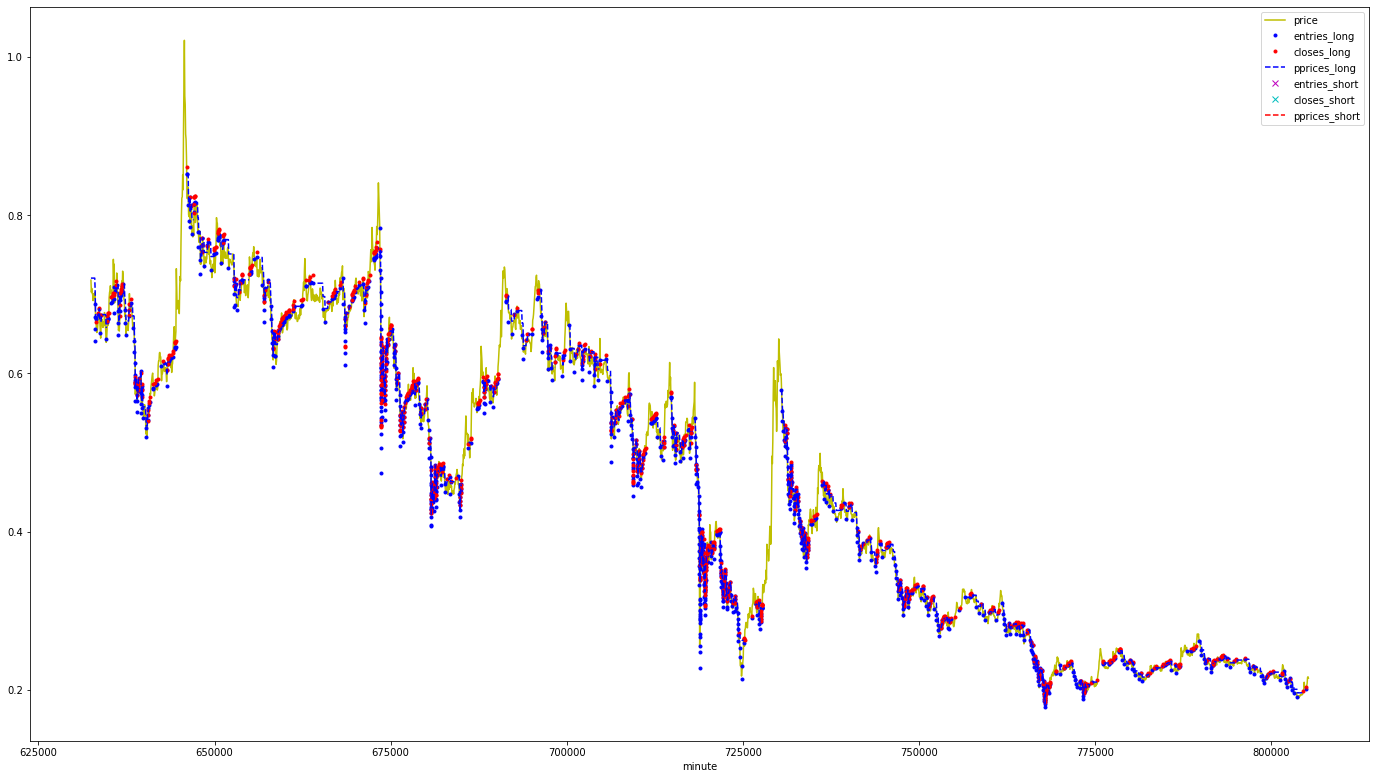

RSRUSDT_upnl_pct_l 718860.0


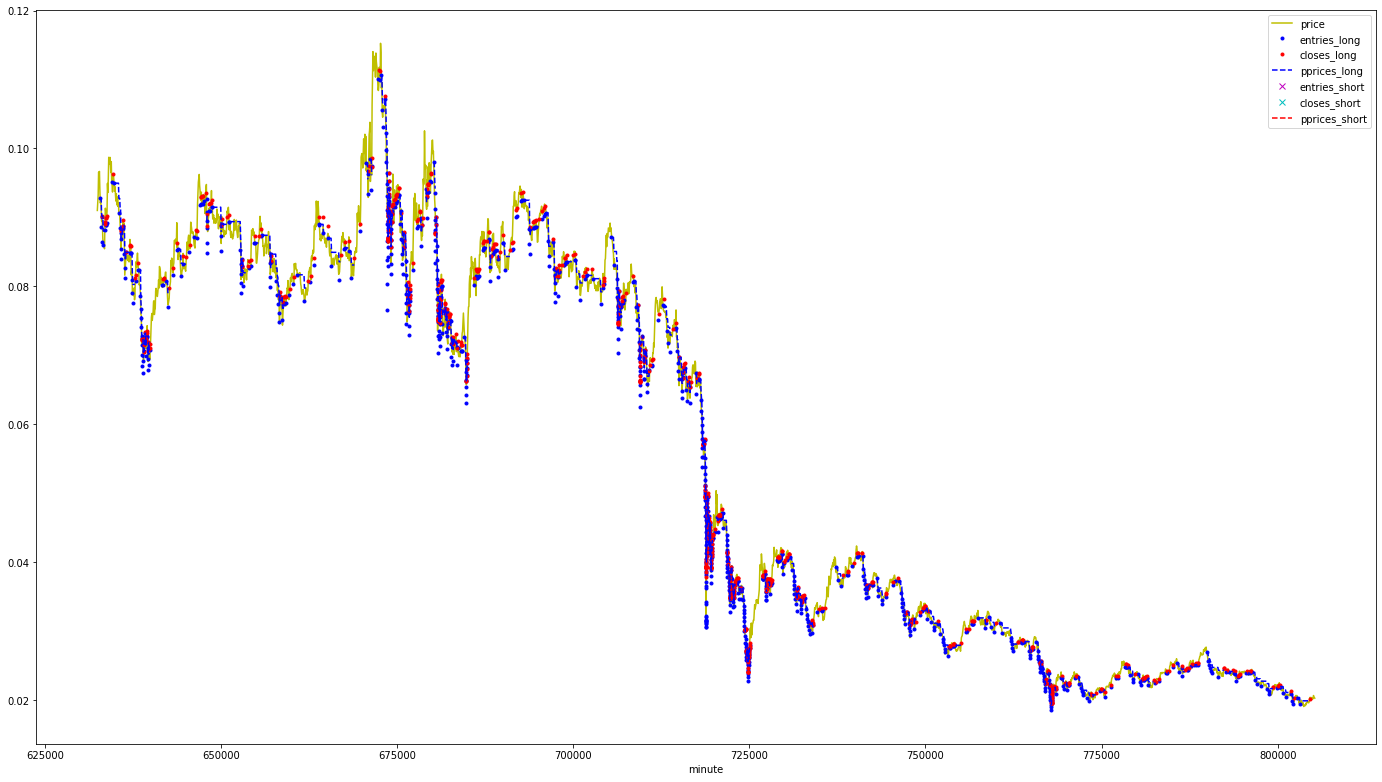

DEFIUSDT_upnl_pct_l 718860.0


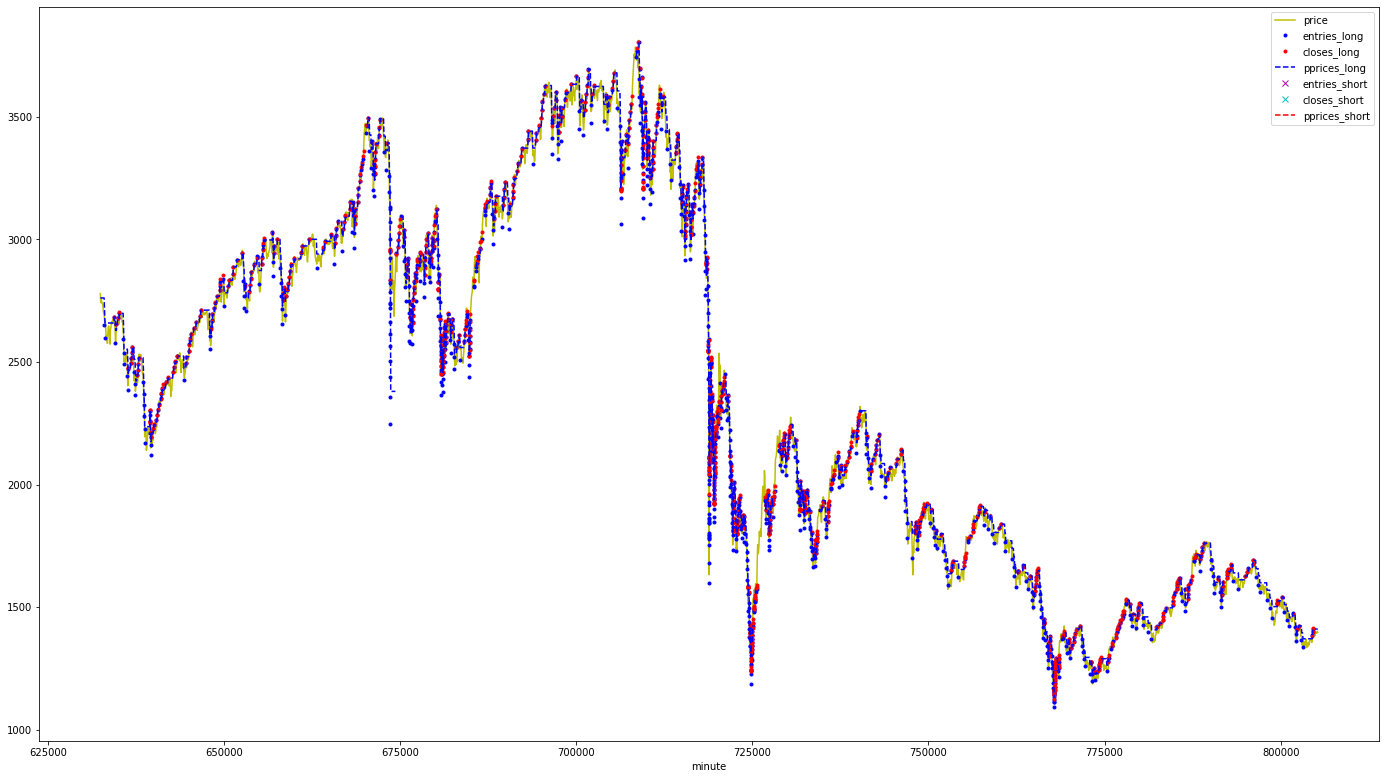

SUSHIUSDT_upnl_pct_l 507720.0


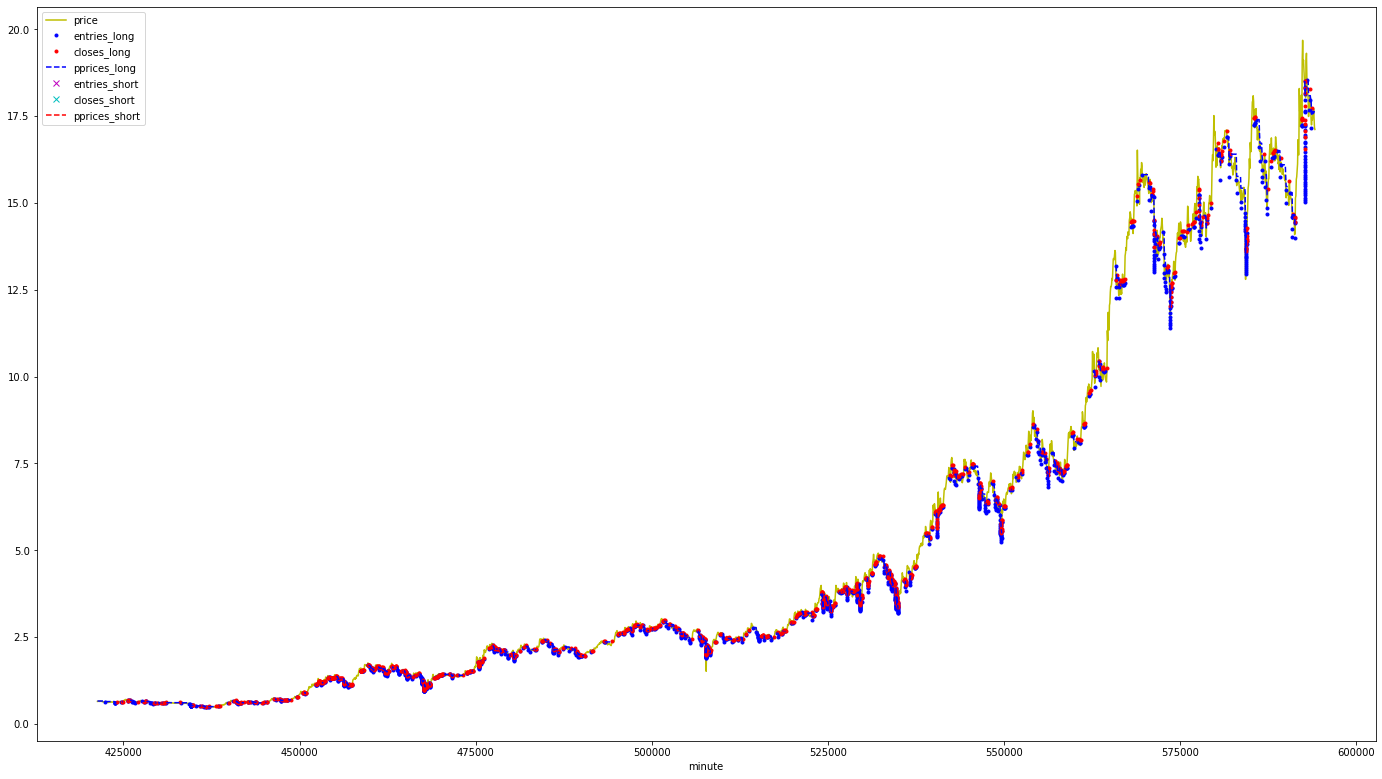

EGLDUSDT_upnl_pct_l 718860.0


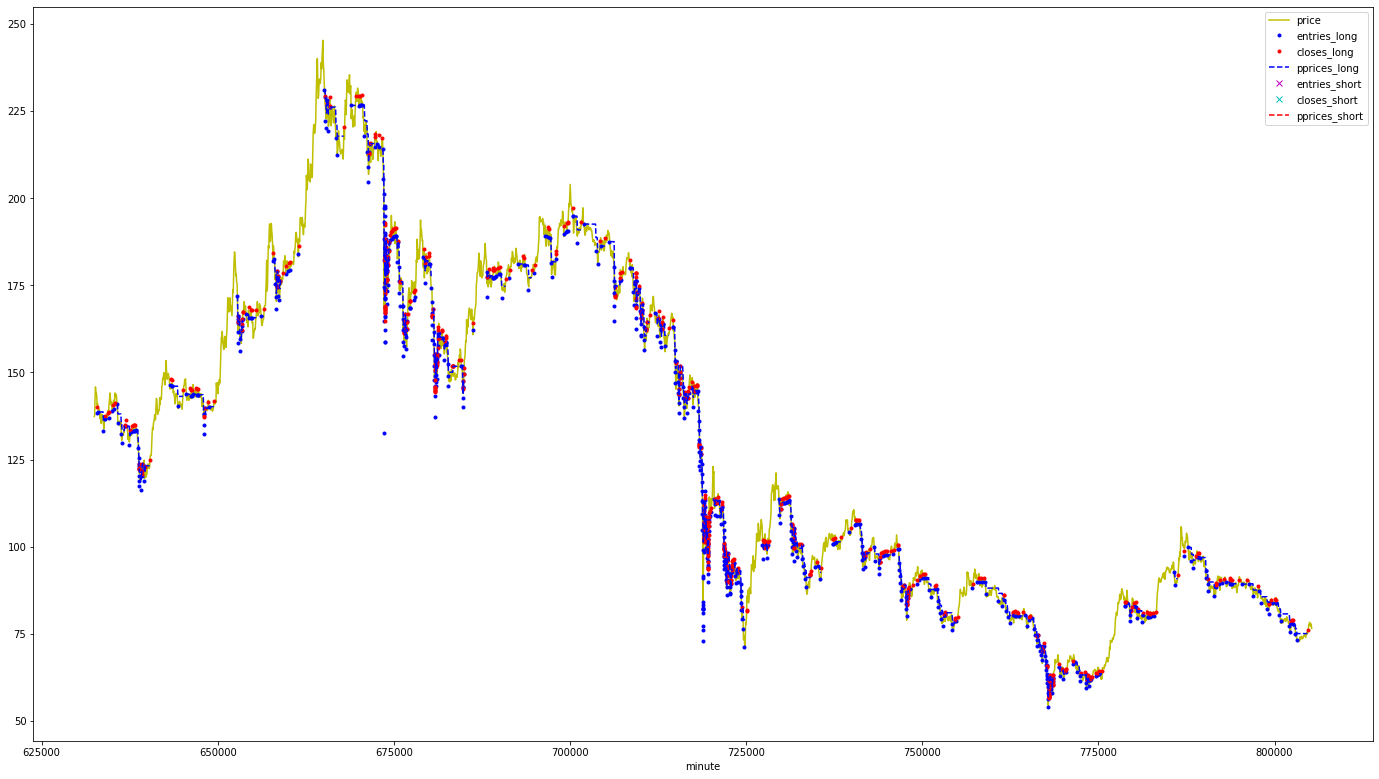

MKRUSDT_upnl_pct_l 724800.0


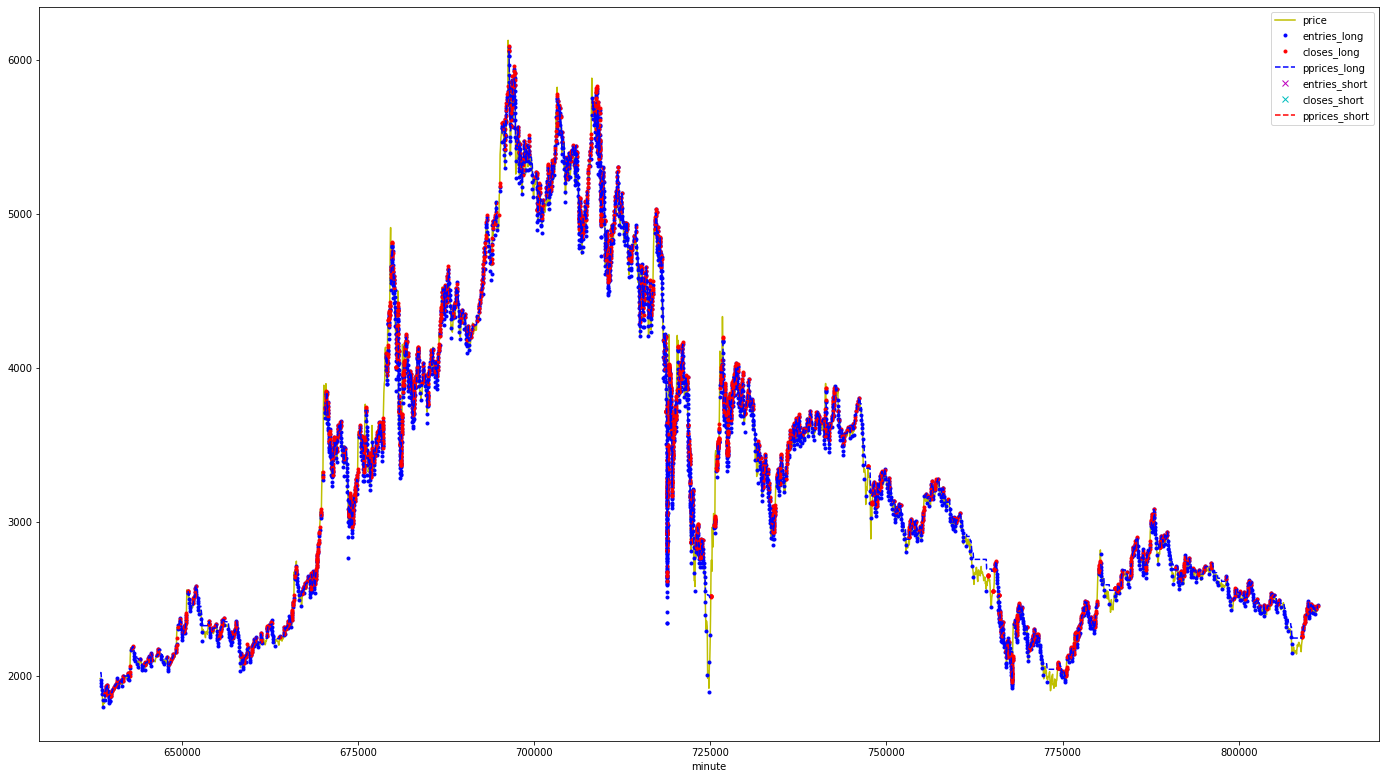

REEFUSDT_upnl_pct_l 718860.0


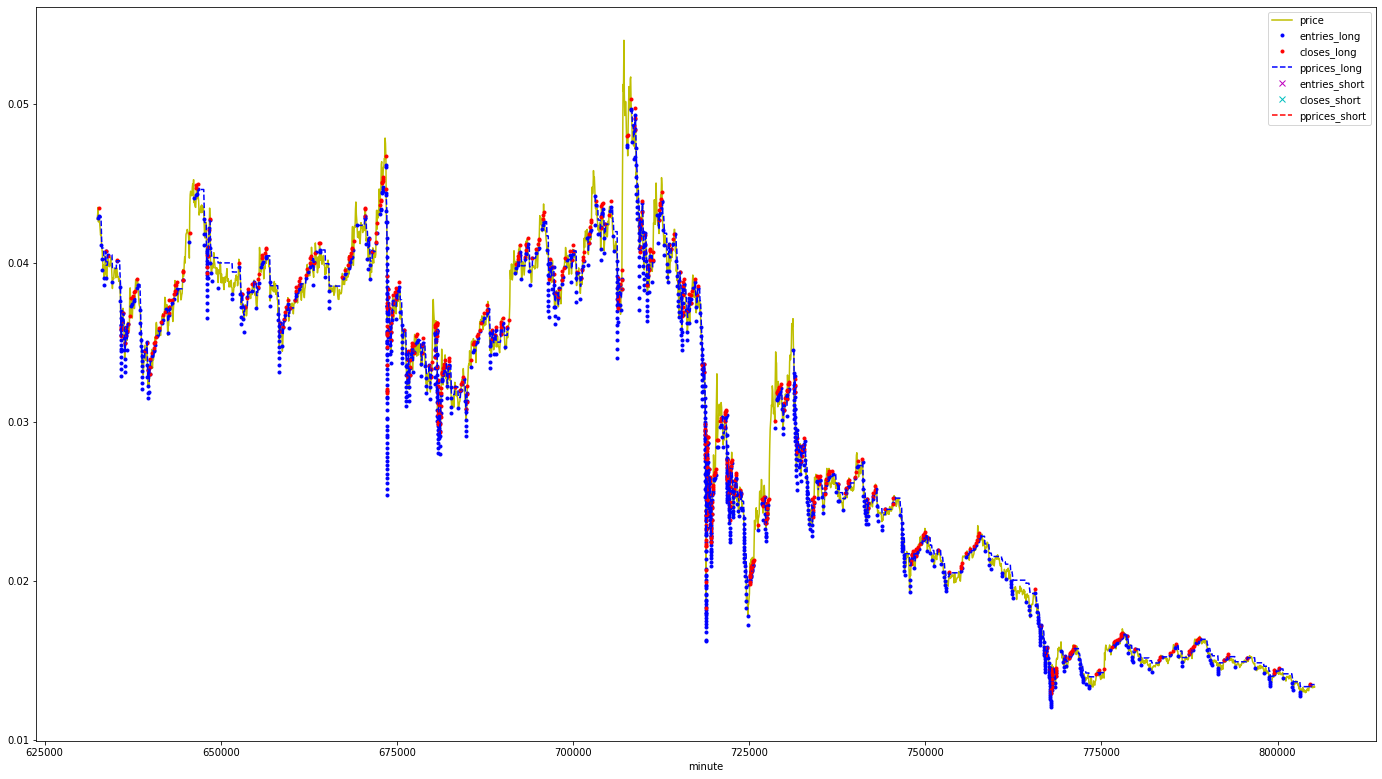

BANDUSDT_upnl_pct_l 718860.0


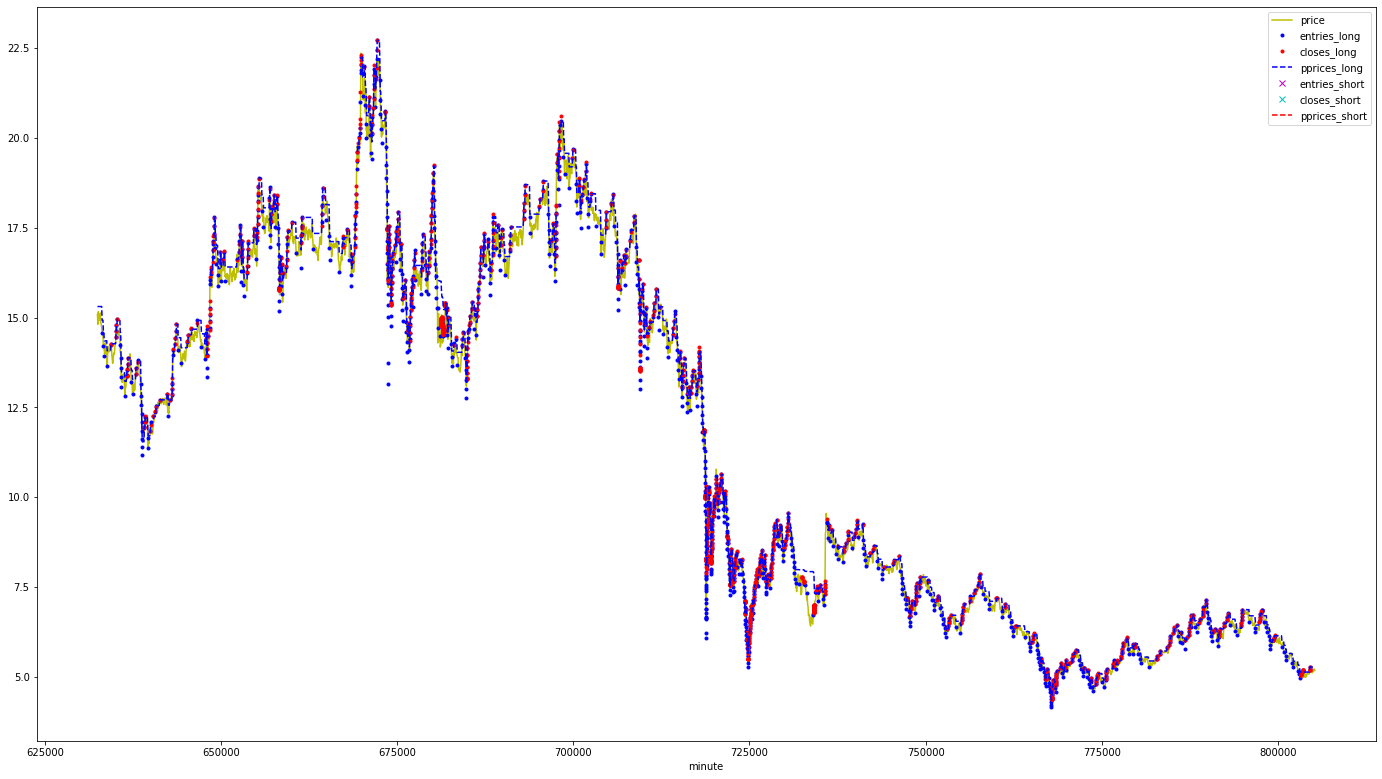

ZENUSDT_upnl_pct_l 1078920.0


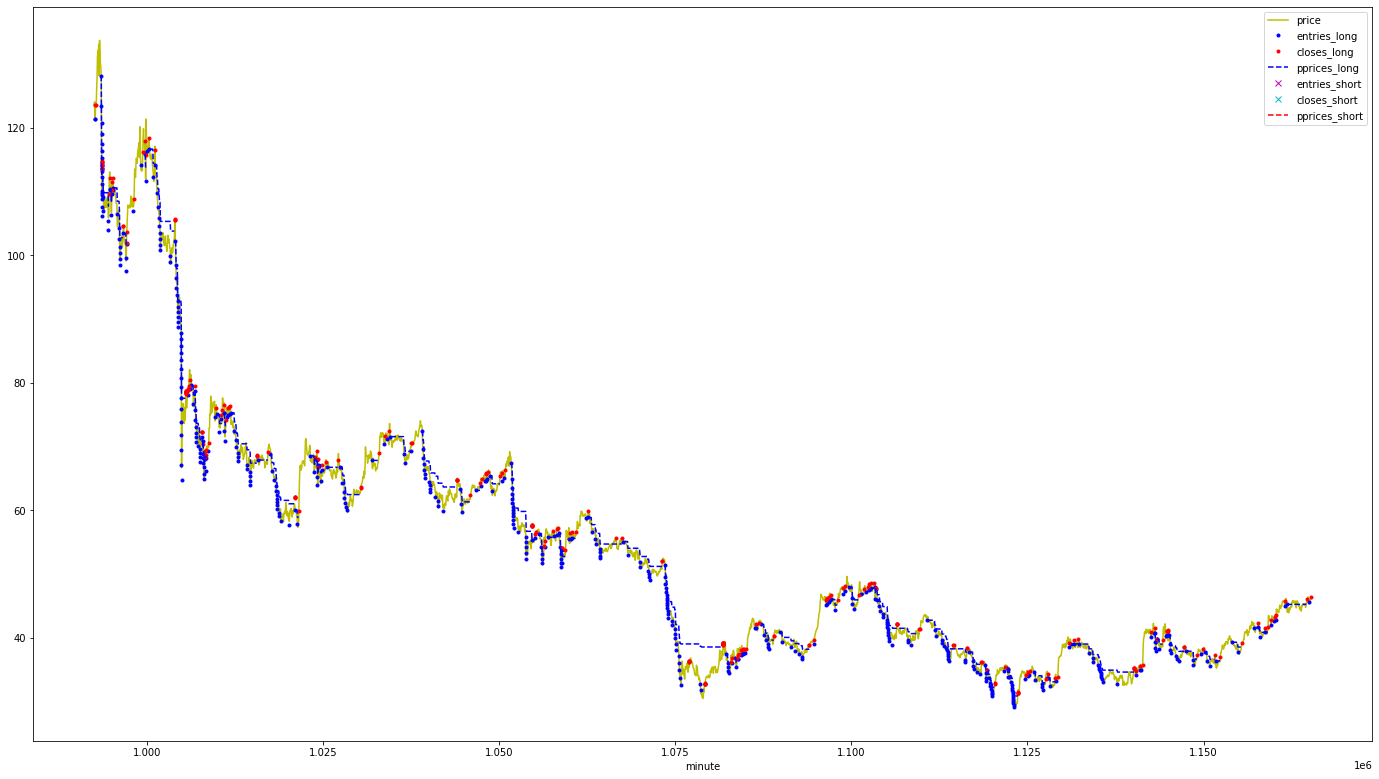

RUNEUSDT_upnl_pct_l 1004940.0


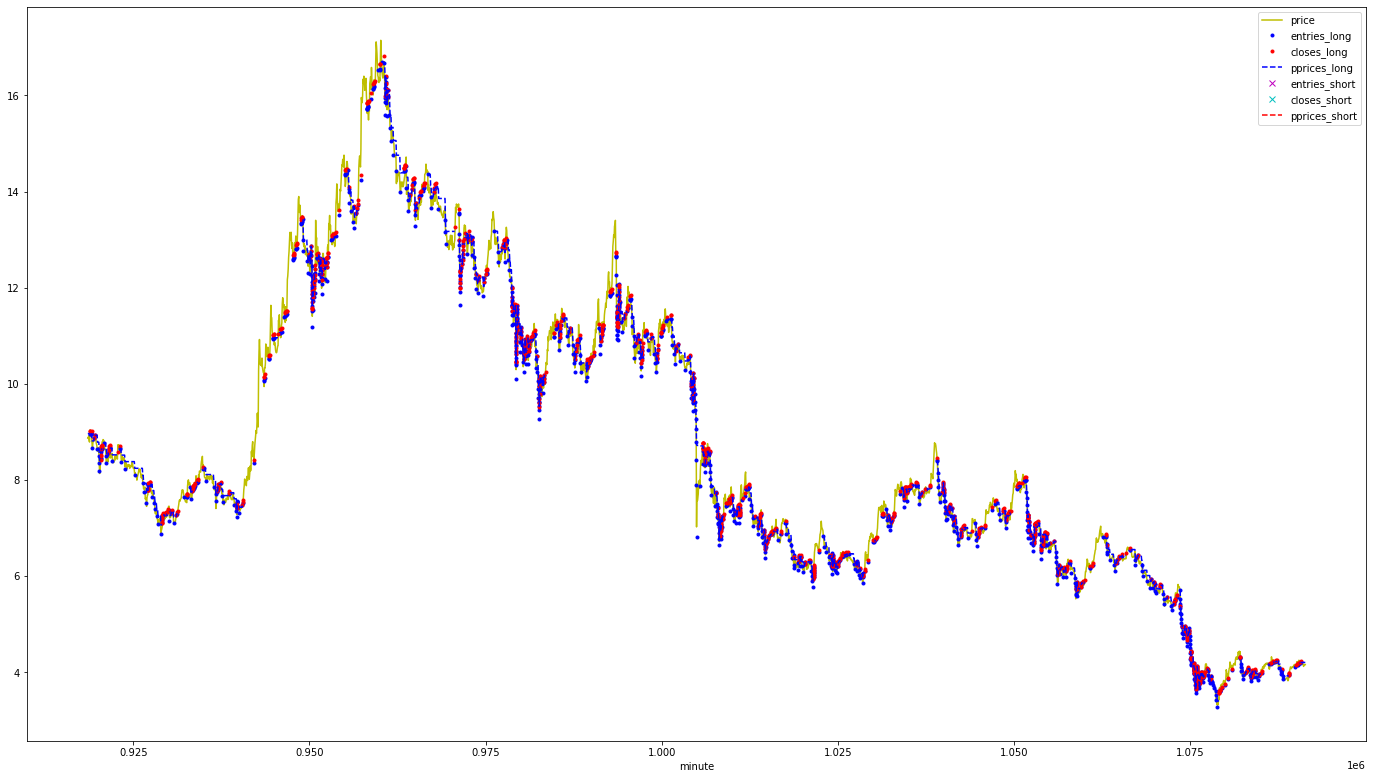

BLZUSDT_upnl_pct_l 1078800.0


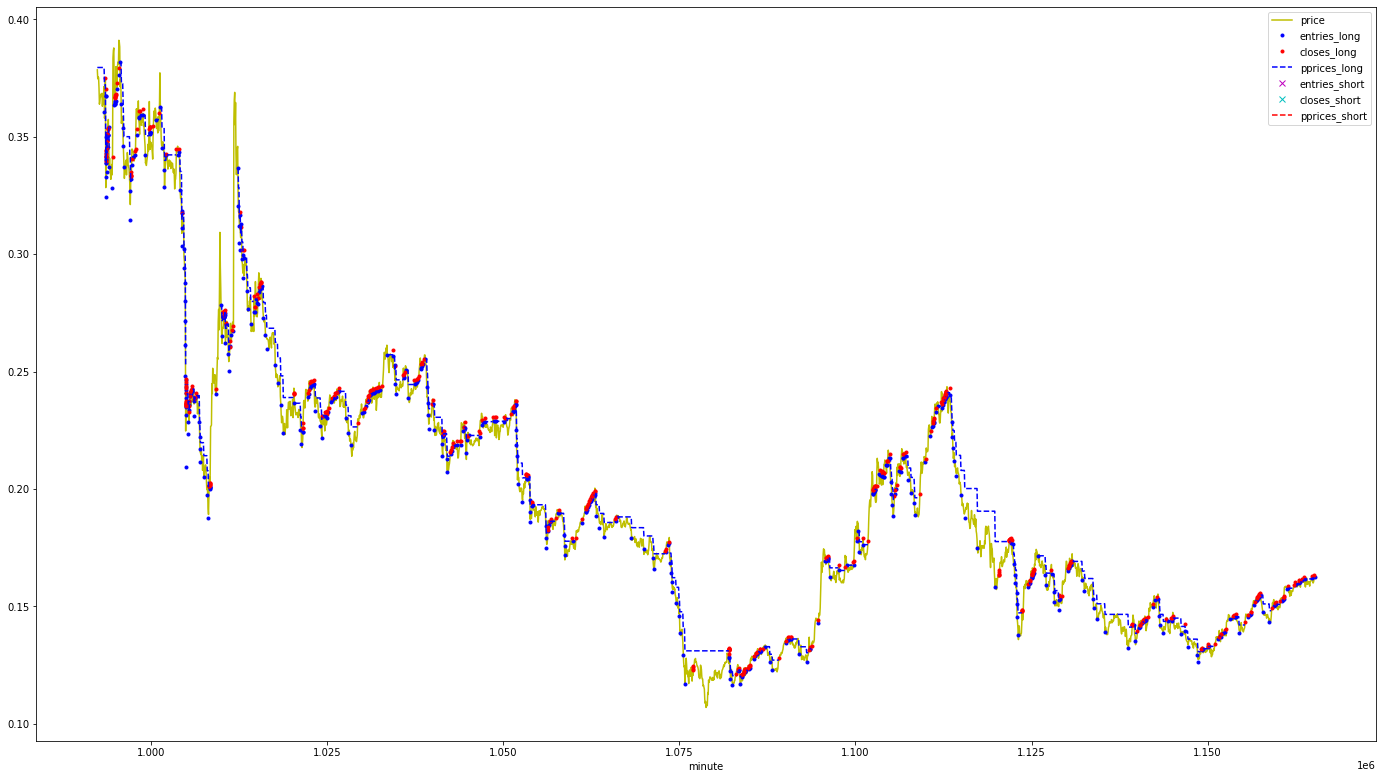

ZILUSDT_upnl_pct_l 1078920.0


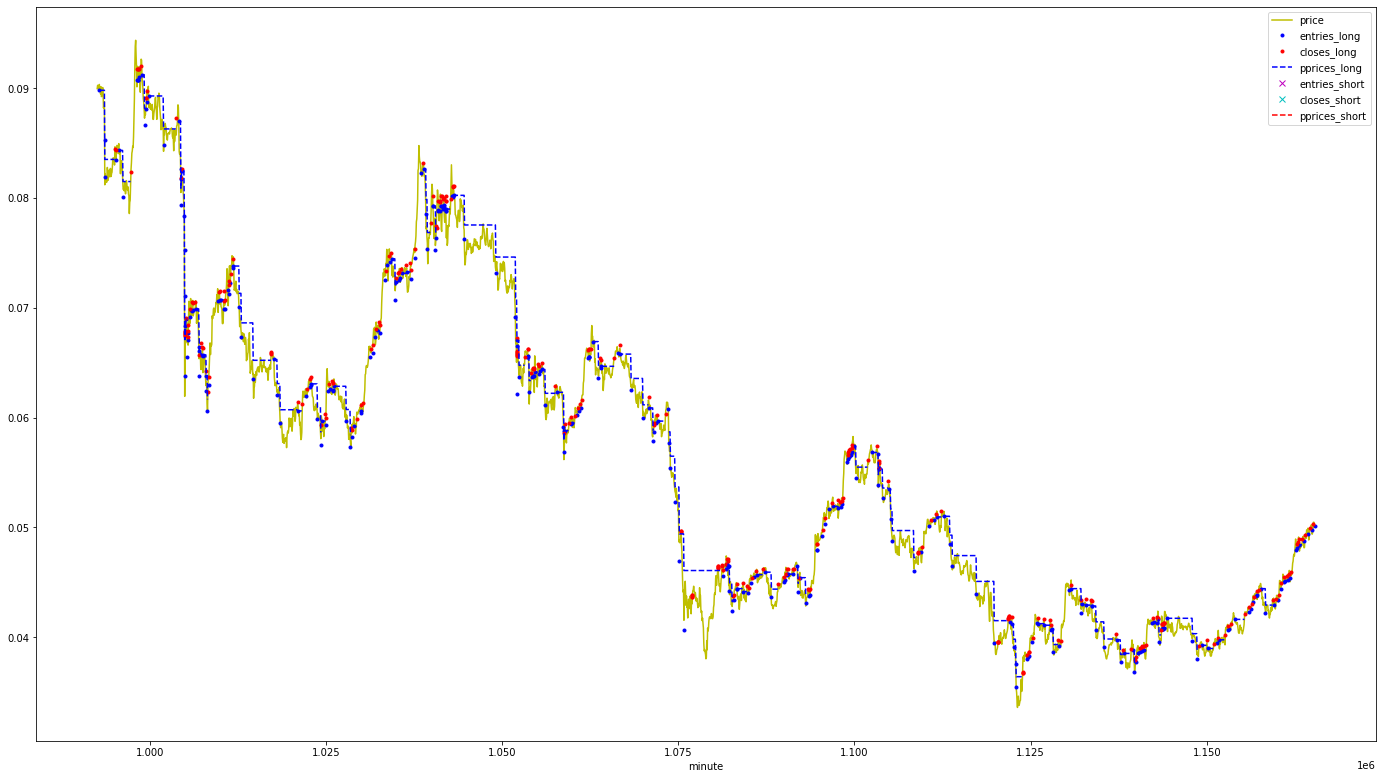

TOMOUSDT_upnl_pct_l 1837740.0


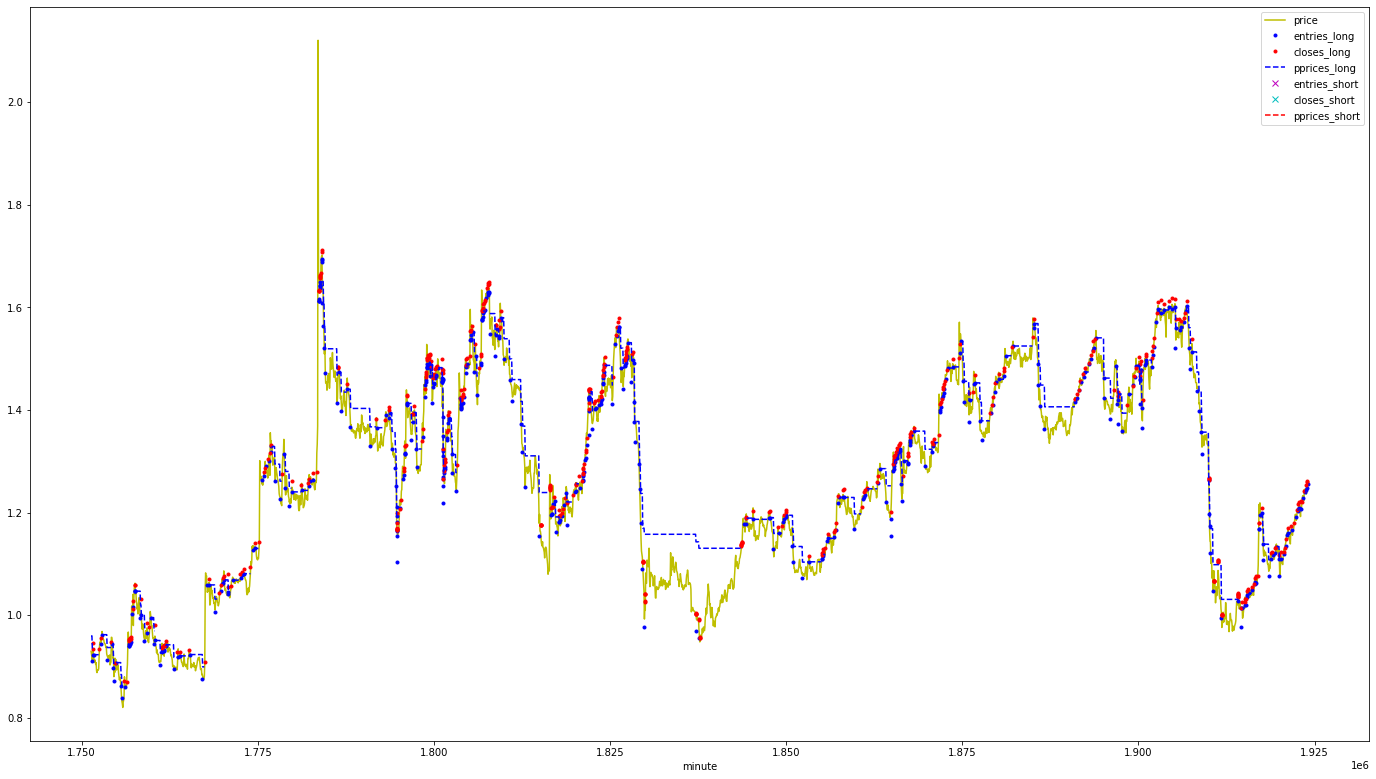

SXPUSDT_upnl_pct_l 292740.0


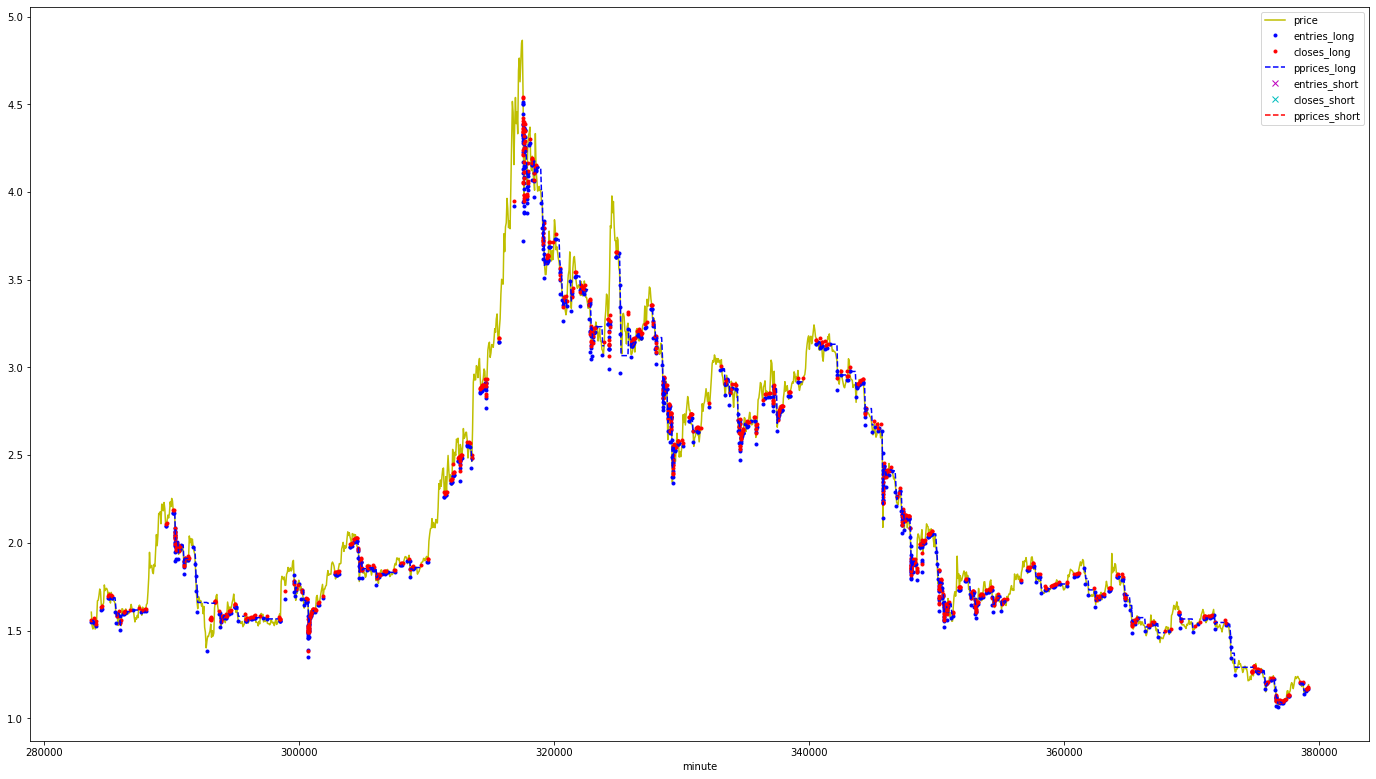

In [23]:
# inspect individual lowest drawdowns
upnl_pct_mins = sdf[[c for c in sdf.columns if "upnl" in c]].min().sort_values()
print(upnl_pct_mins)
print()
n = 60 * 24 * 60
upnl_pct_idxs = dict(sdf[[c for c in sdf.columns if "upnl" in c]].idxmin())
for sym in dict(upnl_pct_mins):
    idx = upnl_pct_idxs[sym]
    if np.isnan(idx):
        continue
    print(sym, idx)
    plot_fills_multi(
        sym[: sym.find("_")], sdf.loc[idx - n : idx + n], fdf.loc[idx - n : idx + n]
    ).show()

<AxesSubplot:xlabel='minute'>

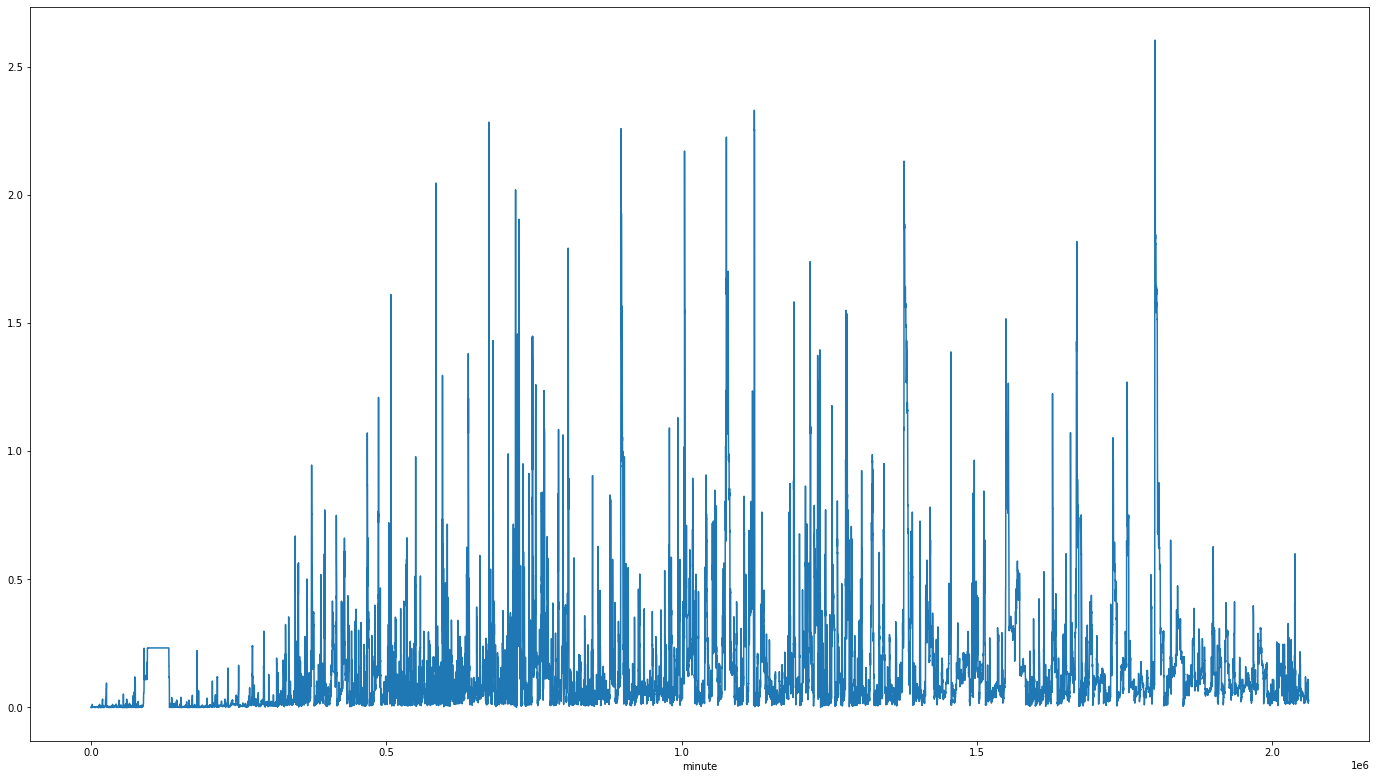

In [24]:
# exposures
sdf[[c for c in sdf.columns if "WE" in c]].sum(axis=1).plot()